In [1]:
import sys
import os
path = os.path.abspath("../../VecRepV3") 
sys.path.append(path)
print(path)

/home/jovyan/VecRepV3


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from scipy.linalg import orthogonal_procrustes

import src.data_processing.BruteForceEstimator as bfEstimator
import src.data_processing.ImageCalculations as imgcalc
import src.visualization.ImagePlots as imgplt
import src.helpers.ModelUtilities as models
import src.data_processing.Utilities as utils
import src.helpers.FilepathUtils as Futils
import src.data_processing.EmbeddingFunctions as embedfunc

from src.visualization import SamplingMethod, BFmethod
from src.data_processing.SampleEstimator import SampleEstimator
from functools import partial
from learnable_polyphase_sampling.learn_poly_sampling.layers import get_logits_model, PolyphaseInvariantDown2D, LPS
from learnable_polyphase_sampling.learn_poly_sampling.layers.polydown import set_pool

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
print(device)

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


cuda


(500, 16, 16)


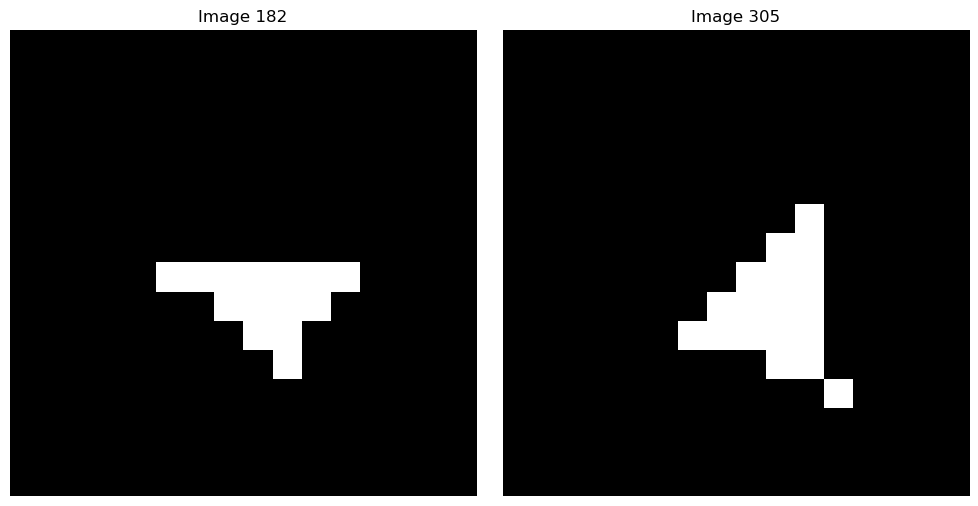

In [3]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 64

imageType = "shapes_3_dims_10_3" #6x6 triangle in 12x12 matrix shapes_3_dims_6_3
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k=5

#percentage = 0.41
# imageSet = utils.generate_filtered_image_set(imageType, filters, Futils.get_image_set_filepath(imageType, filters))
# imageSet = np.array(imageSet)

# sampleName = f"{imageType} {filters} {percentage} sample"

# sampleEstimator = SampleEstimator(sampleName=sampleName, embeddingType=embeddingType, imageProductType=imageProductType)
# #print(len(sampleEstimator.trainingImageSet))
# testSample = np.array([img for img in imageSet if not np.any([np.array_equal(img, train_img) for train_img in sampleEstimator.trainingImageSet])])
# #brute force one more image for dimension 128 T-T
# # testSample = np.append(testSample, [sampleEstimator.trainingImageSet[50]], axis=0)
testSample = np.load('/home/jovyan/VecRepV3/data/test_images.npy')
print(testSample.shape)
# index1 = np.random.randint(len(testSample))
# index2 = np.random.randint(len(testSample))
index1 = 182
index2 = 305
input1=testSample[index1]
input2=testSample[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

# ------------------------- Preprocessing Dataset ------------------------
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]

In [4]:
model = models.SimpleCNN1(dimensions=dimensions, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                                              f'best_model_{imageType}_{dimensions}d_convlayer0.pt')))
model.eval()

/tmp/ipykernel_15056/1600593688.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model",

SimpleCNN1(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
  (lpd): PolyphaseInvariantDown2D(
    (component_selection): LPS(
      (get_logits): LPSLogitLayersV2(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, padding_mode=circular)
        (relu): ReLU()
      )
    )
  )
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.1)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=32, out_features=64, bias=True)
)

In [5]:
#----------------------Metric 1 - Loss Calculation-----------------
NCC_scaled_value = imgcalc.get_NCC_score(input1, input2)
print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[index1])
embedded_vector_image2 = model(input_dataset[index2])

dot_product_value = imgcalc.get_dp_score(embedded_vector_image1, embedded_vector_image2)

print("Dot product value of model: ", dot_product_value.item())

train_loss_value = imgcalc.get_loss_value(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)

dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method: ", dot_product_value_Pencorr)

train_loss_value = imgcalc.get_loss_value(torch.tensor(dot_product_value_Pencorr), NCC_scaled_value) 
print("Loss: ", train_loss_value)
print("Difference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  0.2598816156387329
Dot product value of model:  0.725686252117157
Loss:  0.4658046364784241

Dot product value of BF Method:  0.24544920931091688
Loss:  0.014432400465011597
Difference in values of BF Method and Model Method:  0.48023703694343567


----------------
Brute Force Method -- KNN-IOU score
----------------
Estimating K-Score for Image 182: K-Score = 0.5
Intersection sets : [182 286 474 498]
Union sets: [ 19  35  82 182 286 311 474 498]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   182                    1.000000                            1.000000
    19                    0.685330                            0.778137
    35                    0.737198                            0.750453
    82                    0.685330                            0.756884
   286                    0.857143                            0.917435
   311                    0.714286                            0.684653
   474                    0.814970                            0.879061
   498                    0.857143                            0.926100

Comparing images in intersection & union sets

Plotting images in the intersection set:


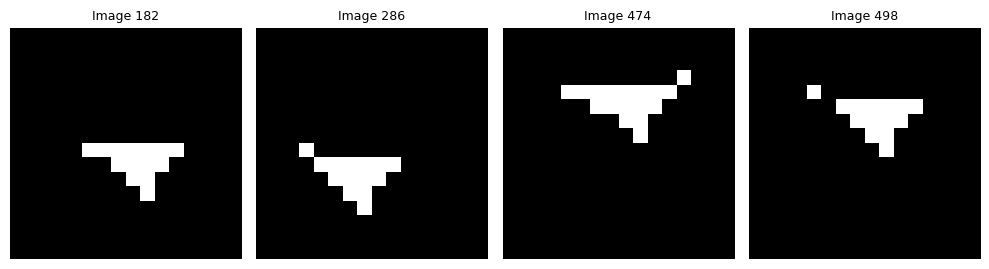


Plotting images in the union set:


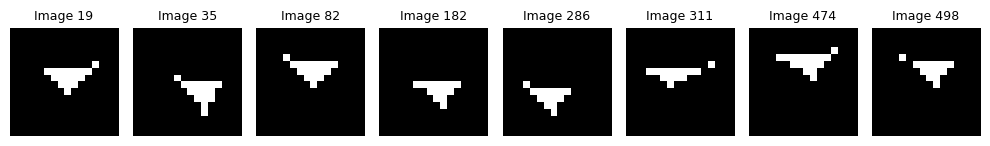


For translationally unique plots: 
Image 19 has no translationally similar images.
Image 35 has no translationally similar images.
Image 82 has no translationally similar images.
Image 182 has no translationally similar images.
Image 286 has no translationally similar images.
Image 311 has no translationally similar images.
Image 474 has no translationally similar images.
Image 498 has no translationally similar images.

Plotting images in the intersection set:


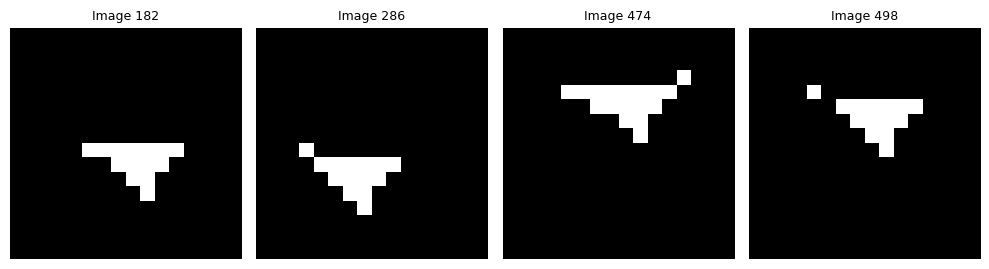


Plotting images in the union set:


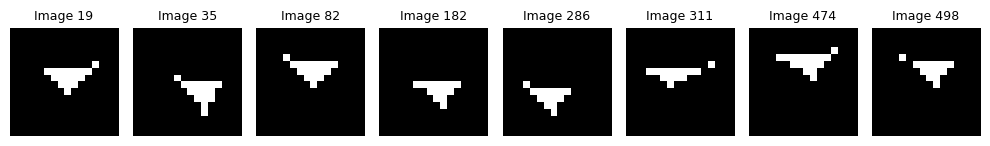


Top 16 values of Vector b
Rank 1: Value = 1.0, Index = 182
Rank 2: Value = 0.8571428060531616, Index = 286
Rank 3: Value = 0.8571428060531616, Index = 498
Rank 4: Value = 0.8149704933166504, Index = 474
Rank 5: Value = 0.7371978759765625, Index = 35
Rank 6: Value = 0.7142857313156128, Index = 311
Rank 7: Value = 0.6973369121551514, Index = 287
Rank 8: Value = 0.685329794883728, Index = 19
Rank 9: Value = 0.685329794883728, Index = 280
Rank 10: Value = 0.6853296756744385, Index = 82
Rank 11: Value = 0.6116459369659424, Index = 267
Rank 12: Value = 0.6116459369659424, Index = 278
Rank 13: Value = 0.6116459369659424, Index = 323
Rank 14: Value = 0.6116458177566528, Index = 285
Rank 15: Value = 0.5954481363296509, Index = 207
Rank 16: Value = 0.5954478979110718, Index = 233

Top 16 values of Vector c
Rank 1: Value = 0.9999999999999996, Index = 182
Rank 2: Value = 0.9260999362495378, Index = 498
Rank 3: Value = 0.9174347671860066, Index = 286
Rank 4: Value = 0.8790605479290923, Index = 474

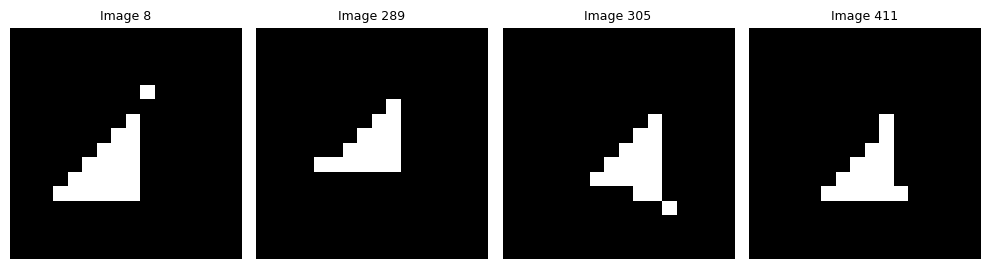


Plotting images in the union set:


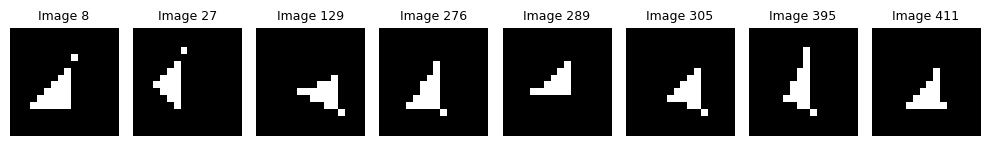


For translationally unique plots: 
Image 8 has no translationally similar images.
Image 27 has no translationally similar images.
Image 129 has no translationally similar images.
Image 276 has no translationally similar images.
Image 289 has no translationally similar images.
Image 305 has no translationally similar images.
Image 395 has no translationally similar images.
Image 411 has no translationally similar images.

Plotting images in the intersection set:


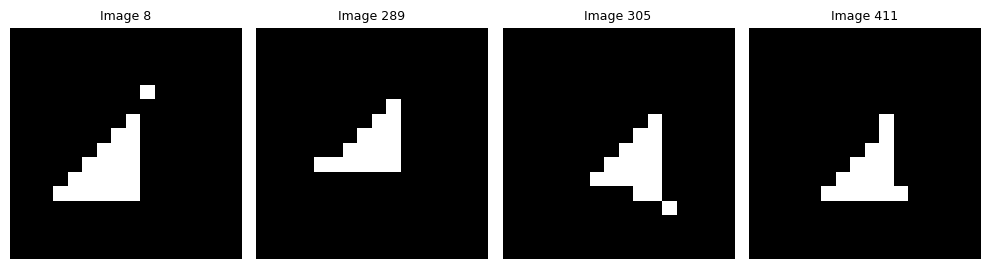


Plotting images in the union set:


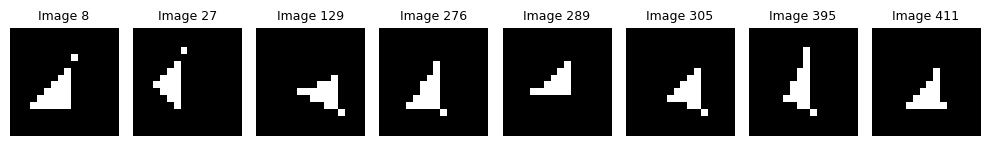


Top 16 values of Vector b
Rank 1: Value = 1.0, Index = 305
Rank 2: Value = 0.767767071723938, Index = 289
Rank 3: Value = 0.7149859666824341, Index = 27
Rank 4: Value = 0.7149859666824341, Index = 129
Rank 5: Value = 0.7149858474731445, Index = 411
Rank 6: Value = 0.7085644006729126, Index = 8
Rank 7: Value = 0.686548113822937, Index = 276
Rank 8: Value = 0.686548113822937, Index = 392
Rank 9: Value = 0.686548113822937, Index = 395
Rank 10: Value = 0.6666666269302368, Index = 461
Rank 11: Value = 0.6378459930419922, Index = 455
Rank 12: Value = 0.6329929828643799, Index = 187
Rank 13: Value = 0.6222143173217773, Index = 260
Rank 14: Value = 0.608060359954834, Index = 398
Rank 15: Value = 0.6027753353118896, Index = 156
Rank 16: Value = 0.6027753353118896, Index = 439

Top 16 values of Vector c
Rank 1: Value = 0.9999999999999998, Index = 305
Rank 2: Value = 0.8141091888711782, Index = 276
Rank 3: Value = 0.7332932049200891, Index = 289
Rank 4: Value = 0.7264672392571725, Index = 8
Rank

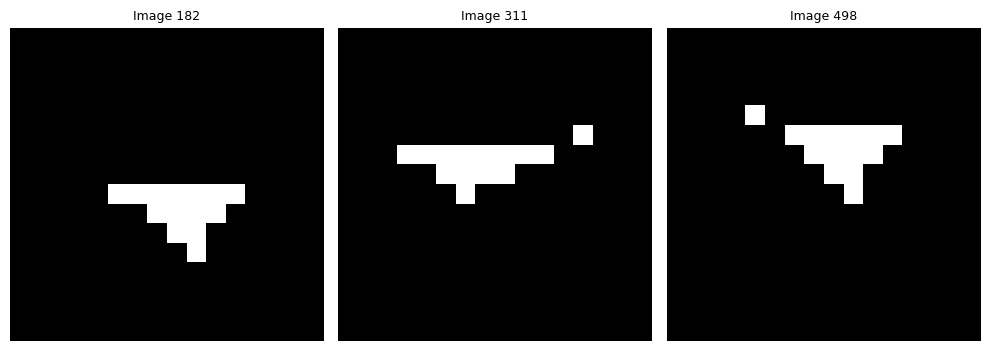


Plotting images in the union set:


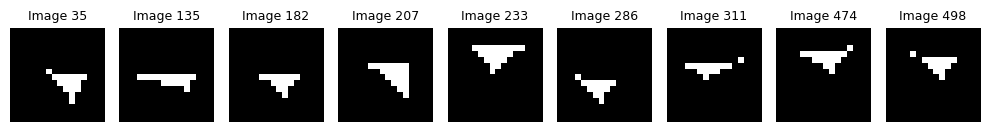


For translationally unique plots: 
Image 35 has no translationally similar images.
Image 135 has no translationally similar images.
Image 182 has no translationally similar images.
Image 207 has no translationally similar images.
Image 233 has no translationally similar images.
Image 286 has no translationally similar images.
Image 311 has no translationally similar images.
Image 474 has no translationally similar images.
Image 498 has no translationally similar images.

Plotting images in the intersection set:


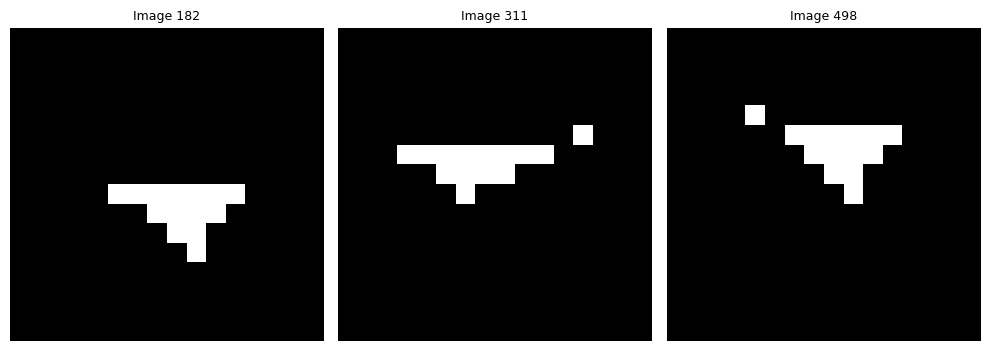


Plotting images in the union set:


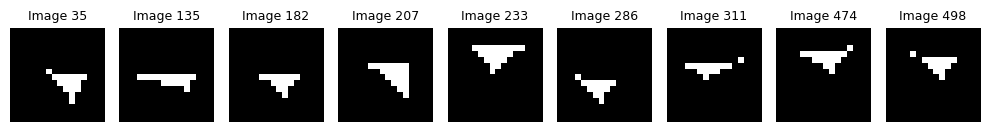

Estimating K-Score for Image 305: K-Score = 0.2
Intersection sets : [ 27 305]
Union sets: [  8  27  49 129 275 289 305 322 411 459]

Comparison between vector c and vector b
 Index  Vector b Value (NCC value)  Vector c Value (Dot product value)
   305                    1.000000                            1.000000
     8                    0.708564                            0.904452
    27                    0.714986                            0.967448
    49                    0.575677                            0.966262
   129                    0.714986                            0.947571
   275                    0.508494                            0.975515
   289                    0.767767                            0.922389
   322                    0.376494                            0.966010
   411                    0.714986                            0.922764
   459                    0.212183                            0.965553

Comparing images in intersection & union set

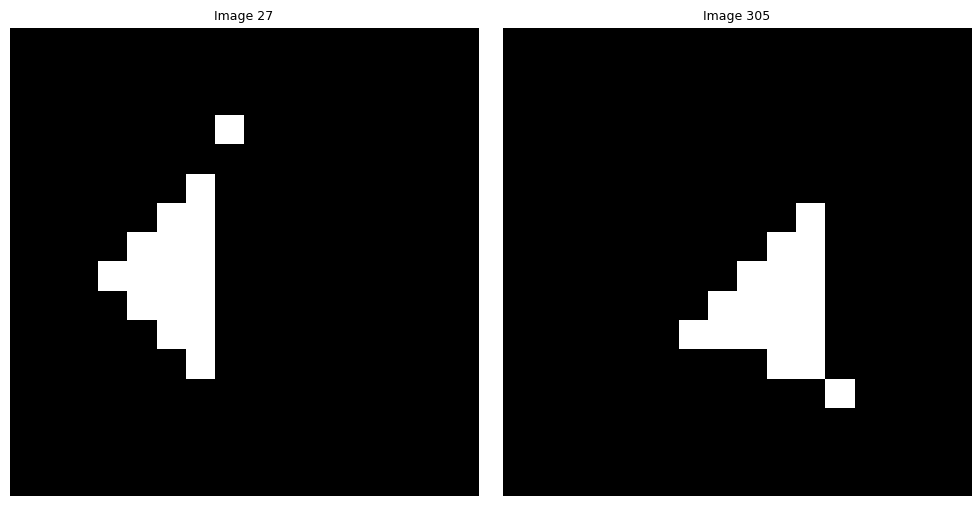


Plotting images in the union set:


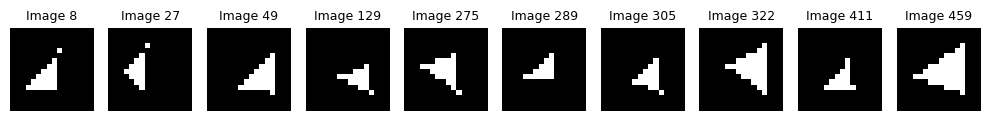


For translationally unique plots: 
Image 8 has no translationally similar images.
Image 27 has no translationally similar images.
Image 49 has no translationally similar images.
Image 129 has no translationally similar images.
Image 275 has no translationally similar images.
Image 289 has no translationally similar images.
Image 305 has no translationally similar images.
Image 322 has no translationally similar images.
Image 411 has no translationally similar images.
Image 459 has no translationally similar images.

Plotting images in the intersection set:


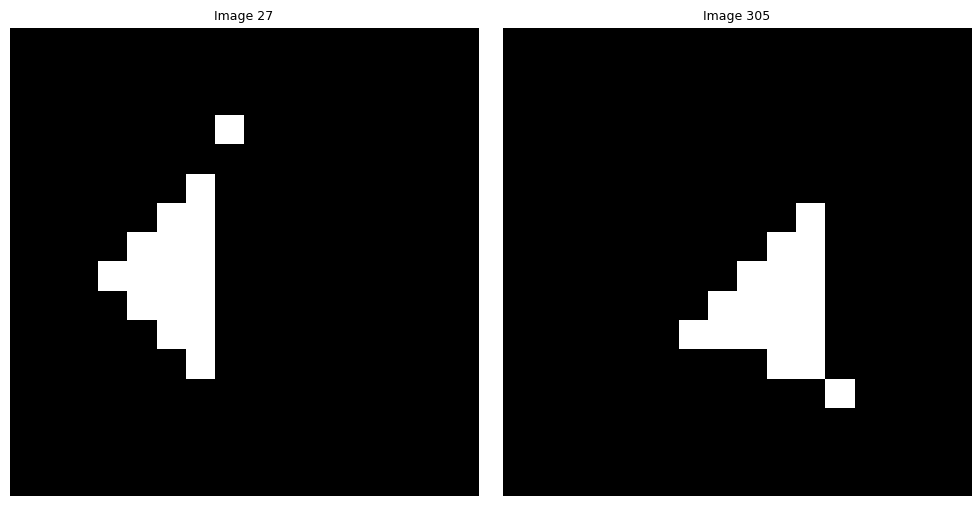


Plotting images in the union set:


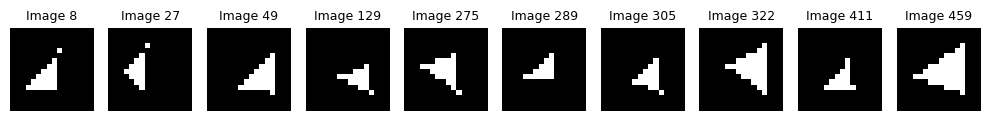

(array([ 27, 305]), [8, 27, 49, 129, 275, 289, 305, 322, 411, 459])

In [6]:
#----------------------Metric 2 - KNNIoU-----------------
print("----------------\nBrute Force Method -- KNN-IOU score\n----------------")
vectorb_bf1 = matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, matrixA)
_, indices = imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, testSample)

top_values_b_1, _ = imgcalc.get_top_scores(vectorb_bf1, vectorc_bf1, indices)
bottom_values_b_1, _ = imgcalc.get_bottom_scores(vectorb_bf1, vectorc_bf1, indices)
    
vectorb_bf2 = matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, testSample)

top_values_b_2, _ = imgcalc.get_top_scores(vectorb_bf2, vectorc_bf2, indices)
bottom_values_b_2, _ = imgcalc.get_bottom_scores(vectorb_bf2, vectorc_bf2, indices)

print("----------------\nModel Method -- KNN-IOU score\n----------------")
vectorb_model1 = matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, testSample)

vectorb_model2 = matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, testSample)


NCC Interval		Average Loss
-0.1-0.0		0.2645 (17037 samples)
-0.2--0.1		0.2606 (21981 samples)
-0.3--0.2		0.2618 (9175 samples)
-0.4--0.3		0.3704 (4880 samples)
-0.5--0.4		0.5008 (3318 samples)
-0.6--0.5		0.3782 (1700 samples)
-0.7--0.6		0.5044 (130 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2980 (31235 samples)
0.1-0.2		0.2965 (19574 samples)
0.2-0.3		0.3026 (15980 samples)
0.3-0.4		0.2570 (9036 samples)
0.4-0.5		0.2573 (6081 samples)
0.5-0.6		0.2223 (3692 samples)
0.6-0.7		0.1907 (1907 samples)
0.7-0.8		0.1851 (956 samples)
0.8-0.9		0.1293 (344 samples)
0.9-1.0		0.0051 (430 samples)


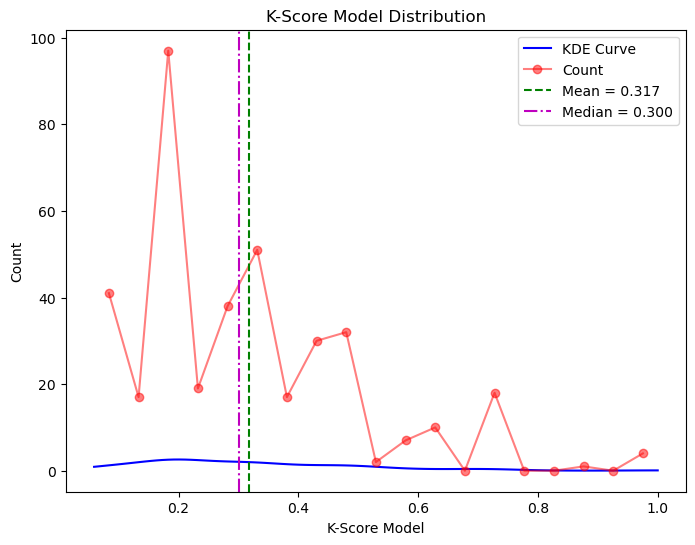

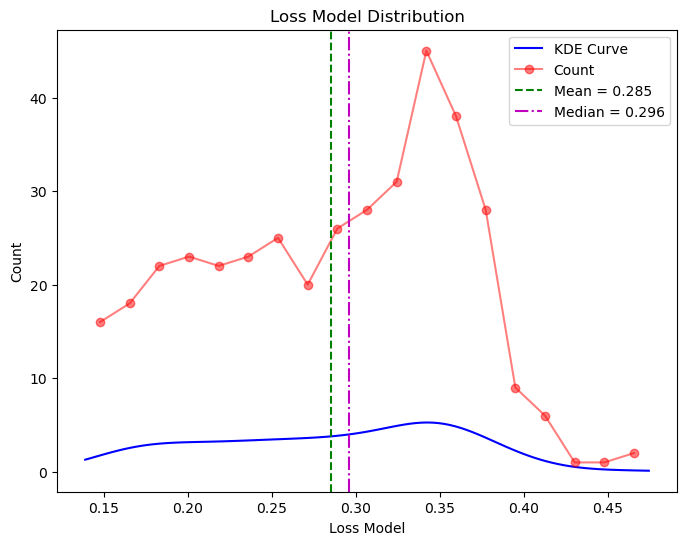


NCC Interval		Average Loss
-0.1-0.0		0.0553 (17037 samples)
-0.2--0.1		0.0673 (21981 samples)
-0.3--0.2		0.0755 (9175 samples)
-0.4--0.3		0.0981 (4880 samples)
-0.5--0.4		0.1843 (3318 samples)
-0.6--0.5		0.2047 (1700 samples)
-0.7--0.6		0.2432 (130 samples)
-0.8--0.7		0.0000 (0 samples)
-0.9--0.8		0.0000 (0 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0580 (31235 samples)
0.1-0.2		0.0623 (19574 samples)
0.2-0.3		0.0646 (15980 samples)
0.3-0.4		0.0732 (9036 samples)
0.4-0.5		0.0676 (6081 samples)
0.5-0.6		0.0709 (3692 samples)
0.6-0.7		0.0685 (1907 samples)
0.7-0.8		0.0690 (956 samples)
0.8-0.9		0.0582 (344 samples)
0.9-1.0		0.0032 (430 samples)


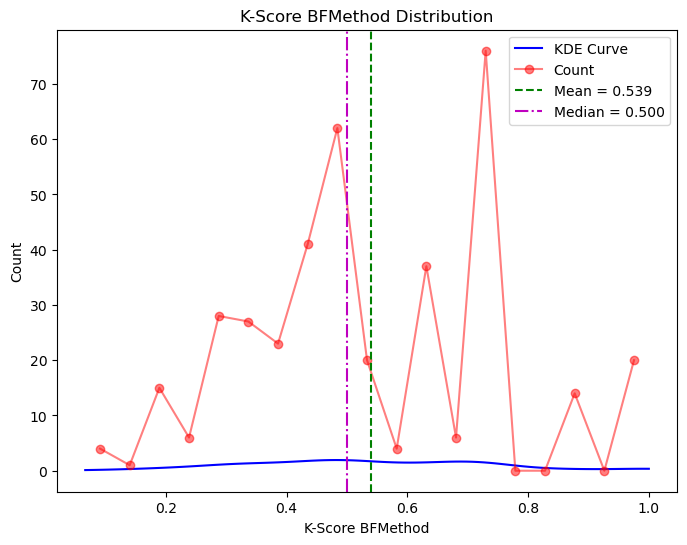

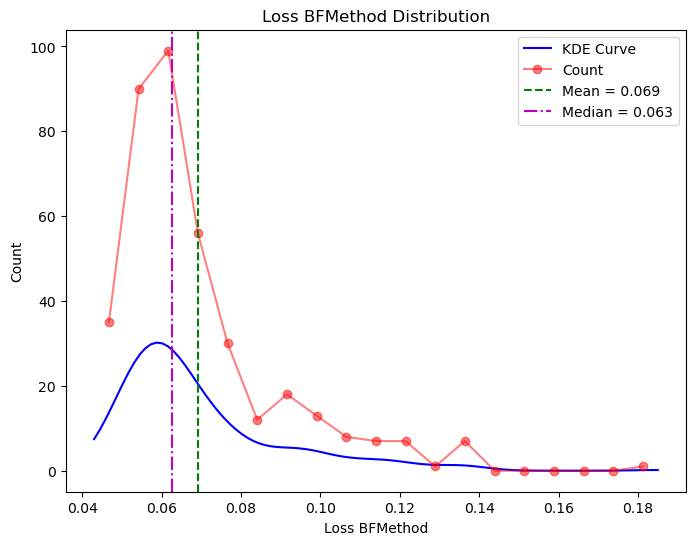

In [6]:
#--------------------Visualisation across dataset using model and Pencorr-------------------
kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_model(testSample, input_dataset, model, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score Model")
imgplt.plot_score_distribution(losses, "Loss Model")

kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)

imgcalc.loss_per_ncc_score(ncc_loss_dict)
imgplt.plot_score_distribution(kscores, "K-Score BFMethod")
imgplt.plot_score_distribution(losses, "Loss BFMethod")

Dimension 5

NCC Interval		Average Loss
-0.1-0.0		0.4906 (33613 samples)
-0.2--0.1		0.4791 (35651 samples)
-0.3--0.2		0.4668 (24739 samples)
-0.4--0.3		0.4724 (20371 samples)
-0.5--0.4		0.5566 (13274 samples)
-0.6--0.5		0.6037 (6599 samples)
-0.7--0.6		0.5398 (3050 samples)
-0.8--0.7		0.5077 (452 samples)
-0.9--0.8		1.6640 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.5281 (36506 samples)
0.1-0.2		0.5512 (29657 samples)
0.2-0.3		0.5177 (21871 samples)
0.3-0.4		0.4619 (10966 samples)
0.4-0.5		0.4039 (6555 samples)
0.5-0.6		0.3425 (3490 samples)
0.6-0.7		0.2664 (1792 samples)
0.7-0.8		0.2198 (664 samples)
0.8-0.9		0.1333 (214 samples)
0.9-1.0		0.0024 (534 samples)


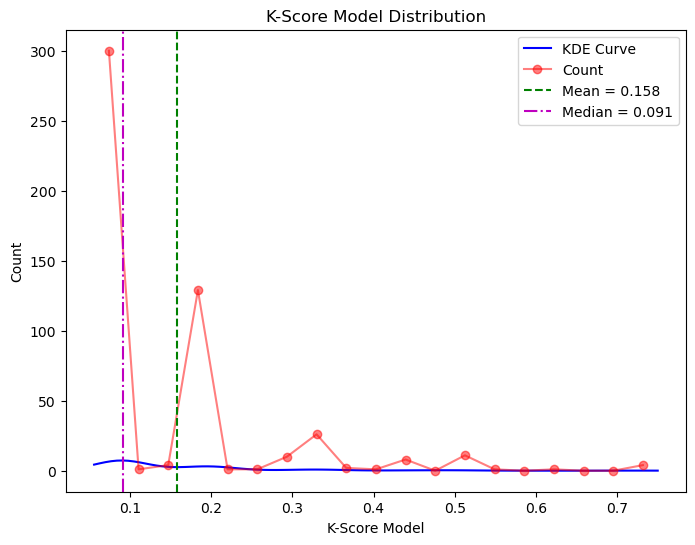

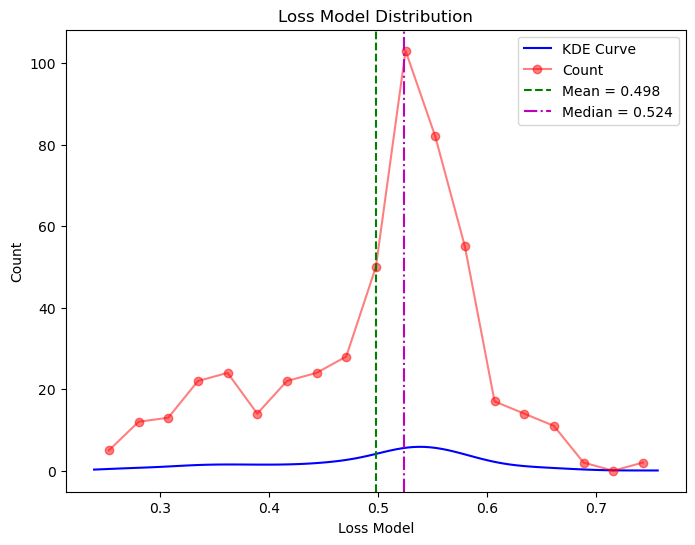


NCC Interval		Average Loss
-0.1-0.0		0.2096 (33613 samples)
-0.2--0.1		0.2219 (35651 samples)
-0.3--0.2		0.2244 (24739 samples)
-0.4--0.3		0.2367 (20371 samples)
-0.5--0.4		0.2651 (13274 samples)
-0.6--0.5		0.2617 (6599 samples)
-0.7--0.6		0.2669 (3050 samples)
-0.8--0.7		0.2296 (452 samples)
-0.9--0.8		0.3179 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.2391 (36506 samples)
0.1-0.2		0.2579 (29657 samples)
0.2-0.3		0.2916 (21871 samples)
0.3-0.4		0.3151 (10966 samples)
0.4-0.5		0.3142 (6555 samples)
0.5-0.6		0.2865 (3490 samples)
0.6-0.7		0.2470 (1792 samples)
0.7-0.8		0.1879 (664 samples)
0.8-0.9		0.1198 (214 samples)
0.9-1.0		0.0035 (534 samples)


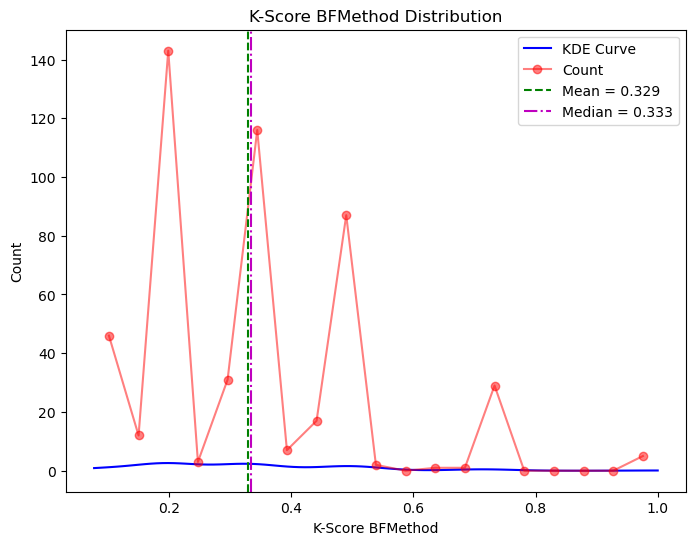

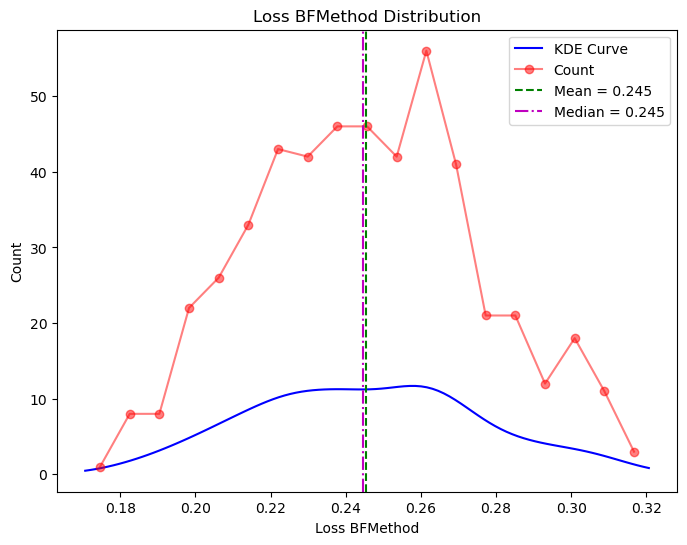

Dimension 10

NCC Interval		Average Loss
-0.1-0.0		0.5072 (33613 samples)
-0.2--0.1		0.4725 (35651 samples)
-0.3--0.2		0.4507 (24739 samples)
-0.4--0.3		0.4465 (20371 samples)
-0.5--0.4		0.5202 (13274 samples)
-0.6--0.5		0.5377 (6599 samples)
-0.7--0.6		0.4552 (3050 samples)
-0.8--0.7		0.5082 (452 samples)
-0.9--0.8		1.1322 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.5375 (36506 samples)
0.1-0.2		0.5457 (29657 samples)
0.2-0.3		0.5198 (21871 samples)
0.3-0.4		0.4622 (10966 samples)
0.4-0.5		0.4071 (6555 samples)
0.5-0.6		0.3385 (3490 samples)
0.6-0.7		0.2638 (1792 samples)
0.7-0.8		0.2060 (664 samples)
0.8-0.9		0.1431 (214 samples)
0.9-1.0		0.0043 (534 samples)


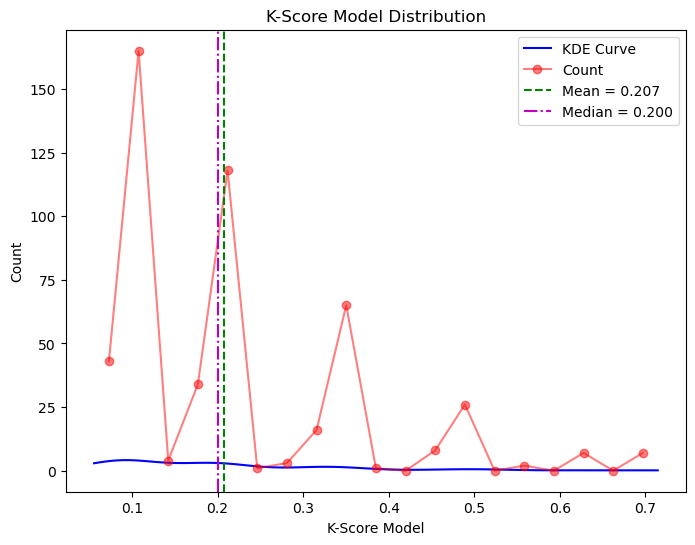

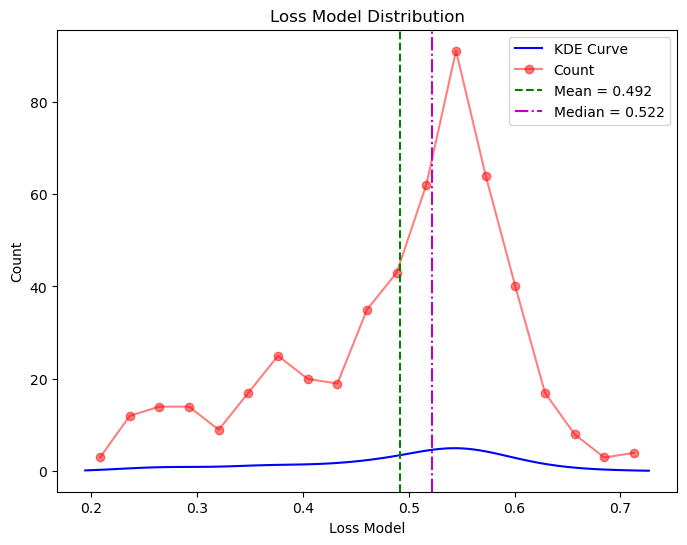


NCC Interval		Average Loss
-0.1-0.0		0.1253 (33613 samples)
-0.2--0.1		0.1309 (35651 samples)
-0.3--0.2		0.1236 (24739 samples)
-0.4--0.3		0.1335 (20371 samples)
-0.5--0.4		0.1814 (13274 samples)
-0.6--0.5		0.2472 (6599 samples)
-0.7--0.6		0.3427 (3050 samples)
-0.8--0.7		0.3737 (452 samples)
-0.9--0.8		0.5197 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.1353 (36506 samples)
0.1-0.2		0.1425 (29657 samples)
0.2-0.3		0.1697 (21871 samples)
0.3-0.4		0.2184 (10966 samples)
0.4-0.5		0.2415 (6555 samples)
0.5-0.6		0.2399 (3490 samples)
0.6-0.7		0.2103 (1792 samples)
0.7-0.8		0.1652 (664 samples)
0.8-0.9		0.1066 (214 samples)
0.9-1.0		0.0030 (534 samples)


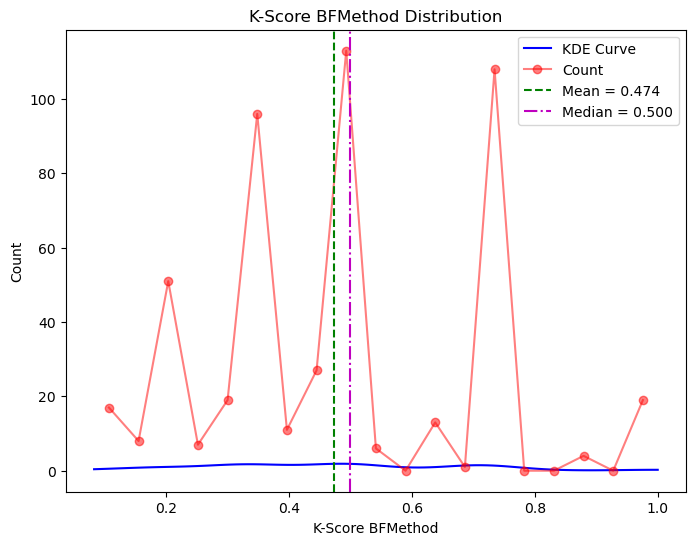

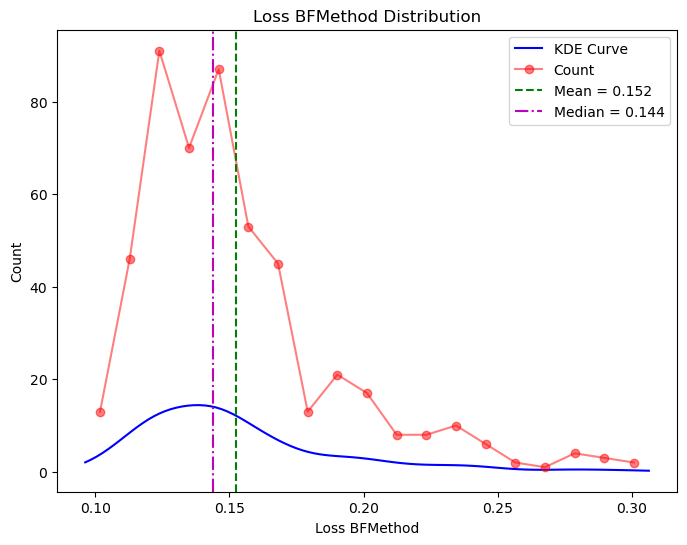

Dimension 20

NCC Interval		Average Loss
-0.1-0.0		0.4259 (33613 samples)
-0.2--0.1		0.4167 (35651 samples)
-0.3--0.2		0.3912 (24739 samples)
-0.4--0.3		0.3962 (20371 samples)
-0.5--0.4		0.4871 (13274 samples)
-0.6--0.5		0.6355 (6599 samples)
-0.7--0.6		0.5975 (3050 samples)
-0.8--0.7		0.4183 (452 samples)
-0.9--0.8		0.8073 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.4645 (36506 samples)
0.1-0.2		0.4887 (29657 samples)
0.2-0.3		0.4646 (21871 samples)
0.3-0.4		0.4215 (10966 samples)
0.4-0.5		0.3654 (6555 samples)
0.5-0.6		0.2993 (3490 samples)
0.6-0.7		0.2323 (1792 samples)
0.7-0.8		0.1857 (664 samples)
0.8-0.9		0.1241 (214 samples)
0.9-1.0		0.0037 (534 samples)


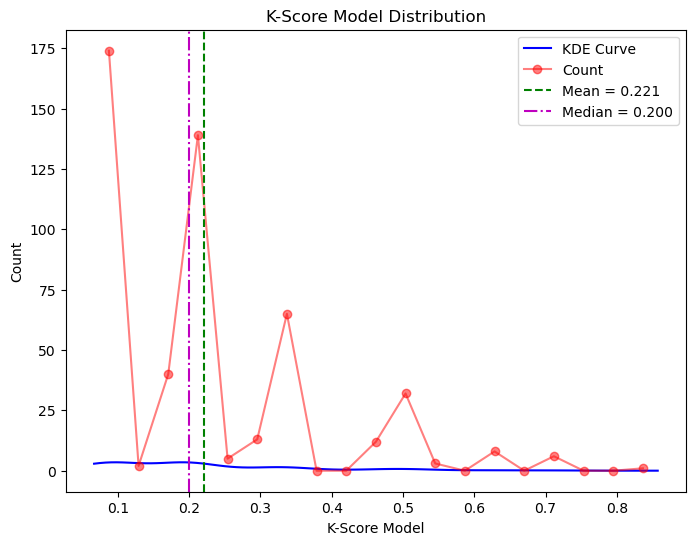

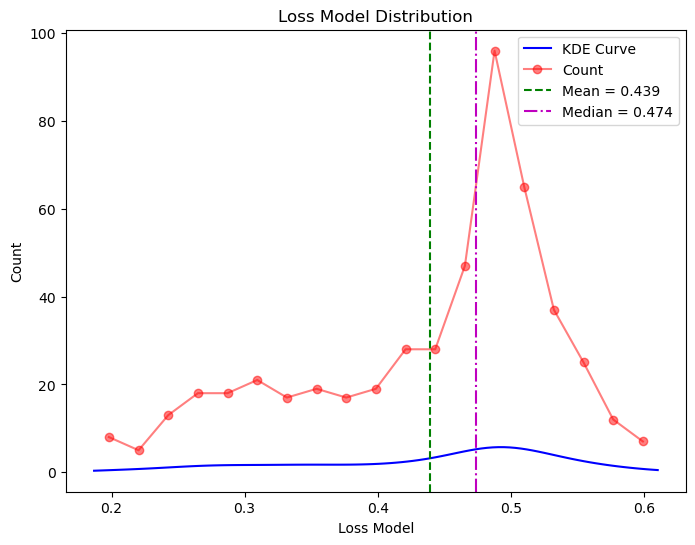


NCC Interval		Average Loss
-0.1-0.0		0.0805 (33613 samples)
-0.2--0.1		0.0985 (35651 samples)
-0.3--0.2		0.1149 (24739 samples)
-0.4--0.3		0.1420 (20371 samples)
-0.5--0.4		0.2078 (13274 samples)
-0.6--0.5		0.2803 (6599 samples)
-0.7--0.6		0.3617 (3050 samples)
-0.8--0.7		0.3977 (452 samples)
-0.9--0.8		0.4966 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0826 (36506 samples)
0.1-0.2		0.0852 (29657 samples)
0.2-0.3		0.0969 (21871 samples)
0.3-0.4		0.1272 (10966 samples)
0.4-0.5		0.1510 (6555 samples)
0.5-0.6		0.1633 (3490 samples)
0.6-0.7		0.1551 (1792 samples)
0.7-0.8		0.1275 (664 samples)
0.8-0.9		0.0869 (214 samples)
0.9-1.0		0.0024 (534 samples)


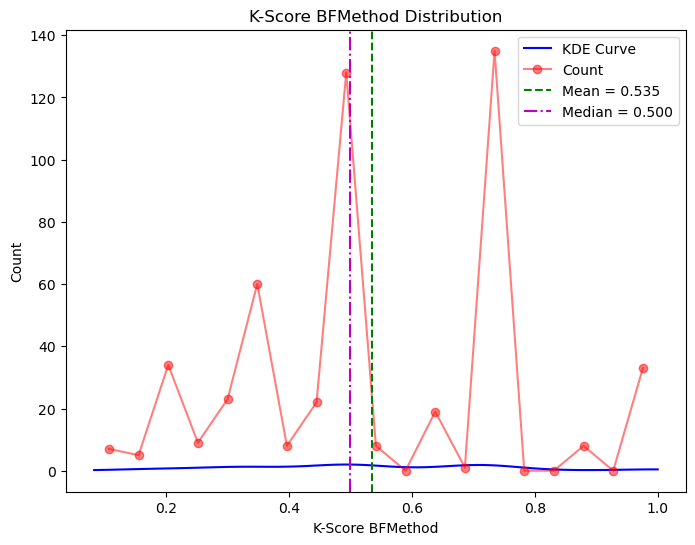

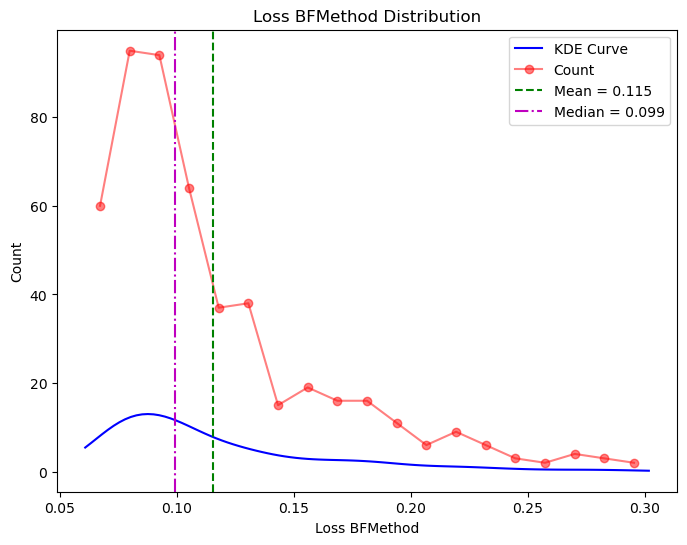

Dimension 30

NCC Interval		Average Loss
-0.1-0.0		0.5005 (33613 samples)
-0.2--0.1		0.4577 (35651 samples)
-0.3--0.2		0.4330 (24739 samples)
-0.4--0.3		0.4180 (20371 samples)
-0.5--0.4		0.4926 (13274 samples)
-0.6--0.5		0.4654 (6599 samples)
-0.7--0.6		0.3946 (3050 samples)
-0.8--0.7		0.4948 (452 samples)
-0.9--0.8		1.1198 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.5367 (36506 samples)
0.1-0.2		0.5542 (29657 samples)
0.2-0.3		0.5245 (21871 samples)
0.3-0.4		0.4574 (10966 samples)
0.4-0.5		0.3996 (6555 samples)
0.5-0.6		0.3357 (3490 samples)
0.6-0.7		0.2581 (1792 samples)
0.7-0.8		0.1918 (664 samples)
0.8-0.9		0.1355 (214 samples)
0.9-1.0		0.0030 (534 samples)


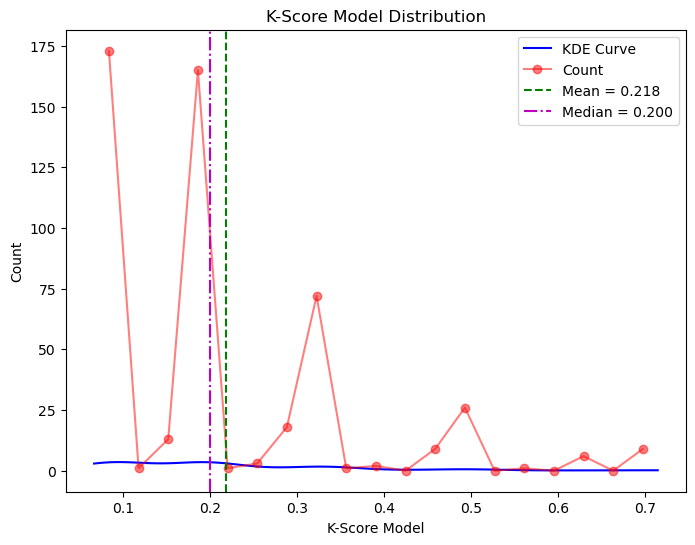

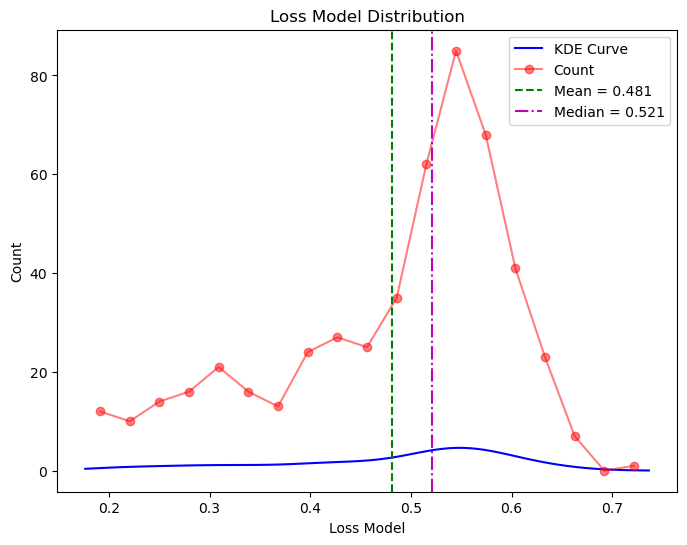


NCC Interval		Average Loss
-0.1-0.0		0.0712 (33613 samples)
-0.2--0.1		0.0942 (35651 samples)
-0.3--0.2		0.1157 (24739 samples)
-0.4--0.3		0.1464 (20371 samples)
-0.5--0.4		0.2179 (13274 samples)
-0.6--0.5		0.2923 (6599 samples)
-0.7--0.6		0.3737 (3050 samples)
-0.8--0.7		0.4124 (452 samples)
-0.9--0.8		0.5010 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0675 (36506 samples)
0.1-0.2		0.0662 (29657 samples)
0.2-0.3		0.0717 (21871 samples)
0.3-0.4		0.0869 (10966 samples)
0.4-0.5		0.1028 (6555 samples)
0.5-0.6		0.1187 (3490 samples)
0.6-0.7		0.1183 (1792 samples)
0.7-0.8		0.1011 (664 samples)
0.8-0.9		0.0722 (214 samples)
0.9-1.0		0.0021 (534 samples)


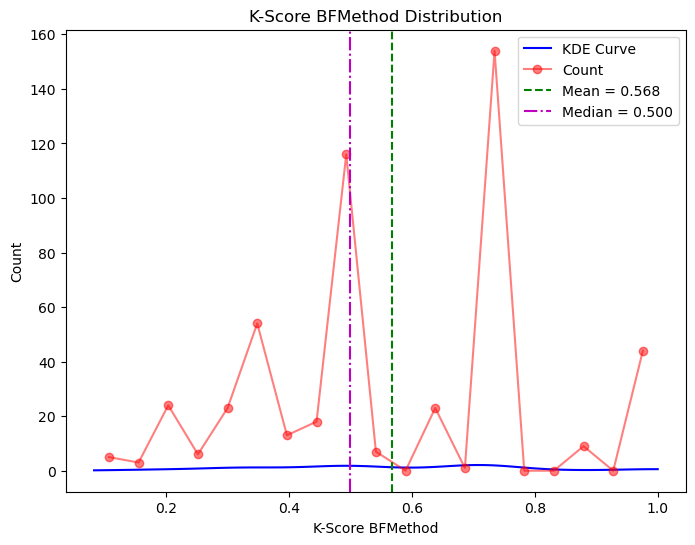

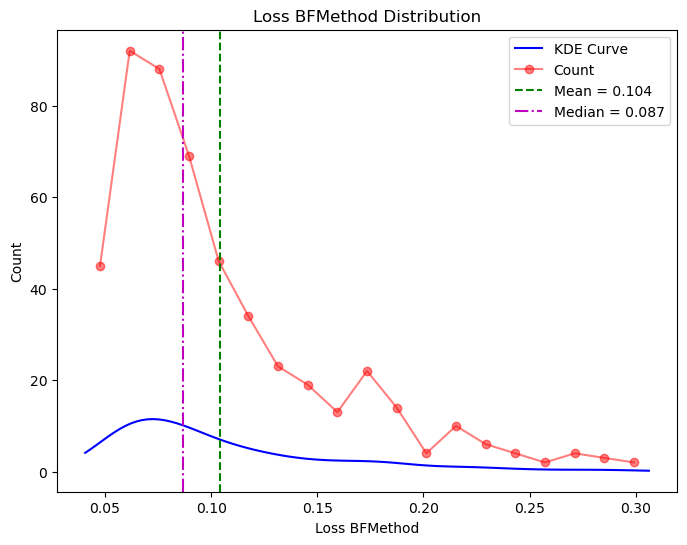

Dimension 40

NCC Interval		Average Loss
-0.1-0.0		0.5563 (33613 samples)
-0.2--0.1		0.5255 (35651 samples)
-0.3--0.2		0.5035 (24739 samples)
-0.4--0.3		0.4994 (20371 samples)
-0.5--0.4		0.5654 (13274 samples)
-0.6--0.5		0.6185 (6599 samples)
-0.7--0.6		0.4883 (3050 samples)
-0.8--0.7		0.4500 (452 samples)
-0.9--0.8		1.4532 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.5931 (36506 samples)
0.1-0.2		0.5945 (29657 samples)
0.2-0.3		0.5678 (21871 samples)
0.3-0.4		0.4967 (10966 samples)
0.4-0.5		0.4366 (6555 samples)
0.5-0.6		0.3595 (3490 samples)
0.6-0.7		0.2832 (1792 samples)
0.7-0.8		0.2084 (664 samples)
0.8-0.9		0.1216 (214 samples)
0.9-1.0		0.0030 (534 samples)


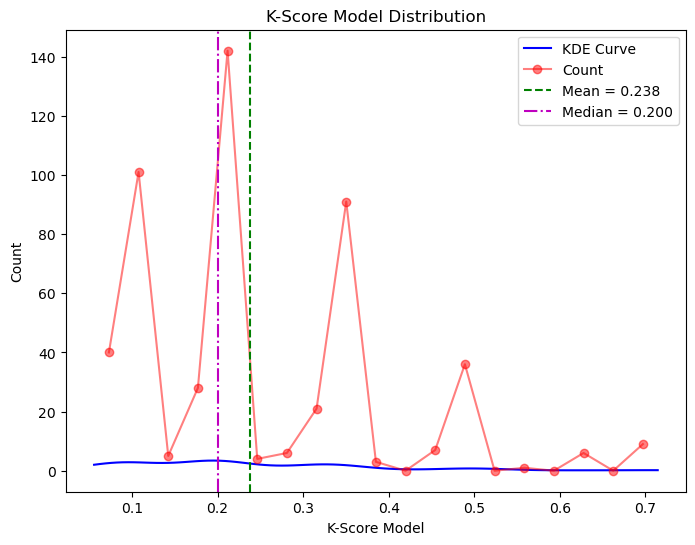

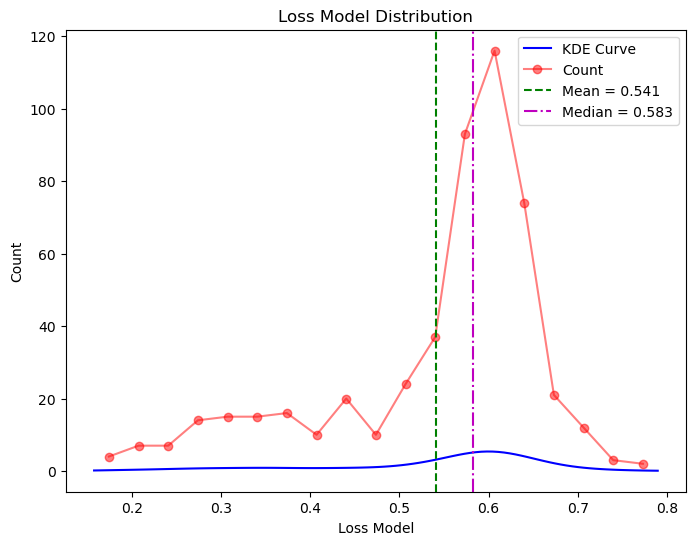


NCC Interval		Average Loss
-0.1-0.0		0.0679 (33613 samples)
-0.2--0.1		0.0931 (35651 samples)
-0.3--0.2		0.1171 (24739 samples)
-0.4--0.3		0.1501 (20371 samples)
-0.5--0.4		0.2224 (13274 samples)
-0.6--0.5		0.2989 (6599 samples)
-0.7--0.6		0.3819 (3050 samples)
-0.8--0.7		0.4167 (452 samples)
-0.9--0.8		0.5168 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0611 (36506 samples)
0.1-0.2		0.0573 (29657 samples)
0.2-0.3		0.0597 (21871 samples)
0.3-0.4		0.0682 (10966 samples)
0.4-0.5		0.0792 (6555 samples)
0.5-0.6		0.0912 (3490 samples)
0.6-0.7		0.0926 (1792 samples)
0.7-0.8		0.0820 (664 samples)
0.8-0.9		0.0604 (214 samples)
0.9-1.0		0.0020 (534 samples)


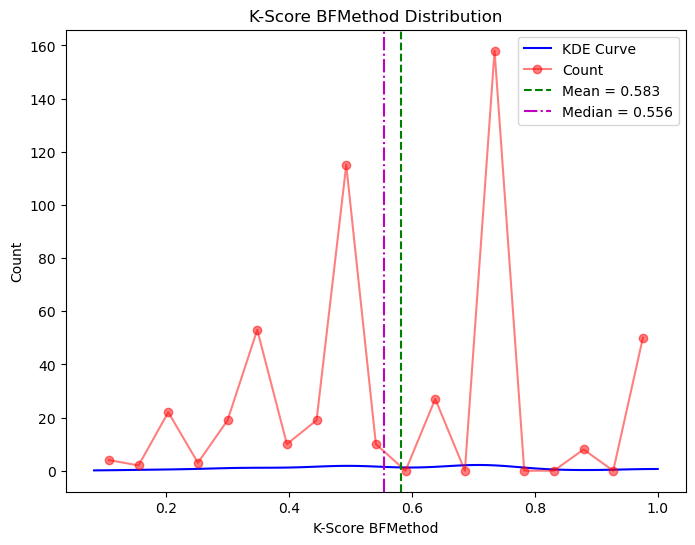

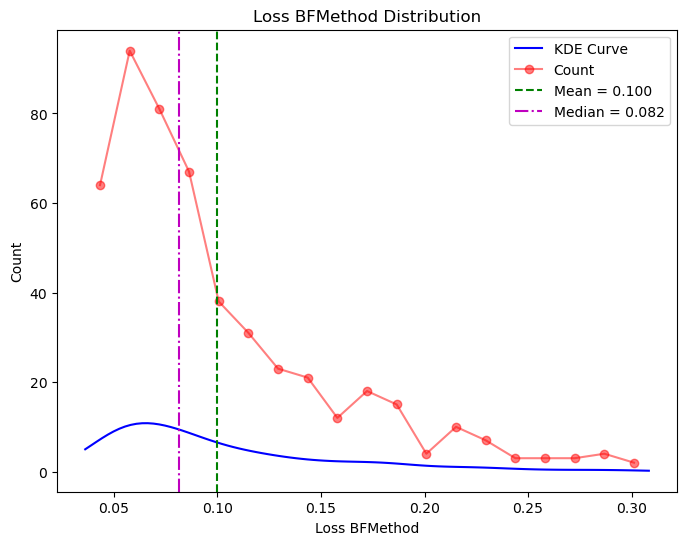

Dimension 64


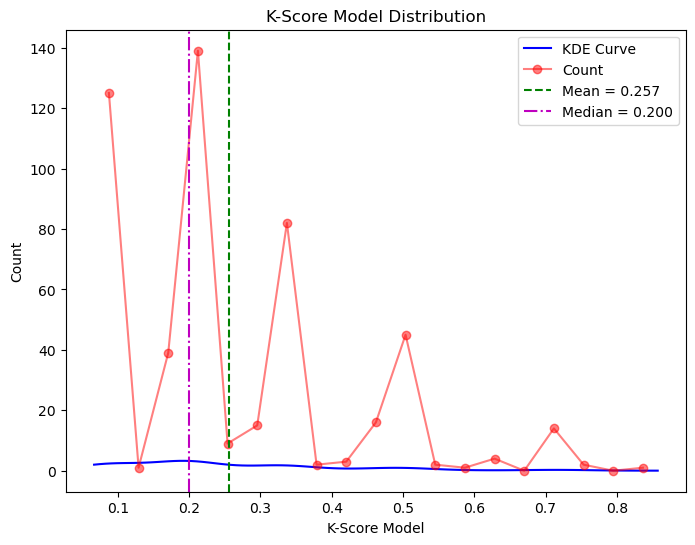

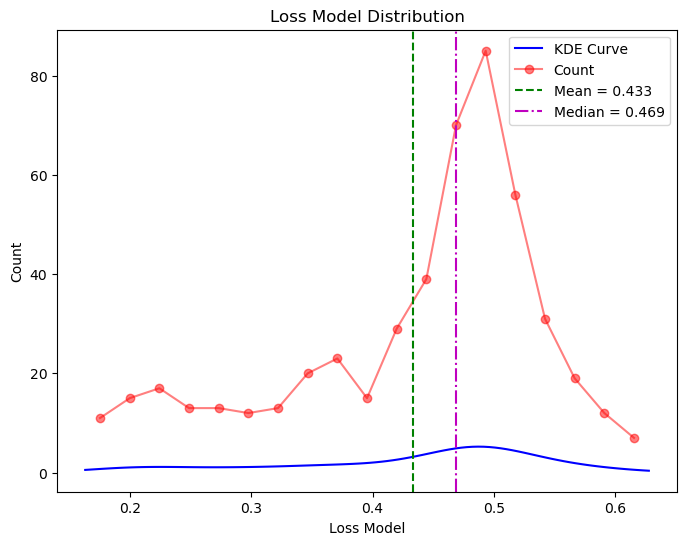


NCC Interval		Average Loss
-0.1-0.0		0.0647 (33613 samples)
-0.2--0.1		0.0927 (35651 samples)
-0.3--0.2		0.1195 (24739 samples)
-0.4--0.3		0.1538 (20371 samples)
-0.5--0.4		0.2272 (13274 samples)
-0.6--0.5		0.3065 (6599 samples)
-0.7--0.6		0.3908 (3050 samples)
-0.8--0.7		0.4208 (452 samples)
-0.9--0.8		0.5158 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0552 (36506 samples)
0.1-0.2		0.0487 (29657 samples)
0.2-0.3		0.0478 (21871 samples)
0.3-0.4		0.0513 (10966 samples)
0.4-0.5		0.0559 (6555 samples)
0.5-0.6		0.0601 (3490 samples)
0.6-0.7		0.0619 (1792 samples)
0.7-0.8		0.0578 (664 samples)
0.8-0.9		0.0485 (214 samples)
0.9-1.0		0.0016 (534 samples)


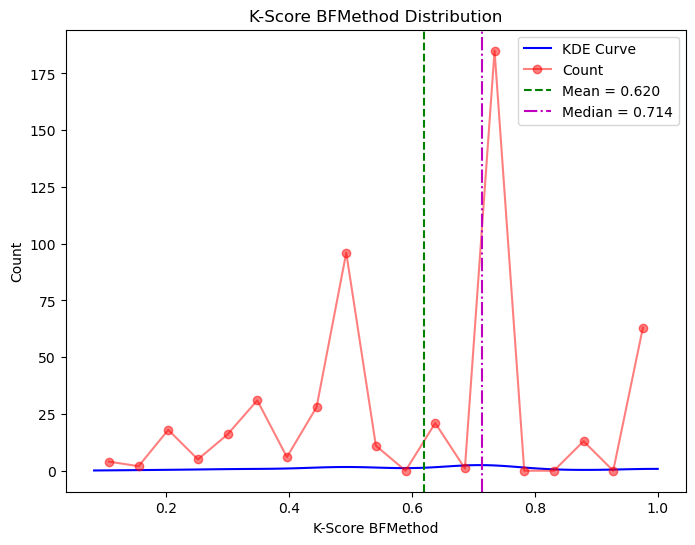

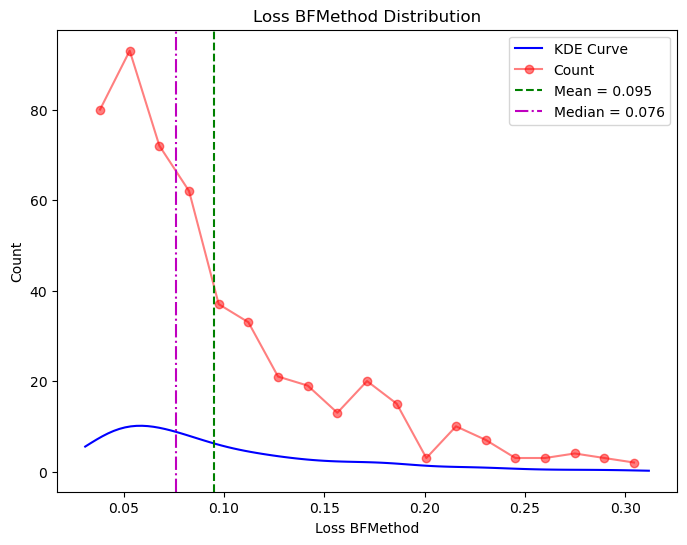

Dimension 128

NCC Interval		Average Loss
-0.1-0.0		0.4984 (33613 samples)
-0.2--0.1		0.4597 (35651 samples)
-0.3--0.2		0.4415 (24739 samples)
-0.4--0.3		0.4339 (20371 samples)
-0.5--0.4		0.5065 (13274 samples)
-0.6--0.5		0.5180 (6599 samples)
-0.7--0.6		0.4185 (3050 samples)
-0.8--0.7		0.4599 (452 samples)
-0.9--0.8		1.2300 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.5325 (36506 samples)
0.1-0.2		0.5466 (29657 samples)
0.2-0.3		0.5215 (21871 samples)
0.3-0.4		0.4590 (10966 samples)
0.4-0.5		0.4027 (6555 samples)
0.5-0.6		0.3358 (3490 samples)
0.6-0.7		0.2667 (1792 samples)
0.7-0.8		0.1987 (664 samples)
0.8-0.9		0.1633 (214 samples)
0.9-1.0		0.0034 (534 samples)


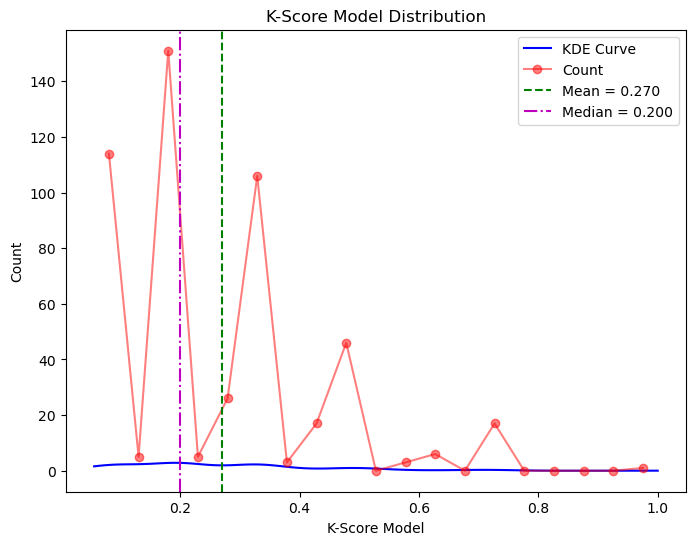

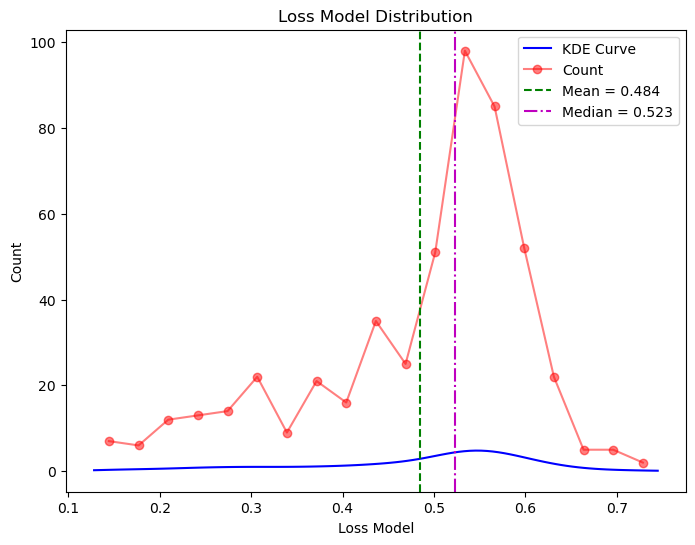


NCC Interval		Average Loss
-0.1-0.0		0.0637 (33613 samples)
-0.2--0.1		0.0932 (35651 samples)
-0.3--0.2		0.1212 (24739 samples)
-0.4--0.3		0.1563 (20371 samples)
-0.5--0.4		0.2300 (13274 samples)
-0.6--0.5		0.3103 (6599 samples)
-0.7--0.6		0.3953 (3050 samples)
-0.8--0.7		0.4235 (452 samples)
-0.9--0.8		0.5137 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0528 (36506 samples)
0.1-0.2		0.0449 (29657 samples)
0.2-0.3		0.0426 (21871 samples)
0.3-0.4		0.0437 (10966 samples)
0.4-0.5		0.0445 (6555 samples)
0.5-0.6		0.0449 (3490 samples)
0.6-0.7		0.0445 (1792 samples)
0.7-0.8		0.0422 (664 samples)
0.8-0.9		0.0418 (214 samples)
0.9-1.0		0.0015 (534 samples)


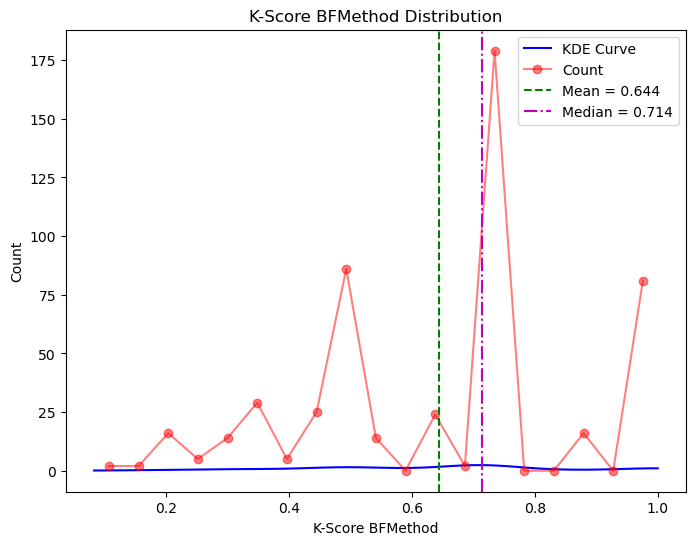

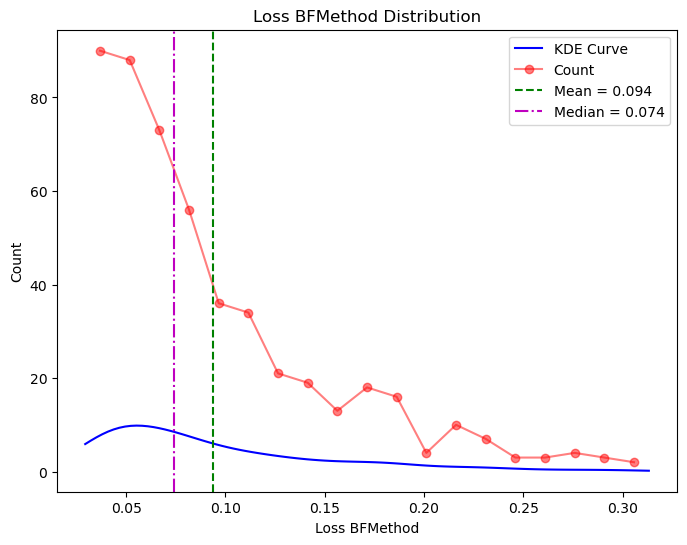

Dimension 256

NCC Interval		Average Loss
-0.1-0.0		0.4020 (33613 samples)
-0.2--0.1		0.3884 (35651 samples)
-0.3--0.2		0.3715 (24739 samples)
-0.4--0.3		0.3825 (20371 samples)
-0.5--0.4		0.4755 (13274 samples)
-0.6--0.5		0.6152 (6599 samples)
-0.7--0.6		0.6038 (3050 samples)
-0.8--0.7		0.4581 (452 samples)
-0.9--0.8		1.0215 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.4360 (36506 samples)
0.1-0.2		0.4610 (29657 samples)
0.2-0.3		0.4427 (21871 samples)
0.3-0.4		0.3997 (10966 samples)
0.4-0.5		0.3481 (6555 samples)
0.5-0.6		0.2896 (3490 samples)
0.6-0.7		0.2219 (1792 samples)
0.7-0.8		0.1925 (664 samples)
0.8-0.9		0.1338 (214 samples)
0.9-1.0		0.0037 (534 samples)


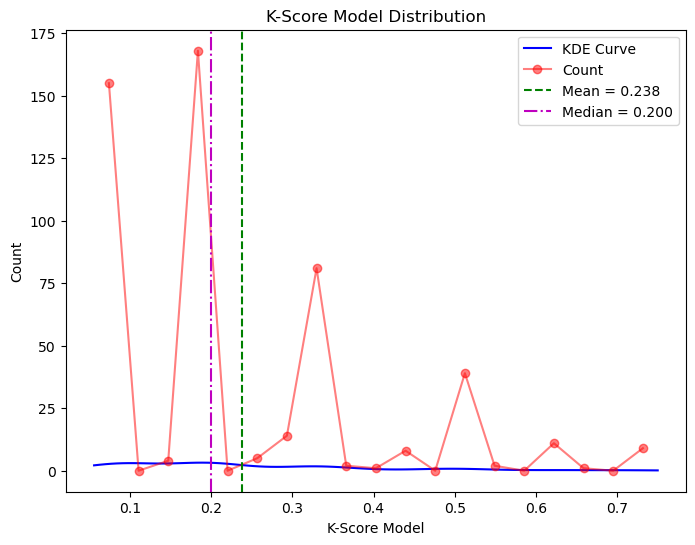

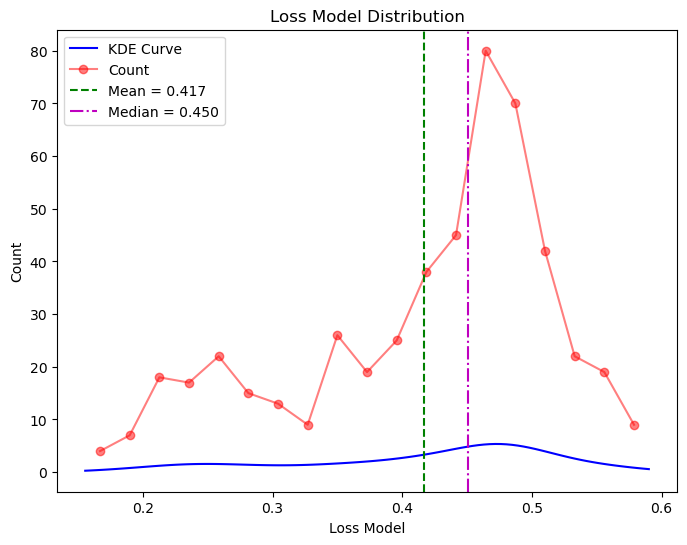


NCC Interval		Average Loss
-0.1-0.0		0.0637 (33613 samples)
-0.2--0.1		0.0932 (35651 samples)
-0.3--0.2		0.1213 (24739 samples)
-0.4--0.3		0.1564 (20371 samples)
-0.5--0.4		0.2301 (13274 samples)
-0.6--0.5		0.3105 (6599 samples)
-0.7--0.6		0.3955 (3050 samples)
-0.8--0.7		0.4236 (452 samples)
-0.9--0.8		0.5136 (2 samples)
-1.0--0.9		0.0000 (0 samples)
0.0-0.1		0.0527 (36506 samples)
0.1-0.2		0.0448 (29657 samples)
0.2-0.3		0.0425 (21871 samples)
0.3-0.4		0.0435 (10966 samples)
0.4-0.5		0.0442 (6555 samples)
0.5-0.6		0.0445 (3490 samples)
0.6-0.7		0.0438 (1792 samples)
0.7-0.8		0.0417 (664 samples)
0.8-0.9		0.0415 (214 samples)
0.9-1.0		0.0015 (534 samples)


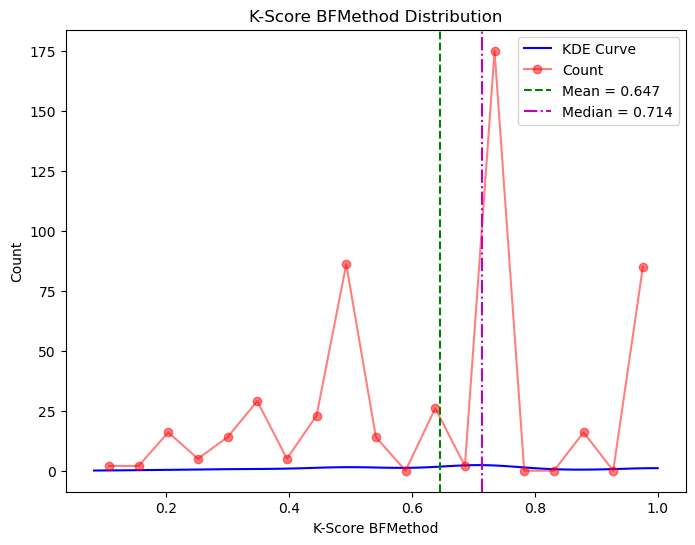

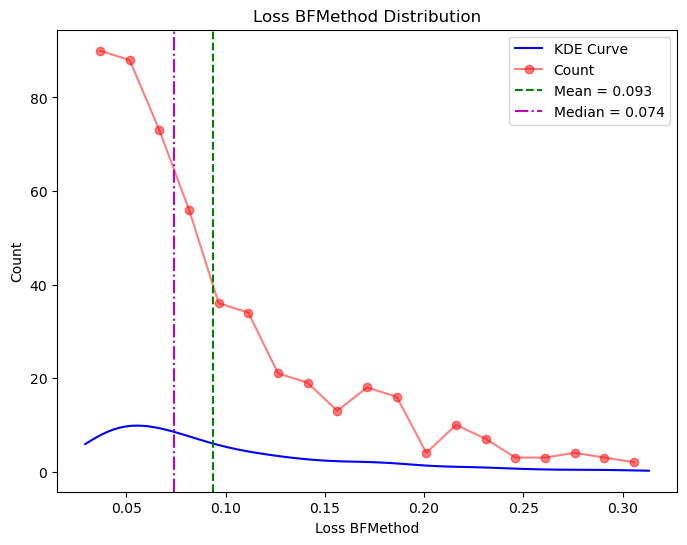

[0.1578048951048951, 0.2073170218670219, 0.22121140248640248, 0.21823954542189836, 0.2376372016872017, 0.25650275280275275, 0.2696780164280165, 0.23772987567987566]
[0.4980017012260705, 0.49177768351142104, 0.4393317409228534, 0.4813449116420448, 0.5411393422961532, 0.43339286904174834, 0.48430450134335457, 0.4170625236705579]


In [18]:
#--------------------Visualisation across dataset across dimensions-------------------
dimensions = [5, 10, 20, 30, 40, 64, 128, 256]
mean = []
k_score = []
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:
    print(f"Dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN1(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer0.pt'), weights_only=True))

    model.eval()

    kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_model(testSample, input_dataset, model, k)

    imgcalc.loss_per_ncc_score(ncc_loss_dict)
    imgplt.plot_score_distribution(kscores, "K-Score Model")
    imgplt.plot_score_distribution(losses, "Loss Model")
    mean.append(np.mean(losses))
    k_score.append(np.mean(kscores))
    if dim <= len(testSample):
        matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
        kscores, losses, ncc_loss_dict = imgcalc.kscore_loss_evaluation_brute(testSample, matrixA, matrixG, k)

        imgcalc.loss_per_ncc_score(ncc_loss_dict)
        imgplt.plot_score_distribution(kscores, "K-Score BFMethod")
        imgplt.plot_score_distribution(losses, "Loss BFMethod")
        
print(k_score)
print(mean)

In [7]:
# -----------------------------Before transforming output embedding matrices-----------------------------
# ----------- Preprocessing dataset -------------
dim = 64
embeddingType = f"pencorr_{dim}"

model = models.SimpleCNN1(dimensions=dim, padding_mode='circular').to(device)
model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                 f'best_model_{imageType}_{dim}d_convlayer0.pt'), weights_only=True))

model.eval()

model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_matrix = imgcalc.get_matrix_embeddings(input_dataset, model_vectors)

matrixG = imgcalc.get_matrixG(testSample, imageProductType)
matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
dot_product_matrix = np.dot(matrixA.T, matrixA)

######################################################
mean_squared_difference = imgcalc.get_MSE(matrixG, dot_product_matrix)
print("Mean Squared Difference of Pencorr (A'A) and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
    
print(f"\nPrinting matrices")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix.detach().cpu().numpy()}, {model_matrix.detach().cpu().numpy().shape}")

print(f"\nPrinting vectors")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_vectors[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Model: {mean_squared_difference}")

Mean Squared Difference of Pencorr (A'A) and NCC (G): 0.019559888848853454

Mean Squared Difference of Model and NCC (G): 0.2550714934057726
Mean Squared Difference of Model and Pencorr (A'A): 0.22794010512045207

Printing matrices

Matrix G: [[ 1.         -0.29289317 -0.10557294 ... -0.38762754 -0.24407101
  -0.41165161]
 [-0.29289317  1.          0.05409241 ... -0.03774959 -0.10912925
   0.10940039]
 [-0.10557294  0.05409241  1.         ...  0.09544504  0.18321586
   0.40329266]
 ...
 [-0.38762754 -0.03774959  0.09544504 ...  1.          0.23442674
  -0.03923106]
 [-0.24407101 -0.10912925  0.18321586 ...  0.23442674  1.
   0.18599892]
 [-0.41165161  0.10940039  0.40329266 ... -0.03923106  0.18599892
   1.        ]]

Matrix A'A (Pencorr): [[ 1.         -0.11781968 -0.09724687 ... -0.23231108 -0.22010353
  -0.33570985]
 [-0.11781968  1.          0.09556116 ...  0.02690089 -0.09007728
   0.12815663]
 [-0.09724687  0.09556116  1.         ...  0.02790905  0.15216807
   0.33502598]
 ...
 [

For dimension 5
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.6915, -0.4792,  0.3306, -0.1283, -0.4080]], device='cuda:0',
       grad_fn=<DivBackward0>)
Embedding of similar image 182 for Model: tensor([[-0.6915, -0.4792,  0.3306, -0.1283, -0.4080]], device='cuda:0',
       grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.7433385  -0.0671092  -0.36826761 -0.48726466 -0.26437918]

Embedding of similar image 182 for Pencorr (A'A): [ 0.7433385  -0.0671092  -0.36826761 -0.48726466 -0.26437918]

Differences between vector embeddings
Mean Squared Difference of Model between 2 similar images: 0.0
Mean Squared Difference of Pencorr (A'A) between 2 similar images: 0.0
286

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.6915, -0.4792,  0.3306, -0.1283, -0.4080]], device='cuda:0',
       grad_fn=<DivBackward0>)
Embedding of similar image 286 for Model: tensor([[-0.3614, -0.6739,  0.3378,  0.1700, -0.5218]], d

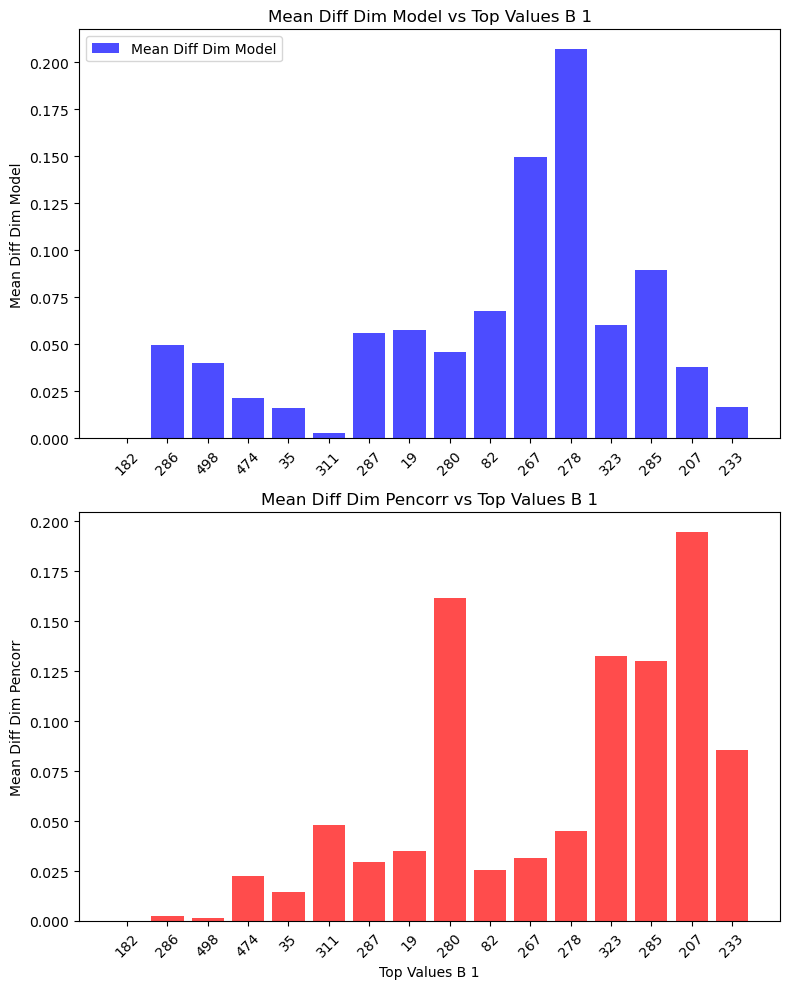

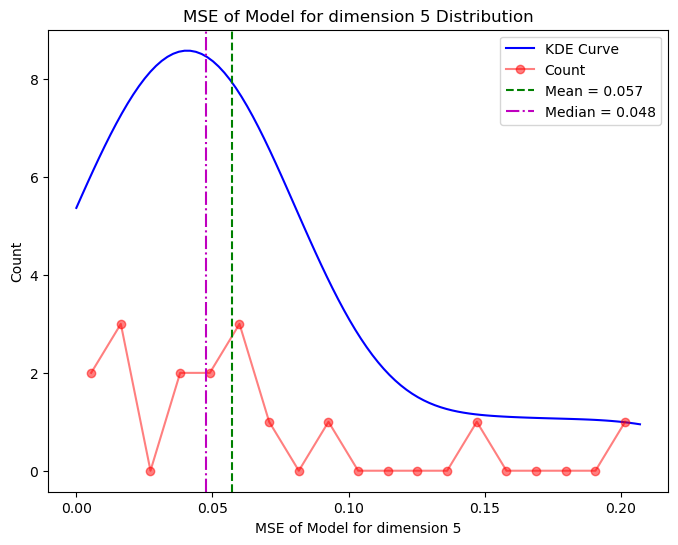

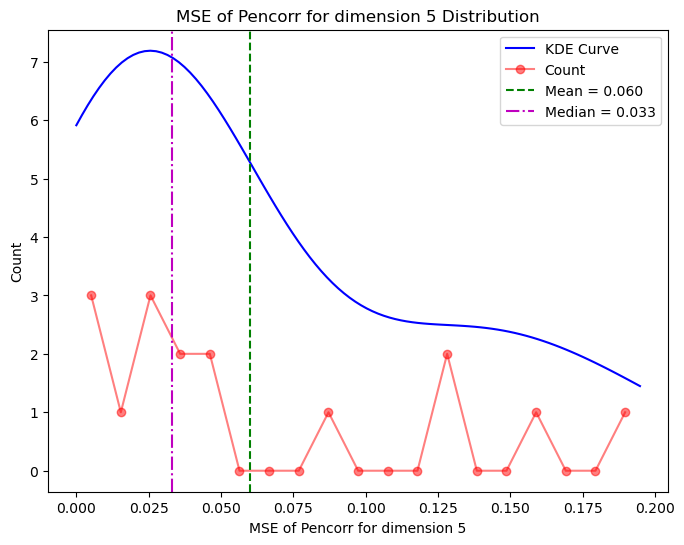

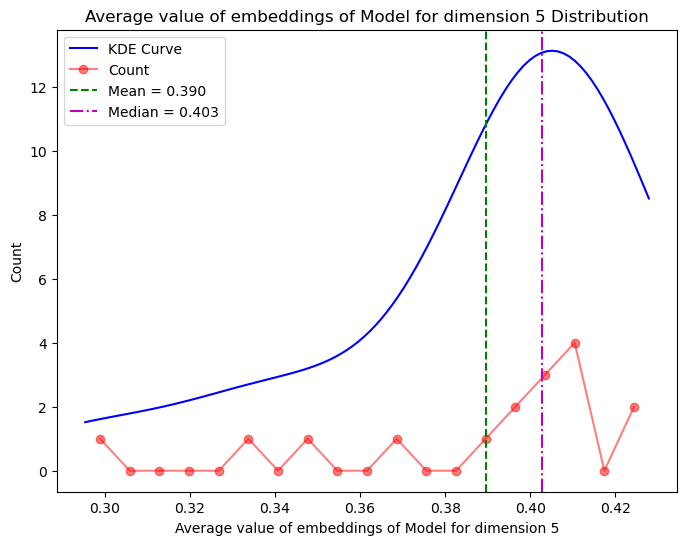

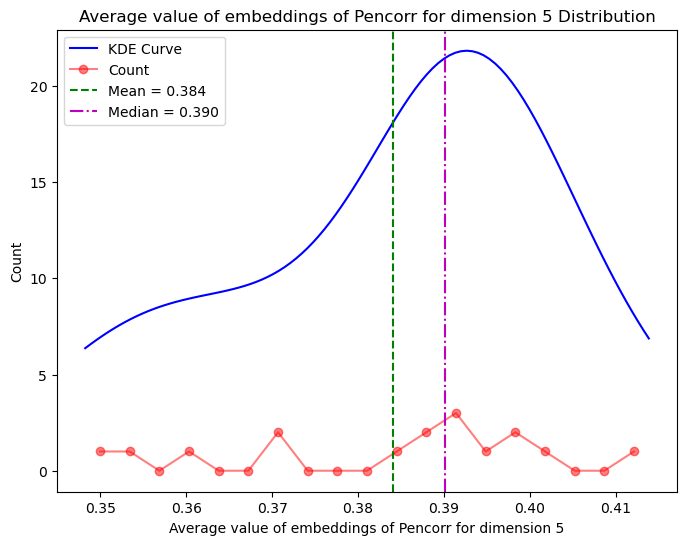

For dimension 10
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.3692,  0.1814, -0.4594,  0.4338,  0.4430, -0.1532, -0.0936, -0.3595,
         -0.2532, -0.0986]], device='cuda:0', grad_fn=<DivBackward0>)
Embedding of similar image 182 for Model: tensor([[-0.3692,  0.1814, -0.4594,  0.4338,  0.4430, -0.1532, -0.0936, -0.3595,
         -0.2532, -0.0986]], device='cuda:0', grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.60080415 -0.07925919 -0.28067082 -0.33481871  0.21281156  0.5655596
  0.12760043 -0.21160117 -0.04916499  0.11511793]

Embedding of similar image 182 for Pencorr (A'A): [ 0.60080415 -0.07925919 -0.28067082 -0.33481871  0.21281156  0.5655596
  0.12760043 -0.21160117 -0.04916499  0.11511793]

Differences between vector embeddings
Mean Squared Difference of Model between 2 similar images: 0.0
Mean Squared Difference of Pencorr (A'A) between 2 similar images: 0.0
286

Printing vectors for index 182
Embedding of image 182

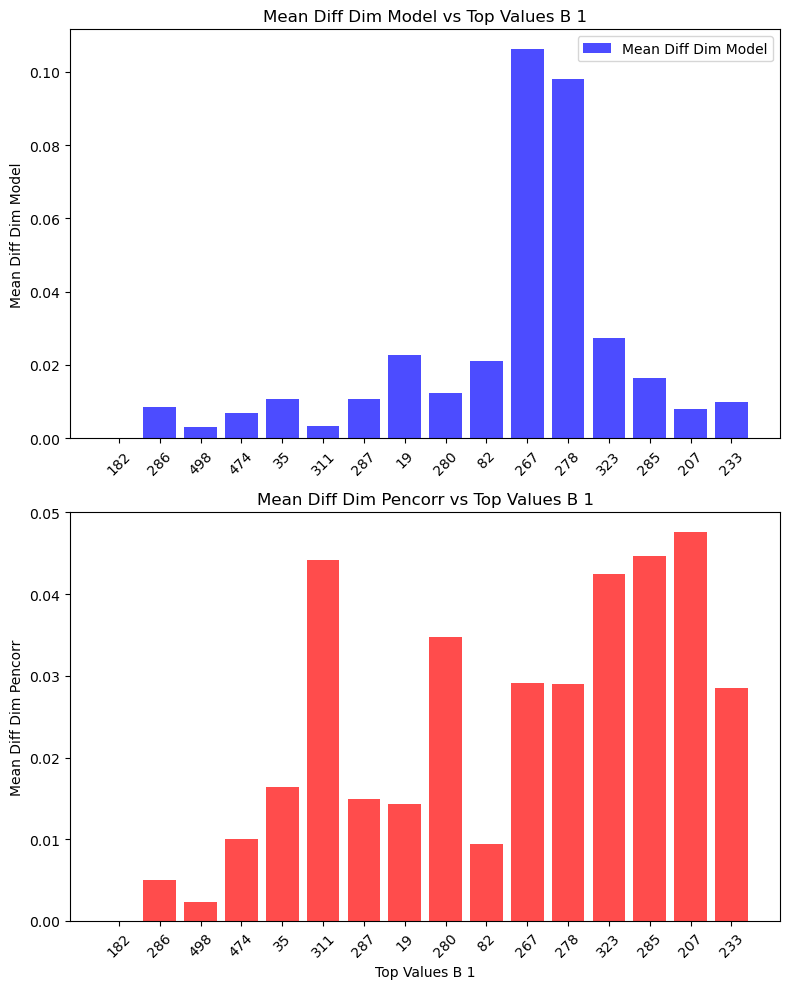

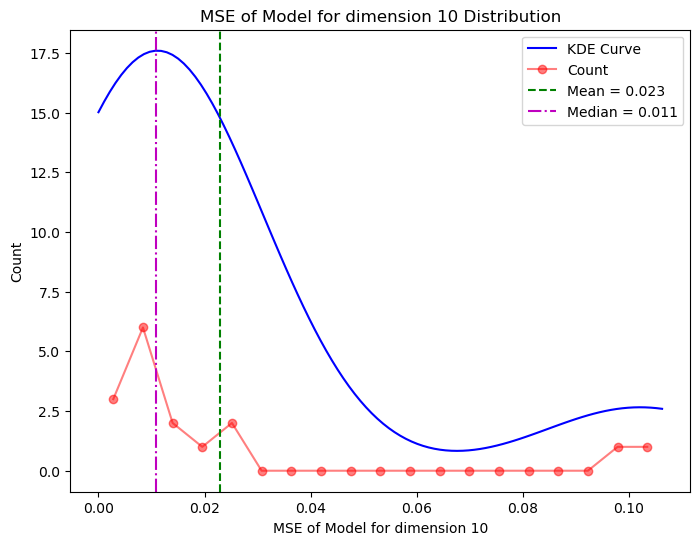

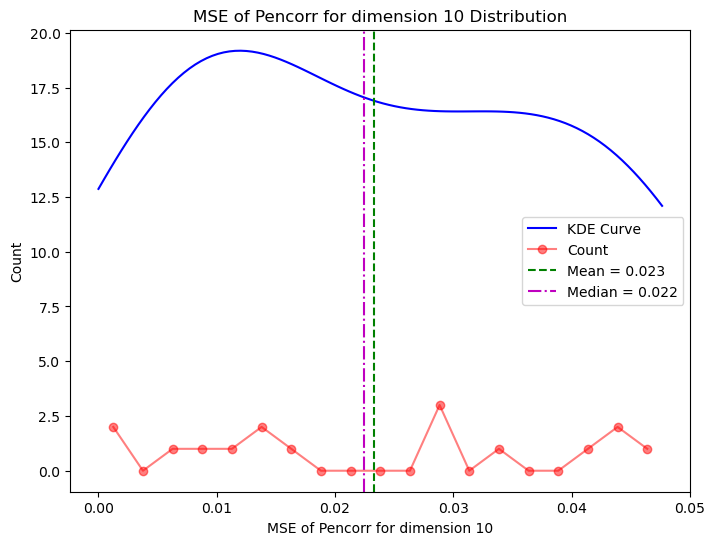

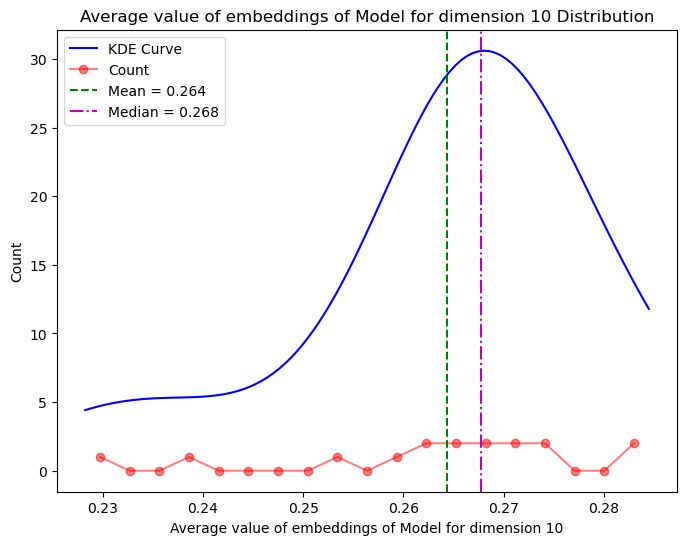

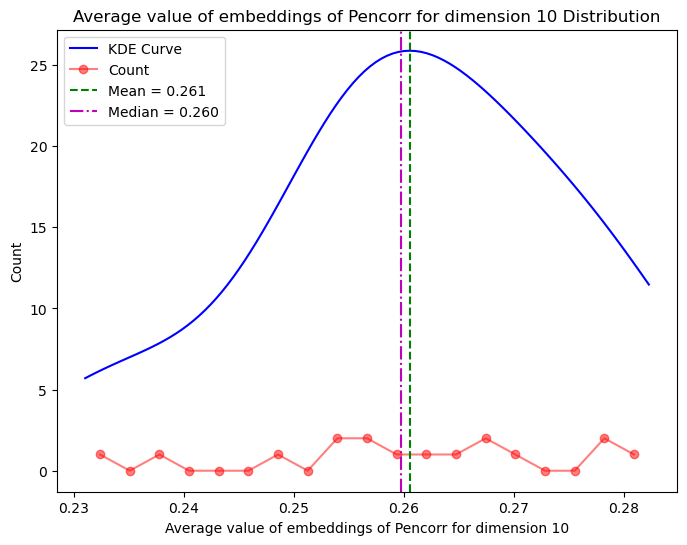

For dimension 20
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.1846,  0.2922,  0.1352, -0.1380, -0.0073,  0.1453,  0.1807, -0.2380,
         -0.2327,  0.1753,  0.1096,  0.1822, -0.4147, -0.4528,  0.0310,  0.0976,
         -0.0624,  0.2720,  0.1096,  0.3542]], device='cuda:0',
       grad_fn=<DivBackward0>)
Embedding of similar image 182 for Model: tensor([[-0.1846,  0.2922,  0.1352, -0.1380, -0.0073,  0.1453,  0.1807, -0.2380,
         -0.2327,  0.1753,  0.1096,  0.1822, -0.4147, -0.4528,  0.0310,  0.0976,
         -0.0624,  0.2720,  0.1096,  0.3542]], device='cuda:0',
       grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.57287583 -0.07468693  0.26032518  0.32753181 -0.1336694  -0.51128707
 -0.11420859  0.21966305  0.05991603  0.05752347 -0.06740337 -0.15188644
 -0.04351104 -0.12283577  0.07214362  0.03792381  0.16033117 -0.16359667
  0.15614704  0.12499292]

Embedding of similar image 182 for Pencorr (A'A): [ 0.57287583 -0.07

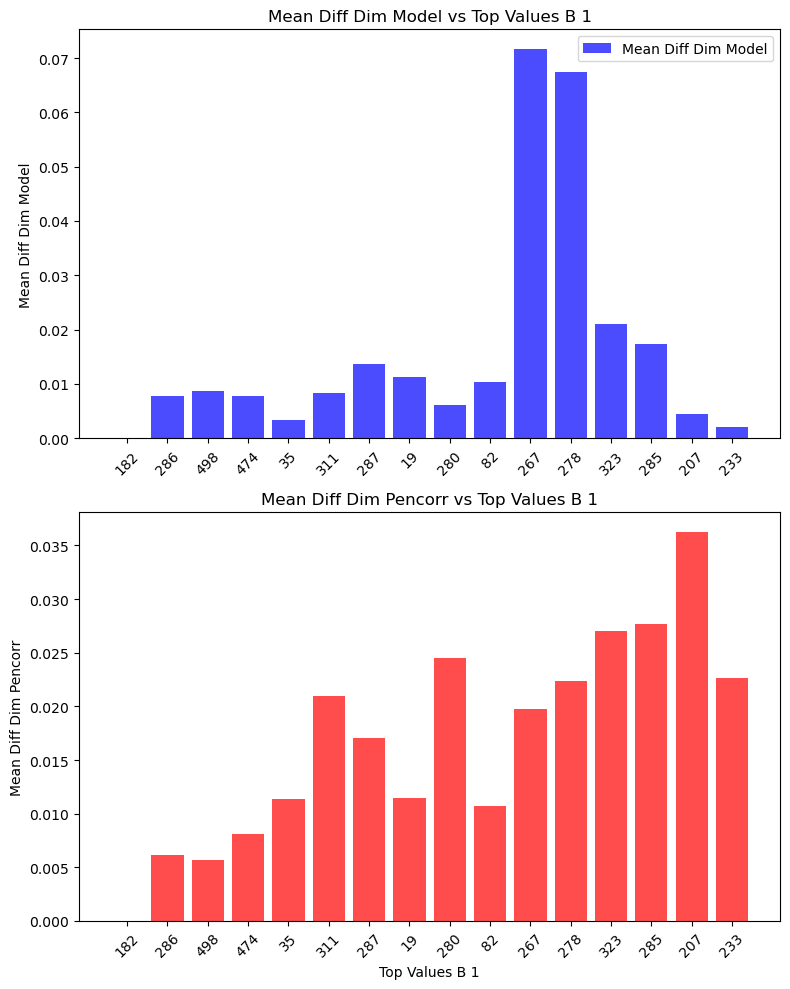

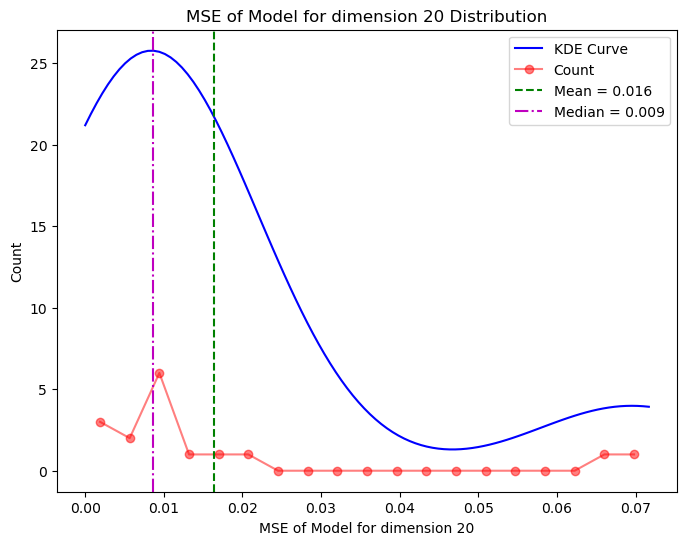

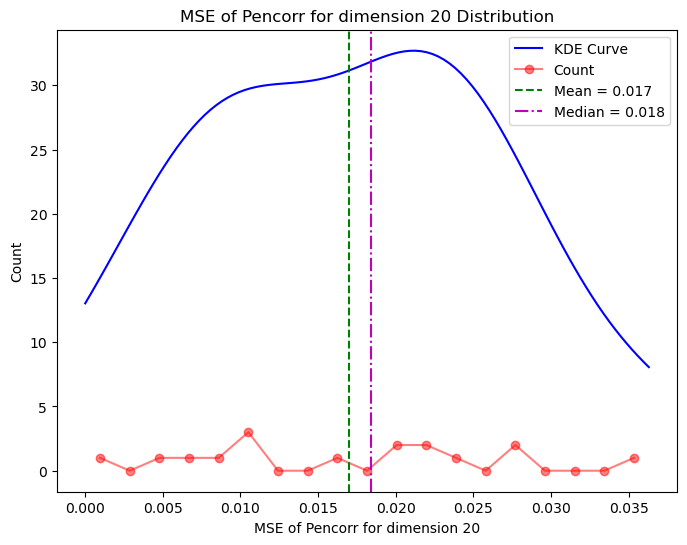

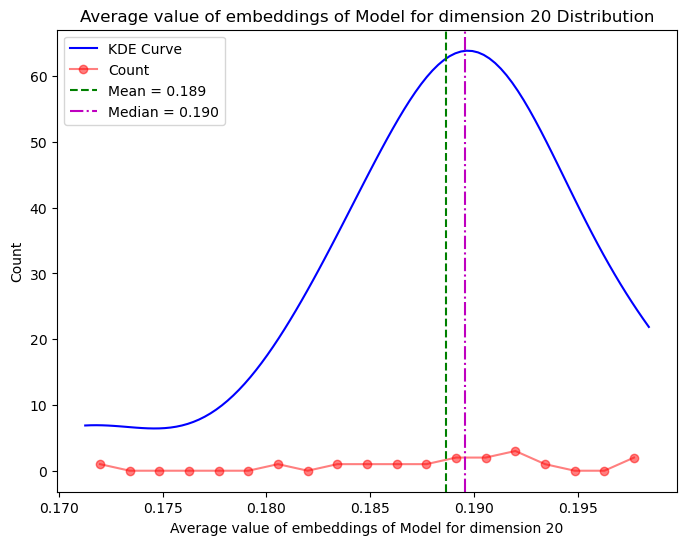

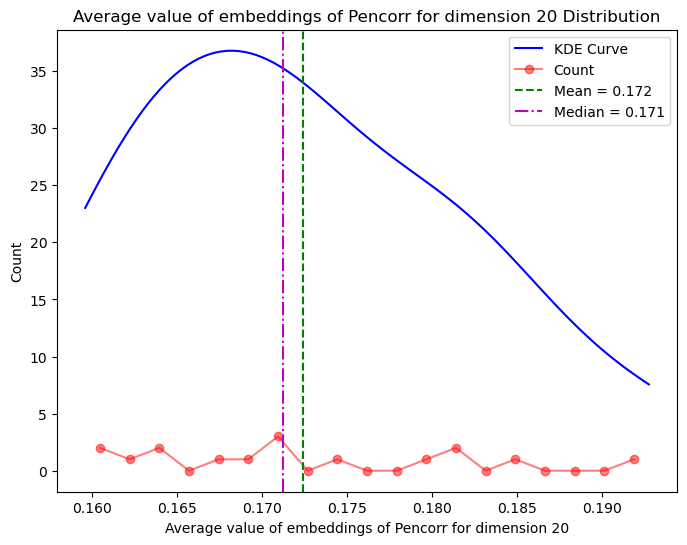

For dimension 30
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.1847,  0.1394, -0.0699, -0.1471, -0.1826,  0.2577, -0.1163,  0.0468,
         -0.0184, -0.0541,  0.2895, -0.2414, -0.3617,  0.2041,  0.1539,  0.1894,
         -0.3005, -0.0484, -0.0179, -0.2820, -0.2136, -0.1809,  0.0282,  0.0393,
         -0.3069,  0.0228, -0.2563, -0.0332,  0.0689,  0.0872]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embedding of similar image 182 for Model: tensor([[-0.1847,  0.1394, -0.0699, -0.1471, -0.1826,  0.2577, -0.1163,  0.0468,
         -0.0184, -0.0541,  0.2895, -0.2414, -0.3617,  0.2041,  0.1539,  0.1894,
         -0.3005, -0.0484, -0.0179, -0.2820, -0.2136, -0.1809,  0.0282,  0.0393,
         -0.3069,  0.0228, -0.2563, -0.0332,  0.0689,  0.0872]],
       device='cuda:0', grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.56019577 -0.07252855  0.24938918  0.30526482 -0.13264392 -0.4776768
 -0.11898819  0.18449139  0.08451342  0.0500

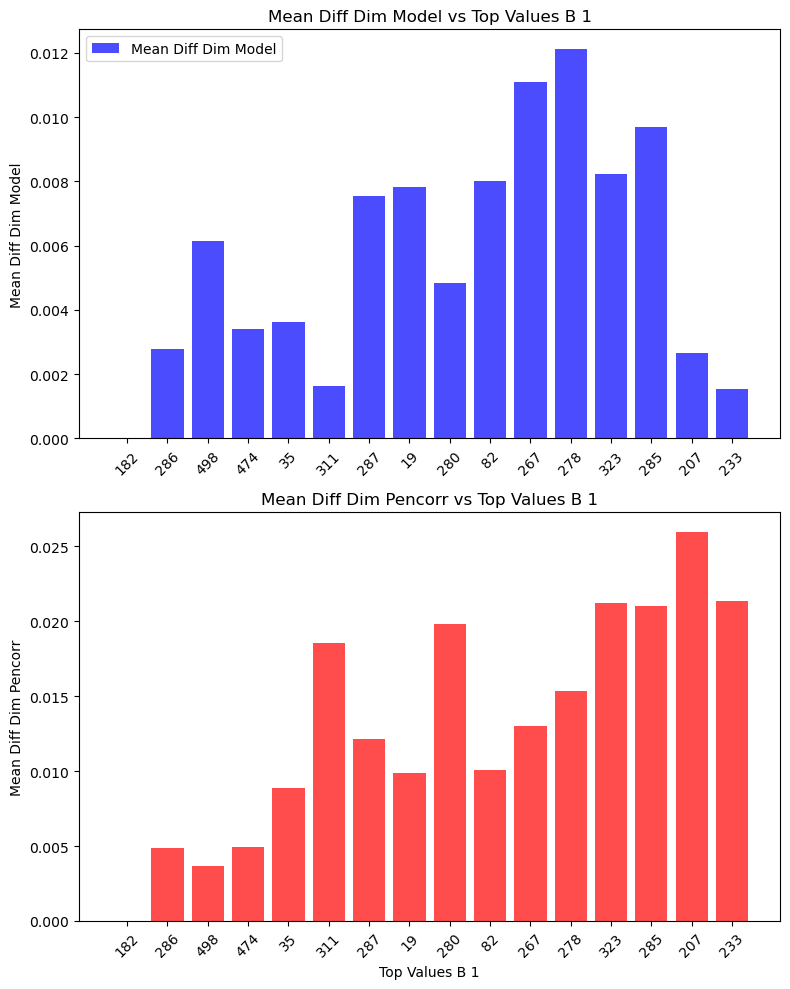

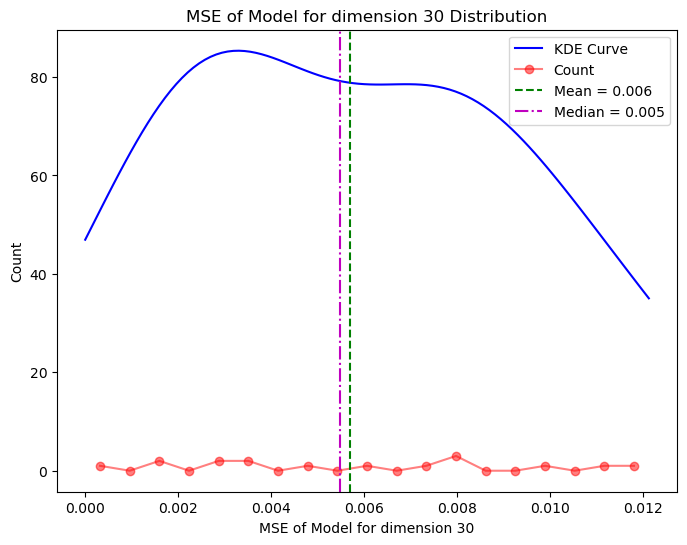

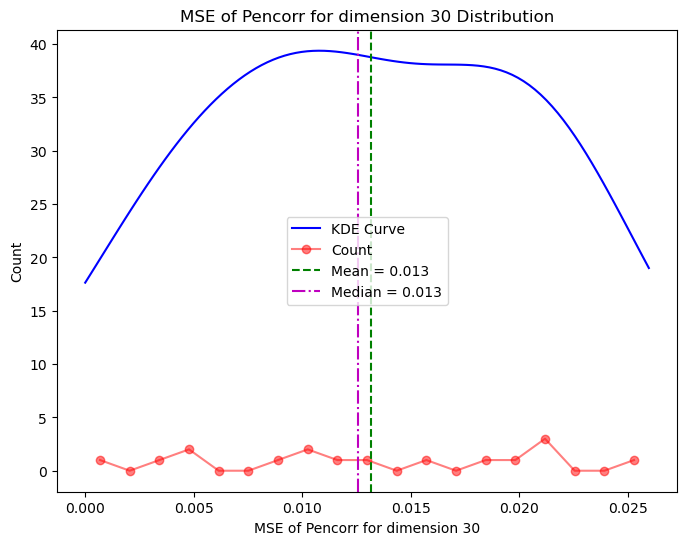

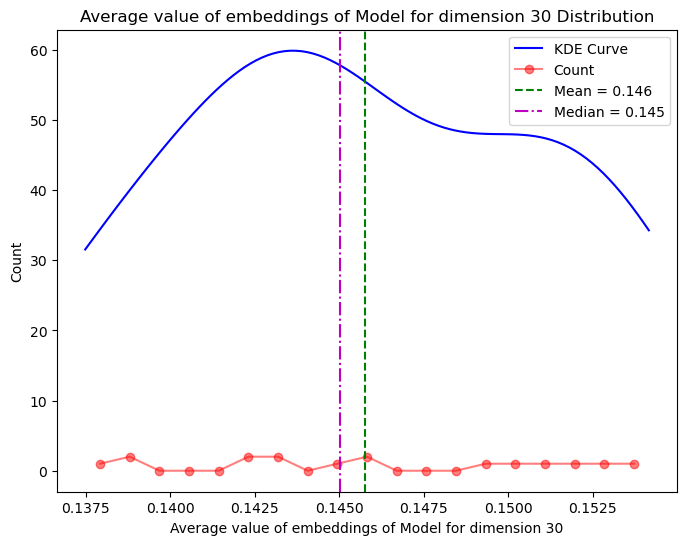

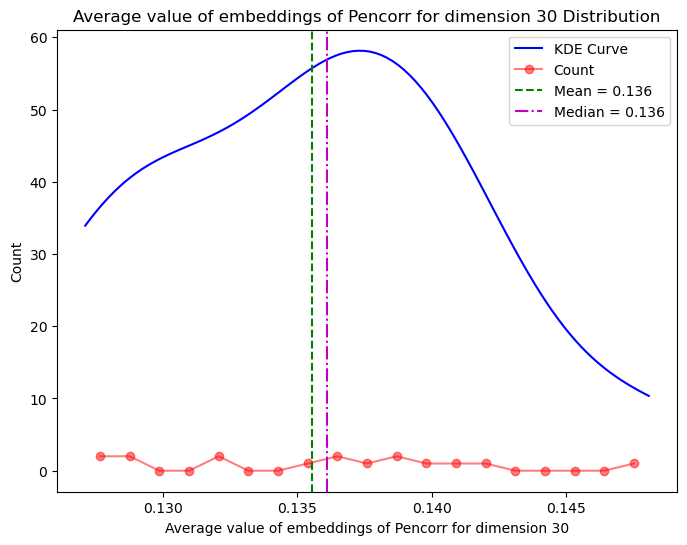

For dimension 40
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.0925,  0.0313,  0.1547, -0.3149,  0.2487, -0.0242,  0.0780,  0.0746,
         -0.0319,  0.1023, -0.0482, -0.1628,  0.0447, -0.2295, -0.1008, -0.0239,
          0.1215, -0.1693,  0.1504, -0.0344, -0.1074,  0.0604,  0.1773,  0.0634,
          0.1635,  0.1005, -0.1315,  0.3227,  0.2123,  0.3551, -0.2327,  0.0813,
         -0.0640,  0.1464, -0.2117, -0.2219,  0.1674, -0.1179, -0.0540, -0.1231]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embedding of similar image 182 for Model: tensor([[-0.0925,  0.0313,  0.1547, -0.3149,  0.2487, -0.0242,  0.0780,  0.0746,
         -0.0319,  0.1023, -0.0482, -0.1628,  0.0447, -0.2295, -0.1008, -0.0239,
          0.1215, -0.1693,  0.1504, -0.0344, -0.1074,  0.0604,  0.1773,  0.0634,
          0.1635,  0.1005, -0.1315,  0.3227,  0.2123,  0.3551, -0.2327,  0.0813,
         -0.0640,  0.1464, -0.2117, -0.2219,  0.1674, -0.1179, -0.0540, -0.1231]],
       de

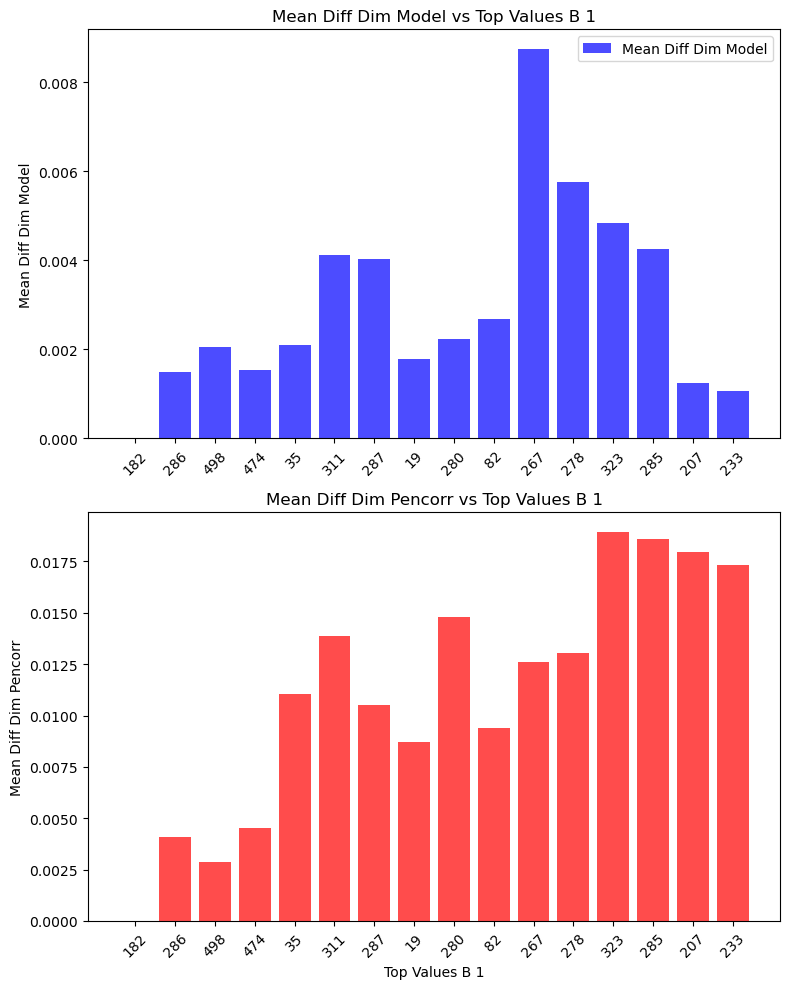

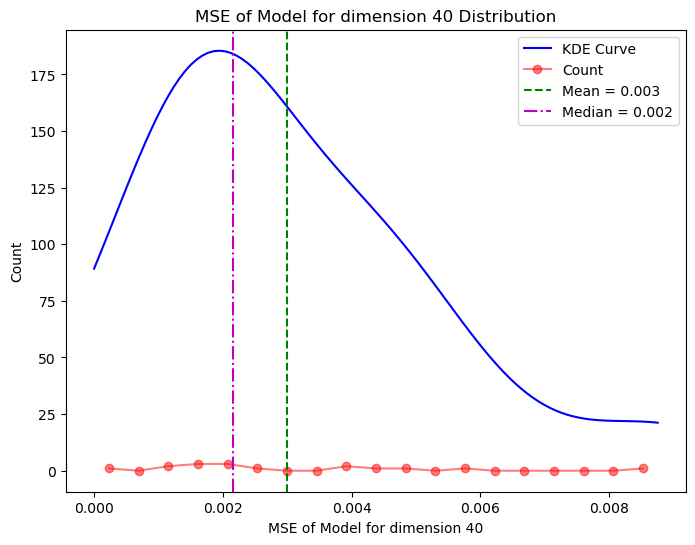

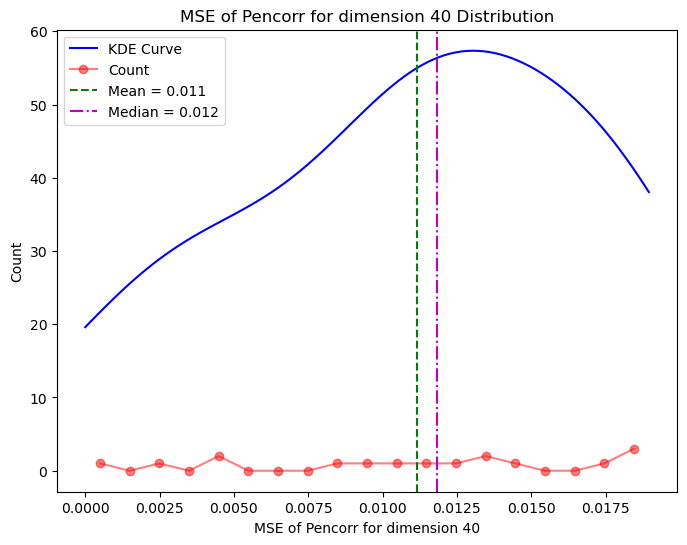

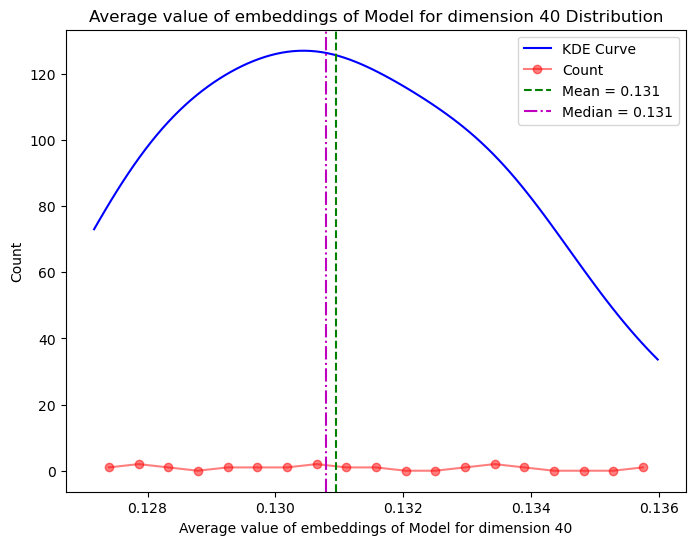

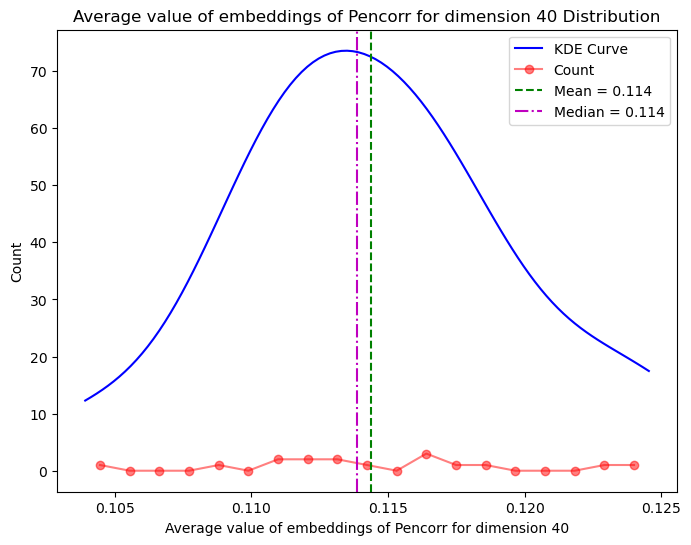

For dimension 64
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-9.3759e-02, -7.9073e-03, -8.4065e-02, -5.3361e-02,  8.0220e-02,
         -1.1103e-01,  5.9913e-02,  8.9936e-02, -7.7470e-02, -5.7809e-02,
         -9.8755e-03,  2.7023e-01,  9.1538e-02,  1.2146e-01,  1.2761e-01,
          5.5178e-02,  5.9744e-02,  5.9420e-02,  1.8202e-01,  2.0080e-01,
          2.3259e-01, -3.3539e-02,  2.3301e-02, -1.2675e-01, -2.5047e-02,
         -1.3252e-01, -1.2479e-01,  1.0641e-01, -5.6670e-02, -6.0520e-02,
          1.6301e-02, -2.1553e-01,  1.9959e-01, -1.7194e-01,  2.1514e-02,
          6.6219e-02, -1.9795e-01, -1.1177e-01,  2.9619e-02,  3.0650e-01,
         -7.0409e-02,  4.2690e-03,  1.8720e-01,  7.6216e-02,  6.9737e-02,
         -1.4027e-01,  2.0840e-01, -8.9116e-02, -1.0988e-01,  2.1496e-04,
         -2.4270e-04, -7.9217e-02,  3.9497e-02,  3.1588e-01,  5.1573e-02,
         -8.4594e-02,  4.3961e-02, -1.2220e-01, -1.3188e-01,  1.5150e-01,
          6.5782e-02,  3.

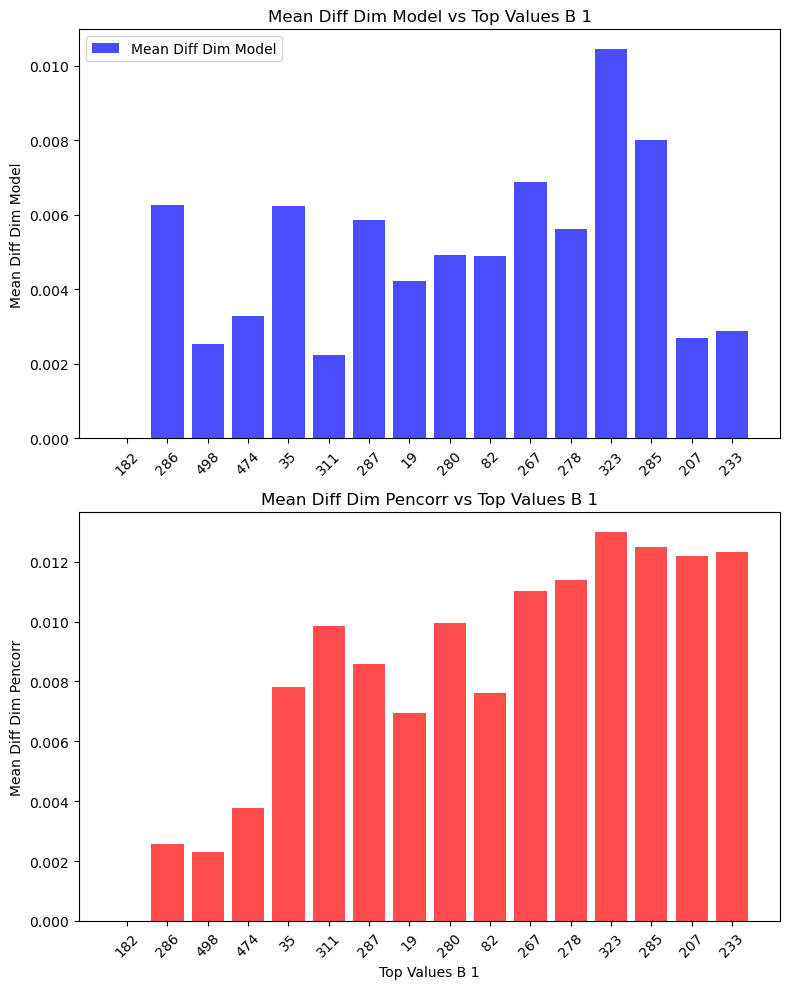

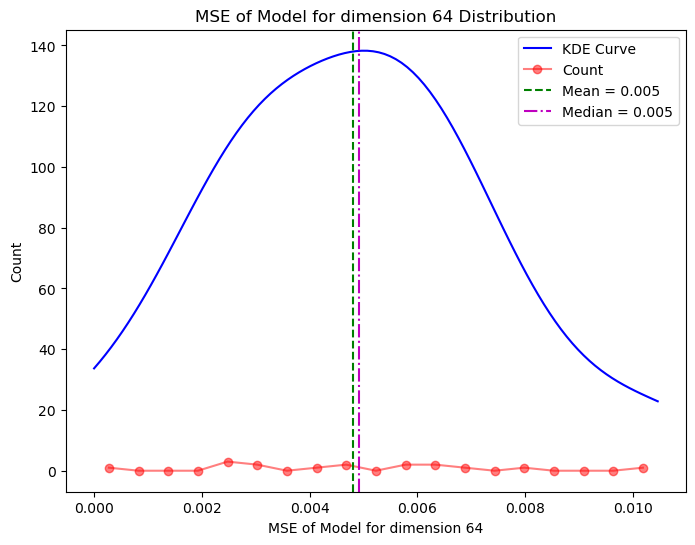

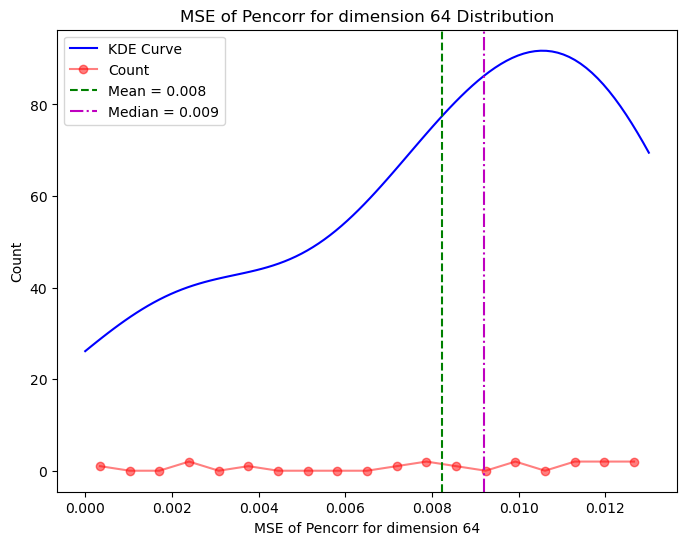

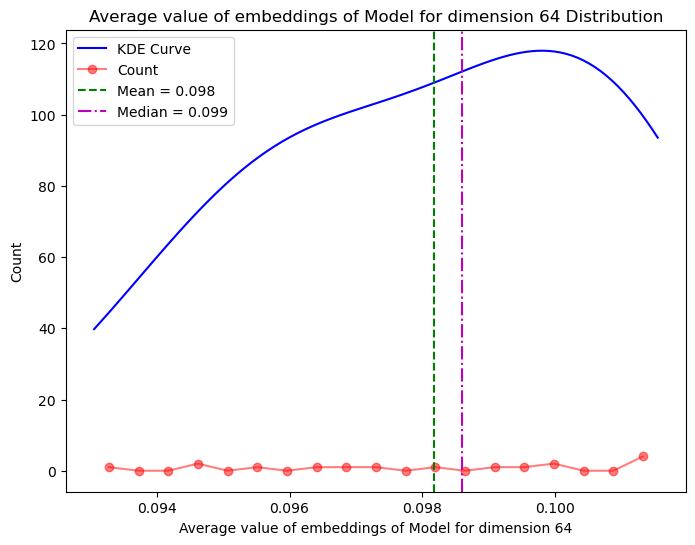

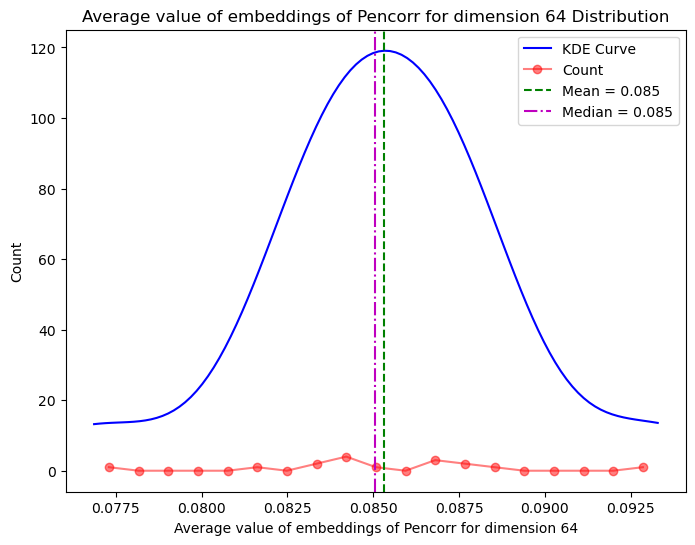

For dimension 128
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.0212,  0.0394,  0.0306,  0.0134, -0.0719,  0.1293, -0.0125, -0.0277,
          0.0628,  0.0481, -0.0660,  0.0271, -0.0872,  0.0270, -0.1107,  0.1007,
          0.0512, -0.2553, -0.0236, -0.0620,  0.1077, -0.0257,  0.0674, -0.0566,
         -0.0989, -0.1269, -0.0894, -0.0631, -0.0531, -0.0455, -0.0270,  0.0865,
         -0.0262, -0.0942,  0.1554,  0.0324,  0.0560, -0.0264, -0.0886, -0.0284,
          0.1150, -0.0116,  0.0892, -0.0471,  0.0363,  0.0254,  0.0362,  0.1659,
         -0.0805, -0.0262,  0.0507,  0.0131,  0.0133, -0.0060,  0.1080,  0.0337,
          0.1100, -0.0315, -0.0043,  0.1033, -0.0011, -0.0003, -0.0795,  0.1678,
         -0.1389,  0.0952, -0.1800,  0.0484,  0.0252,  0.0206,  0.1430, -0.1869,
          0.1078, -0.0388, -0.0756, -0.1365,  0.2115, -0.0246, -0.0047, -0.1589,
          0.1706, -0.1352, -0.0720, -0.0218,  0.1150, -0.2043,  0.0929,  0.0513,
         -0.1860,  0.

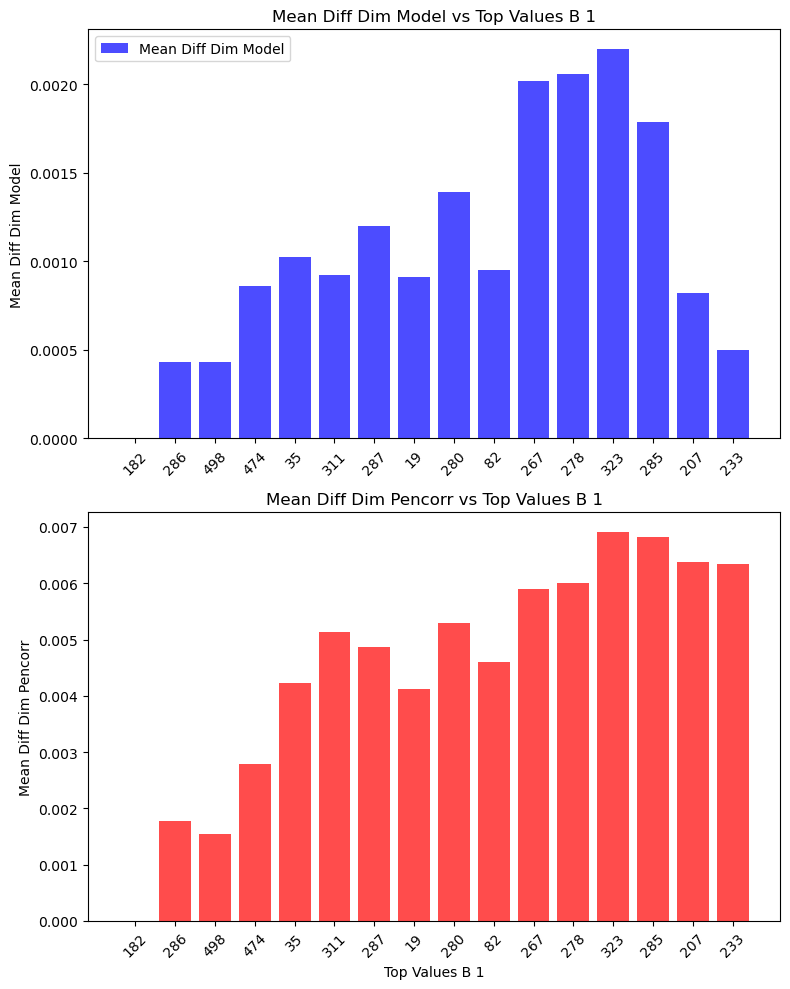

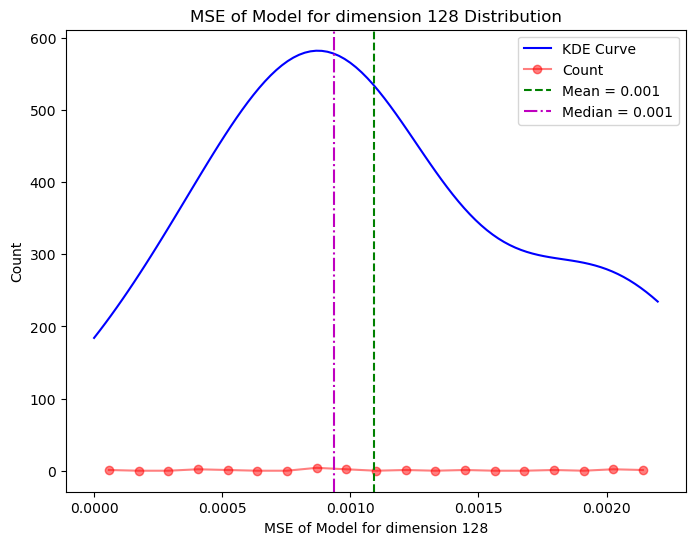

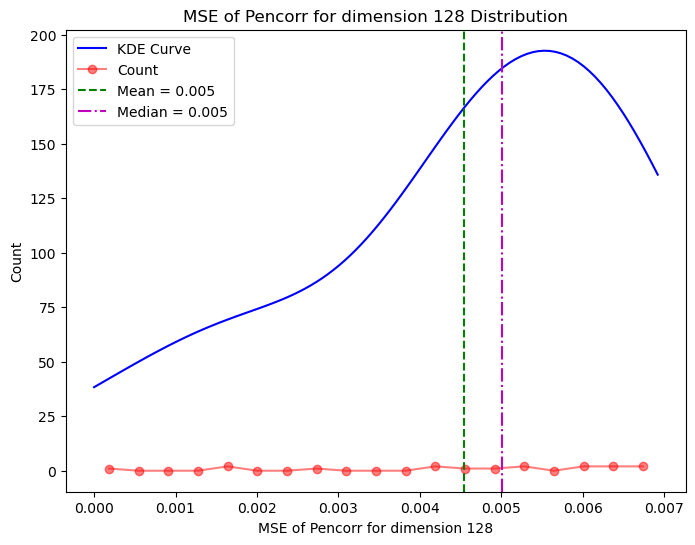

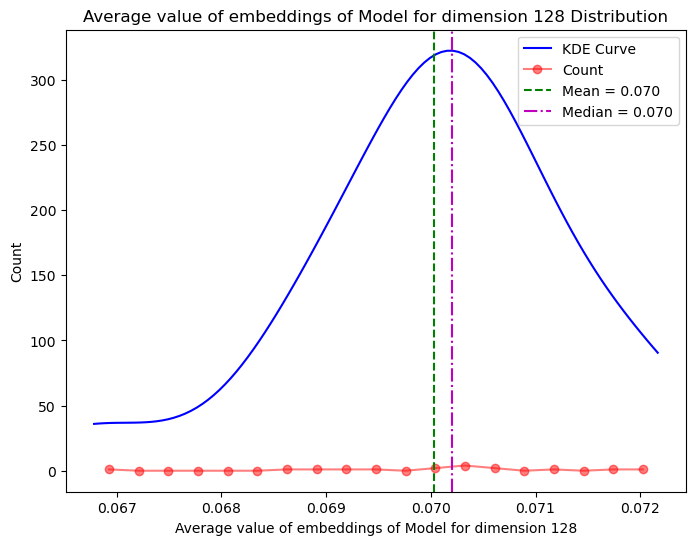

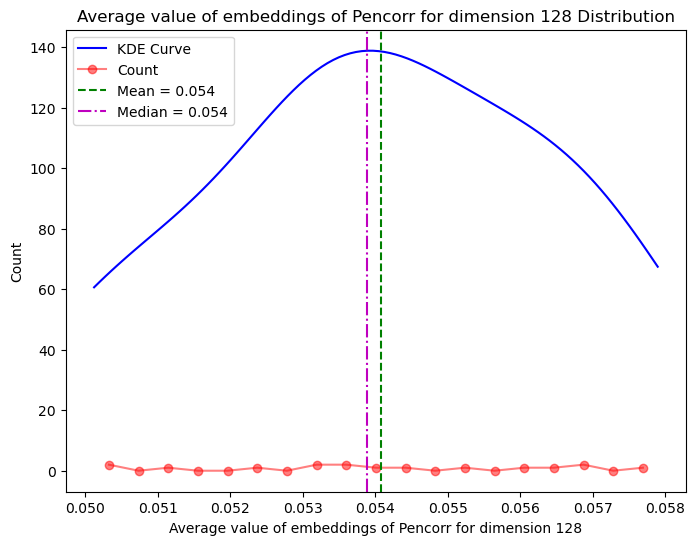

For dimension 256
182

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-3.8282e-03,  1.8197e-02,  7.6581e-02,  8.0126e-02,  9.2028e-02,
          7.7459e-02, -6.5348e-02,  3.8536e-02, -1.8748e-02,  1.2356e-02,
          4.5371e-02, -7.2015e-02,  7.6290e-02,  1.3057e-02,  9.1996e-02,
          6.5679e-02, -4.3771e-02,  3.2543e-02,  4.5019e-02,  1.3082e-02,
          1.1932e-02, -6.5331e-03,  2.6587e-02,  9.3583e-03, -2.6405e-02,
         -1.1284e-02, -2.2292e-02, -1.5141e-02,  2.0227e-03,  6.8603e-03,
          1.1373e-01, -2.6108e-02, -3.2601e-02, -7.0280e-02,  7.2471e-02,
          1.4404e-03,  1.1333e-02, -8.9436e-02, -3.7270e-02, -2.7711e-02,
          1.6223e-02, -1.1375e-01,  1.0560e-01,  3.6512e-02,  3.9507e-02,
          8.9829e-02, -5.8597e-02,  5.0303e-02, -2.2094e-03,  1.2568e-01,
          5.6418e-02, -1.3100e-01, -4.0238e-02,  4.5603e-02, -1.3708e-02,
          6.3503e-02,  9.9536e-02,  7.4157e-02,  2.0245e-02, -8.2710e-02,
         -4.3623e-02, -4

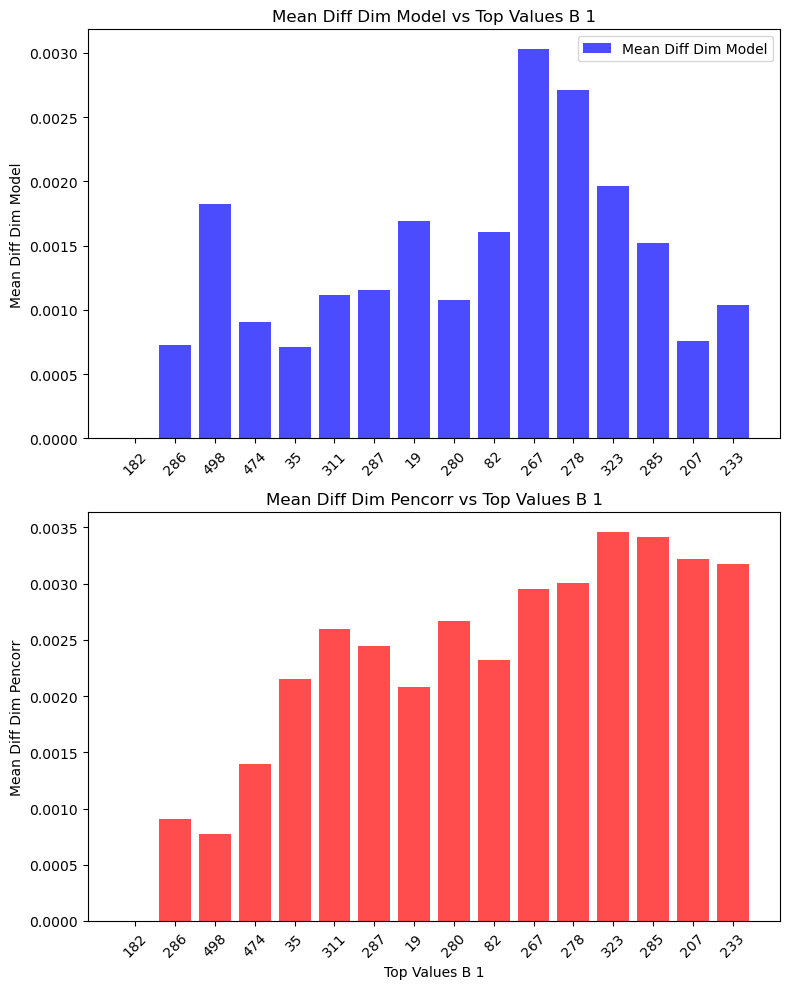

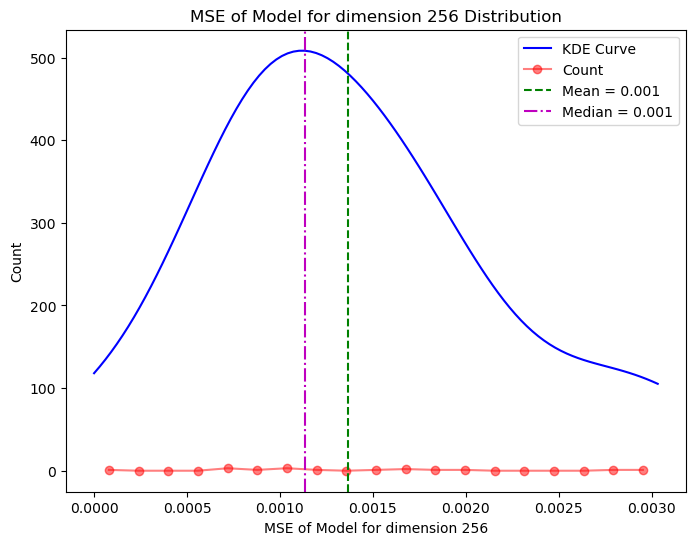

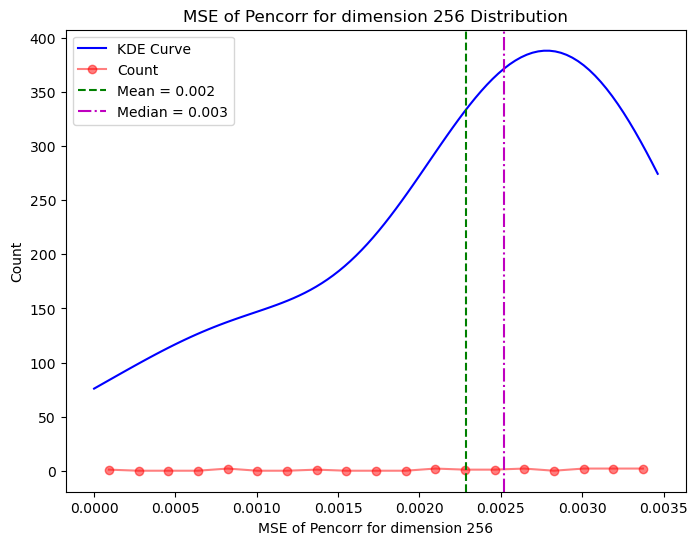

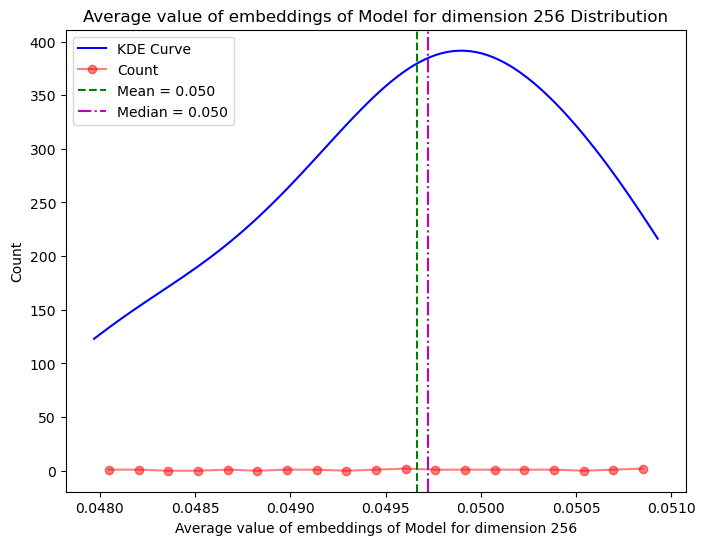

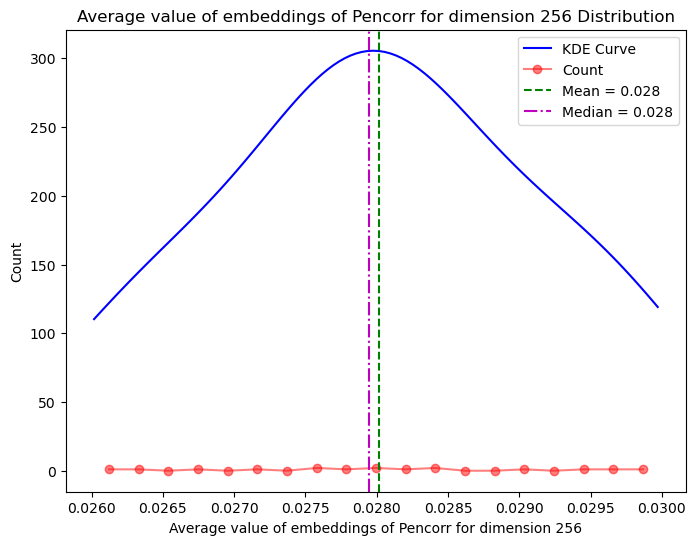

In [7]:
#comparison with similar images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [5, 10, 20, 30, 40, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN1(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer0.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(top_values_b_1)):
        top_1_index = top_values_b_1[i][0]
        print(top_1_index)
        print(f"\nPrinting vectors for index {index1}")
        print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in top_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

For dimension 5
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.6915, -0.4792,  0.3306, -0.1283, -0.4080]], device='cuda:0',
       grad_fn=<DivBackward0>)
Embedding of similar image 4 for Model: tensor([[-0.2018,  0.4110, -0.5877, -0.0209,  0.6668]], device='cuda:0',
       grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.7433385  -0.0671092  -0.36826761 -0.48726466 -0.26437918]

Embedding of similar image 4 for Pencorr (A'A): [-0.74541678 -0.3874654   0.18092058  0.47653063 -0.18550119]

Differences between vector embeddings
Mean Squared Difference of Model between 2 similar images: 0.608398151397705
Mean Squared Difference of Pencorr (A'A) between 2 similar images: 0.7111502275771194
235

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.6915, -0.4792,  0.3306, -0.1283, -0.4080]], device='cuda:0',
       grad_fn=<DivBackward0>)
Embedding of similar image 235 for Model: tensor([[-0.0108,  0.0176, -0.8499

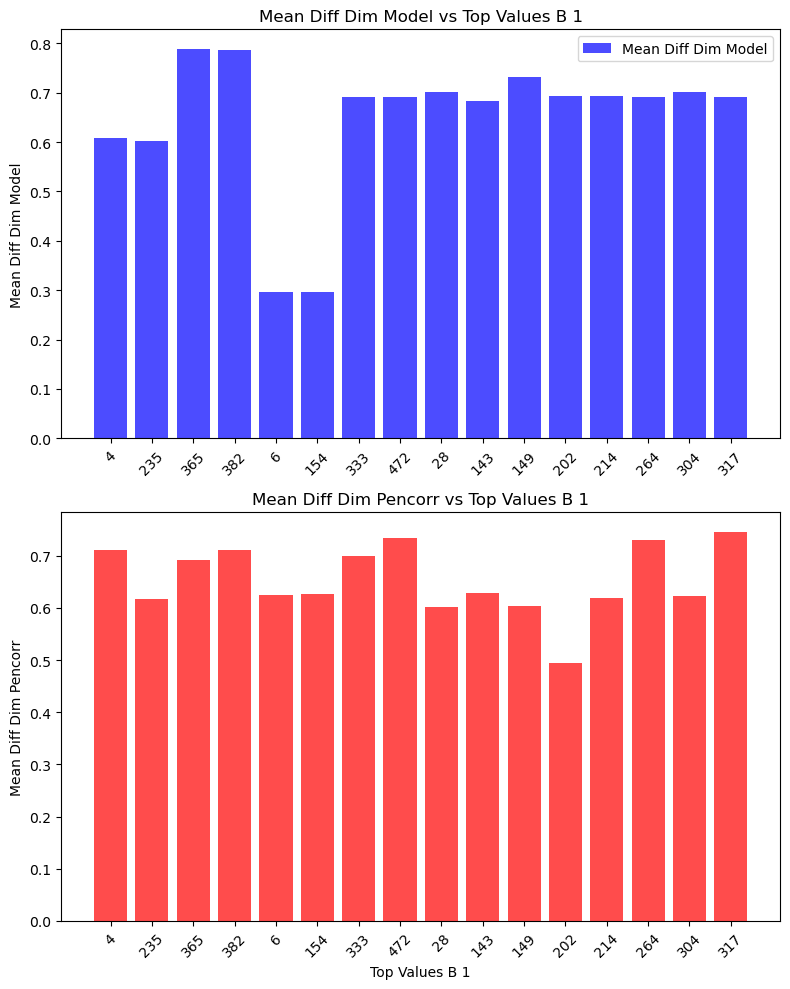

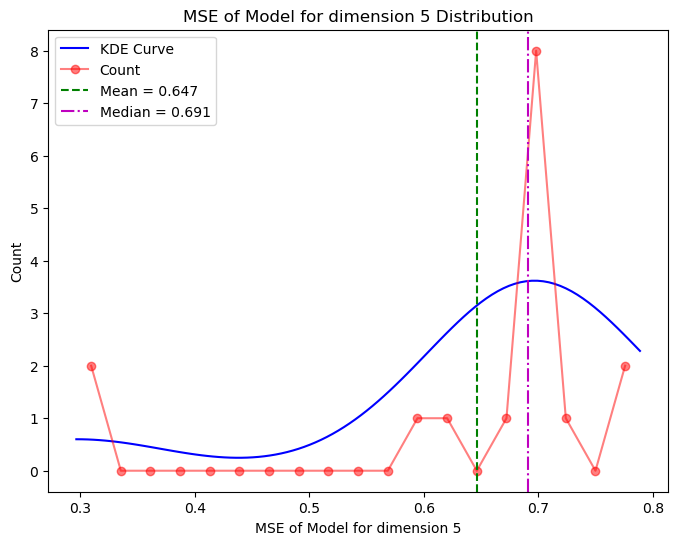

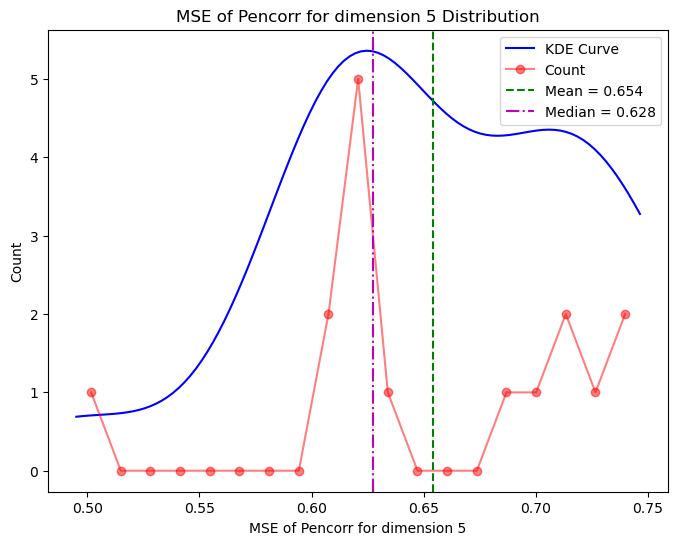

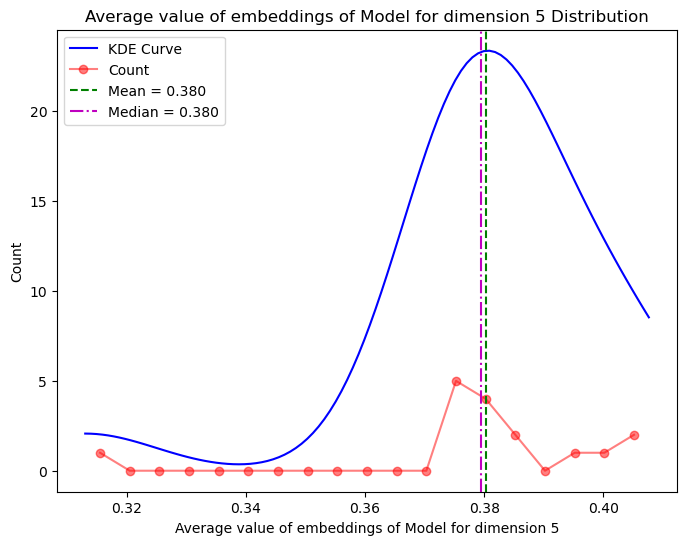

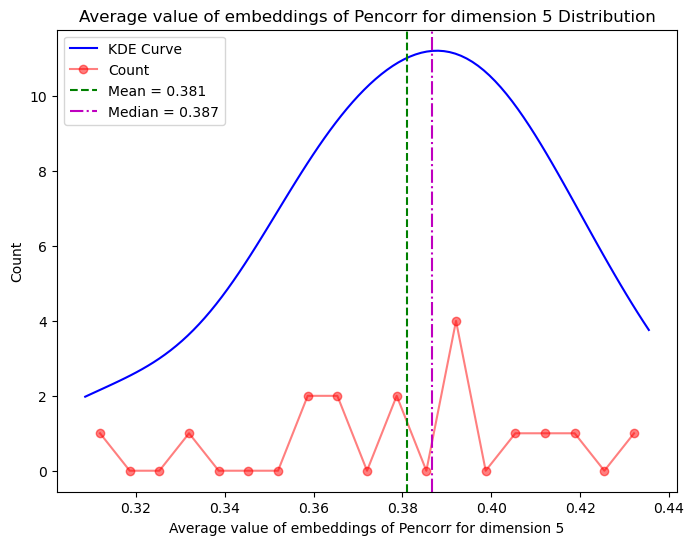

For dimension 10
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.3692,  0.1814, -0.4594,  0.4338,  0.4430, -0.1532, -0.0936, -0.3595,
         -0.2532, -0.0986]], device='cuda:0', grad_fn=<DivBackward0>)
Embedding of similar image 4 for Model: tensor([[ 0.4987, -0.0206,  0.0643, -0.5685,  0.1040,  0.3175, -0.1159,  0.5232,
          0.1153,  0.1068]], device='cuda:0', grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.60080415 -0.07925919 -0.28067082 -0.33481871  0.21281156  0.5655596
  0.12760043 -0.21160117 -0.04916499  0.11511793]

Embedding of similar image 4 for Pencorr (A'A): [-0.69034342 -0.34463379  0.16306556  0.40433036  0.16955762  0.00152329
  0.01911117 -0.14775076  0.12260839 -0.38548625]

Differences between vector embeddings
Mean Squared Difference of Model between 2 similar images: 0.3367154121398926
Mean Squared Difference of Pencorr (A'A) between 2 similar images: 0.3096694331090676
235

Printing vectors for index 1

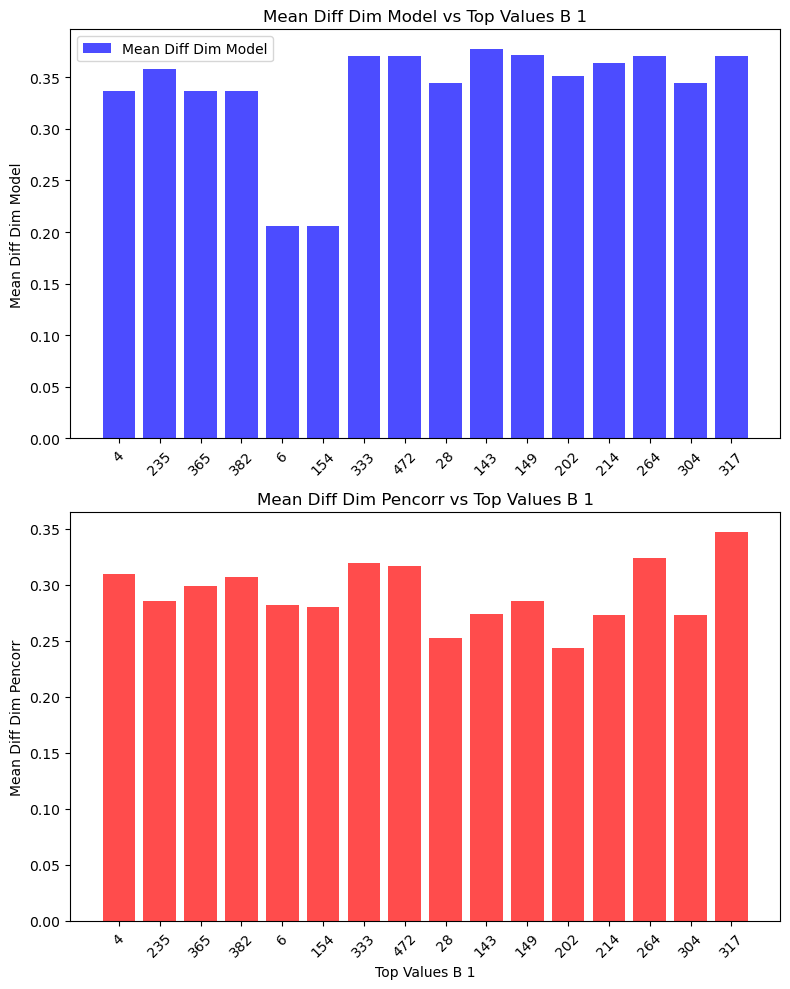

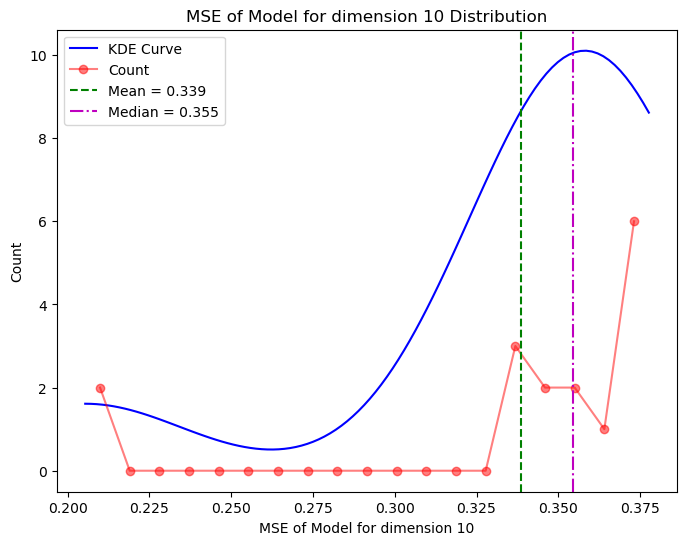

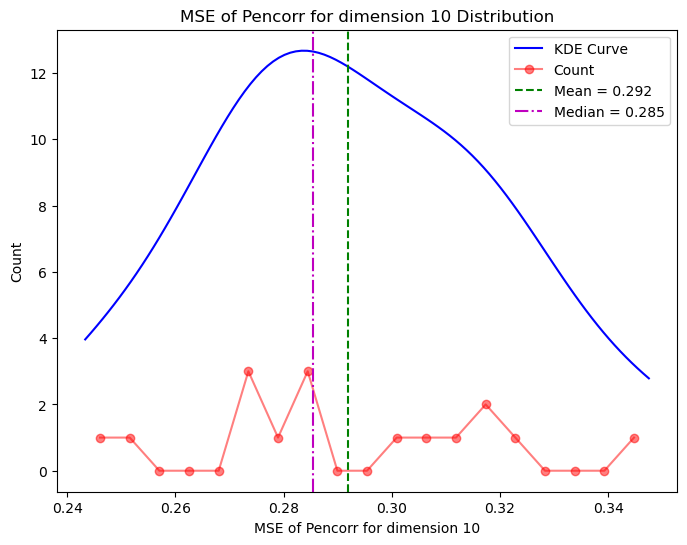

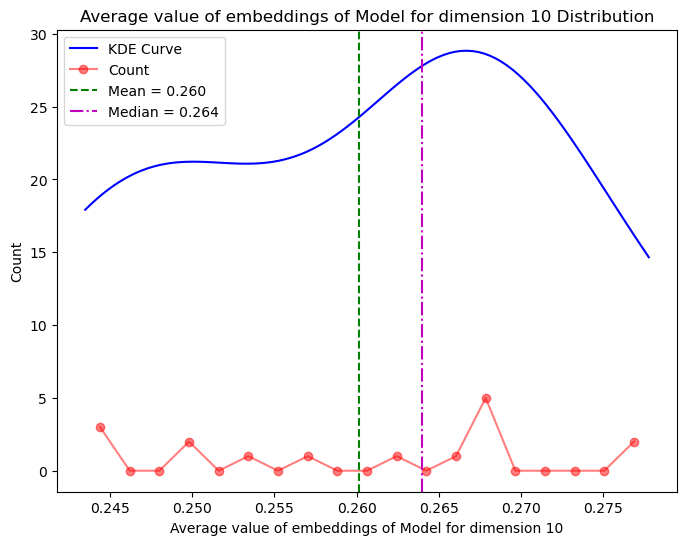

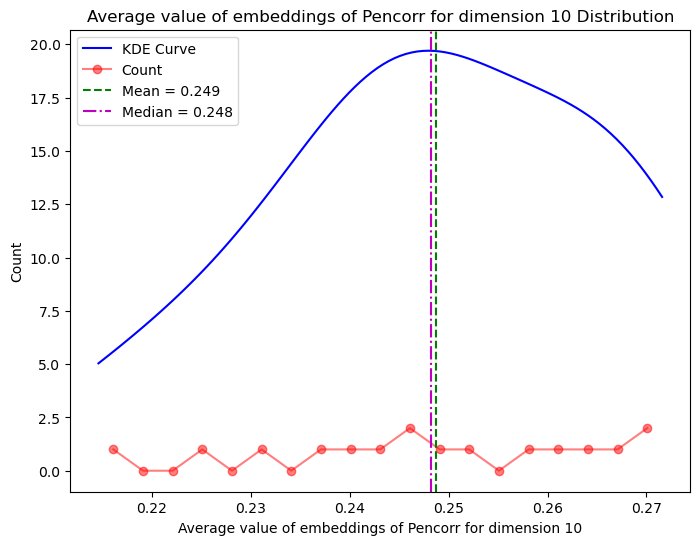

For dimension 20
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.1846,  0.2922,  0.1352, -0.1380, -0.0073,  0.1453,  0.1807, -0.2380,
         -0.2327,  0.1753,  0.1096,  0.1822, -0.4147, -0.4528,  0.0310,  0.0976,
         -0.0624,  0.2720,  0.1096,  0.3542]], device='cuda:0',
       grad_fn=<DivBackward0>)
Embedding of similar image 4 for Model: tensor([[ 0.2216, -0.1801,  0.0851,  0.1153, -0.0768, -0.0130, -0.1068,  0.2893,
          0.2881, -0.1620, -0.2010, -0.4078,  0.2671,  0.5135, -0.0098, -0.1853,
          0.2499, -0.0732,  0.0306, -0.2066]], device='cuda:0',
       grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.57287583 -0.07468693  0.26032518  0.32753181 -0.1336694  -0.51128707
 -0.11420859  0.21966305  0.05991603  0.05752347 -0.06740337 -0.15188644
 -0.04351104 -0.12283577  0.07214362  0.03792381  0.16033117 -0.16359667
  0.15614704  0.12499292]

Embedding of similar image 4 for Pencorr (A'A): [-0.64379041 -0.30303144

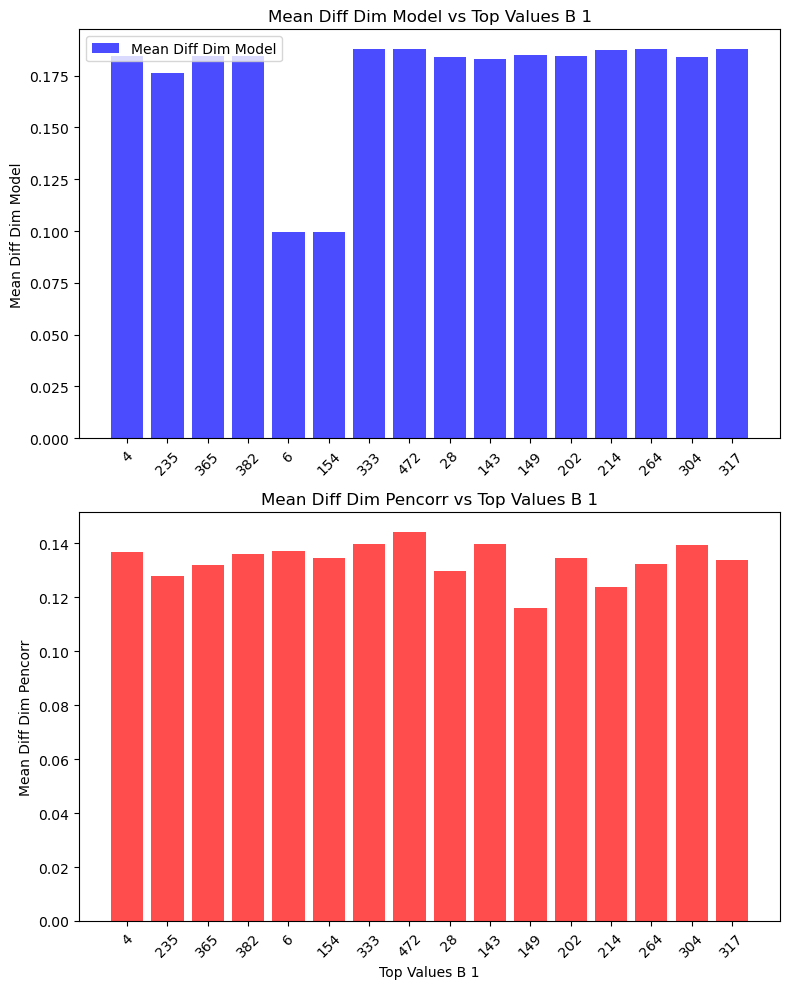

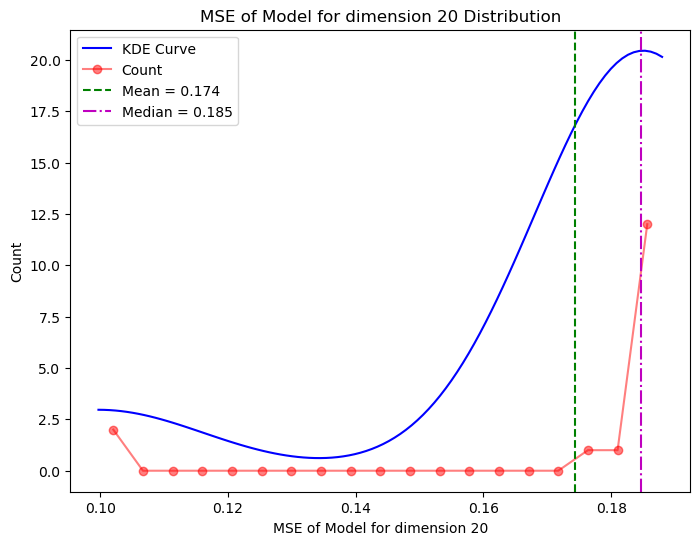

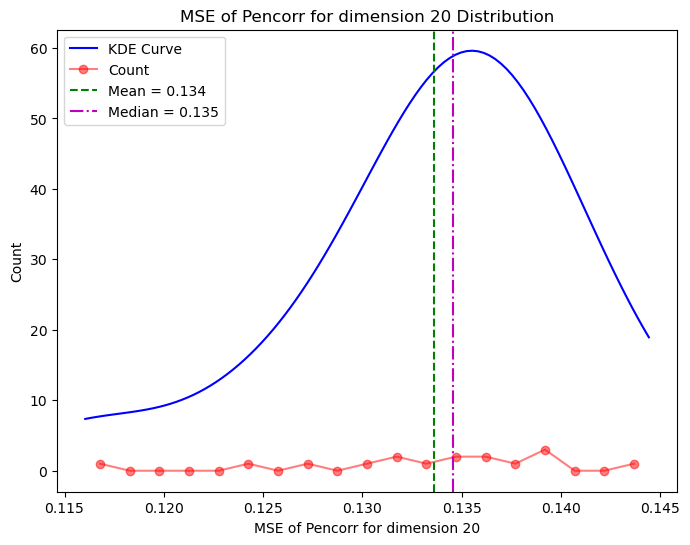

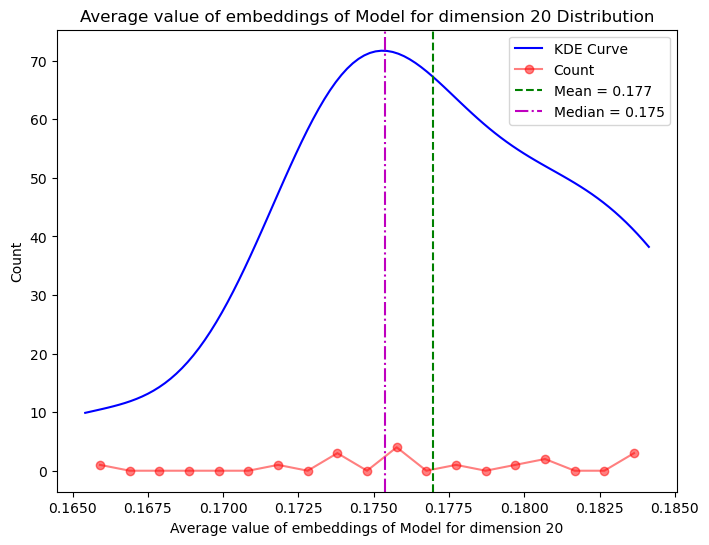

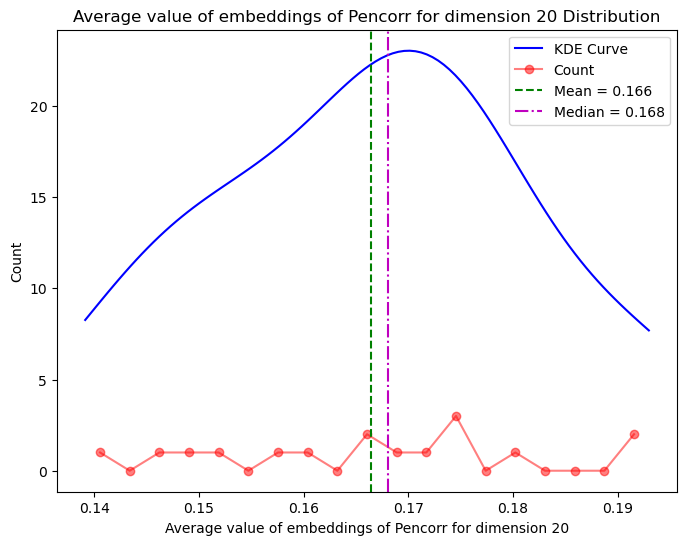

For dimension 30
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.1847,  0.1394, -0.0699, -0.1471, -0.1826,  0.2577, -0.1163,  0.0468,
         -0.0184, -0.0541,  0.2895, -0.2414, -0.3617,  0.2041,  0.1539,  0.1894,
         -0.3005, -0.0484, -0.0179, -0.2820, -0.2136, -0.1809,  0.0282,  0.0393,
         -0.3069,  0.0228, -0.2563, -0.0332,  0.0689,  0.0872]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embedding of similar image 4 for Model: tensor([[ 0.3800,  0.2454,  0.0396,  0.0799,  0.0548, -0.0558,  0.2621,  0.0247,
          0.0058, -0.0268, -0.0871,  0.2848,  0.3974, -0.0408,  0.0949, -0.2356,
          0.2555,  0.2302,  0.1458,  0.1123,  0.3229,  0.0185, -0.0508, -0.1162,
         -0.1028, -0.0376,  0.3197,  0.0477, -0.0626, -0.0724]],
       device='cuda:0', grad_fn=<DivBackward0>)

Embedding of image 182 for Pencorr (A'A): [ 0.56019577 -0.07252855  0.24938918  0.30526482 -0.13264392 -0.4776768
 -0.11898819  0.18449139  0.08451342  0.05008427

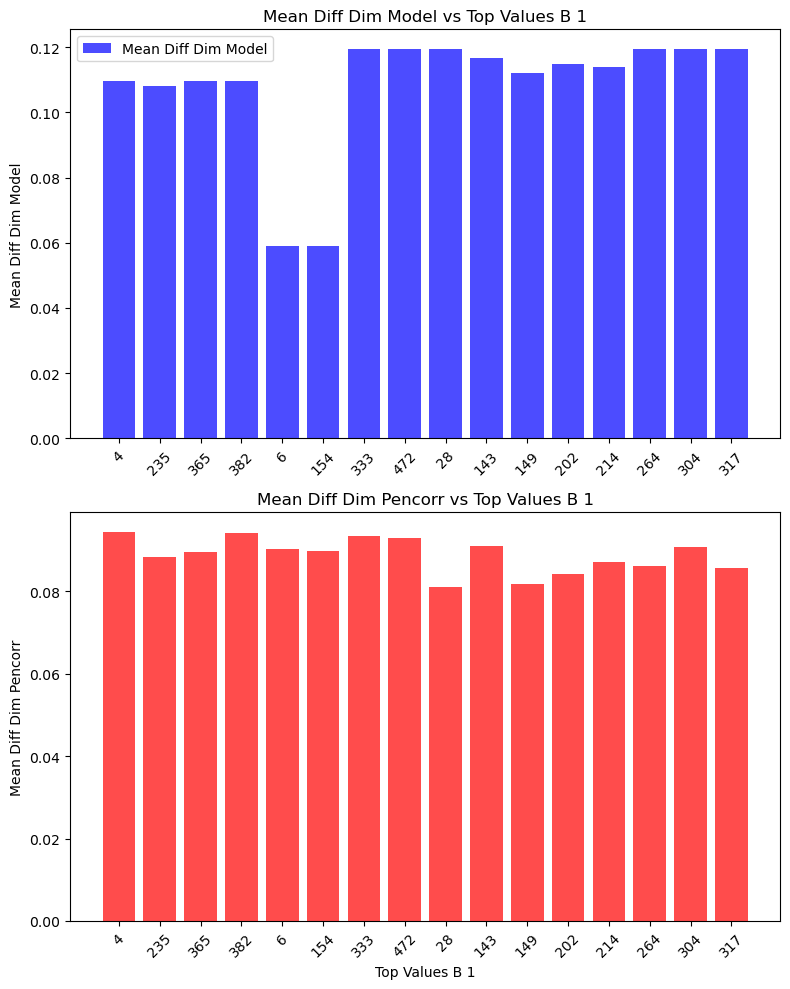

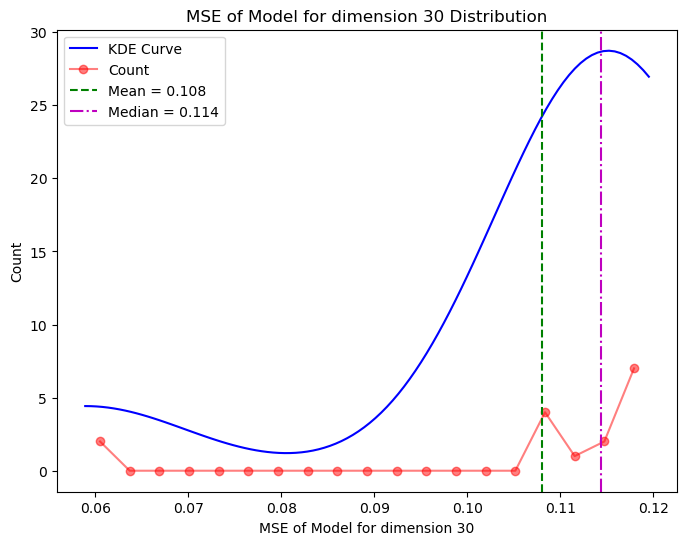

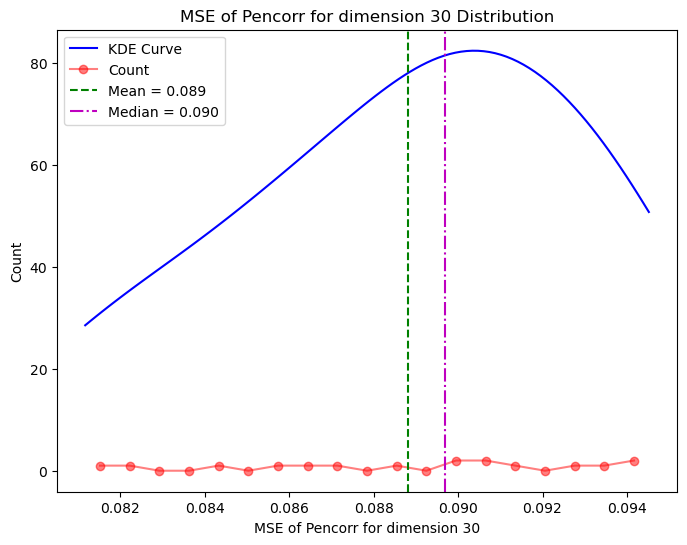

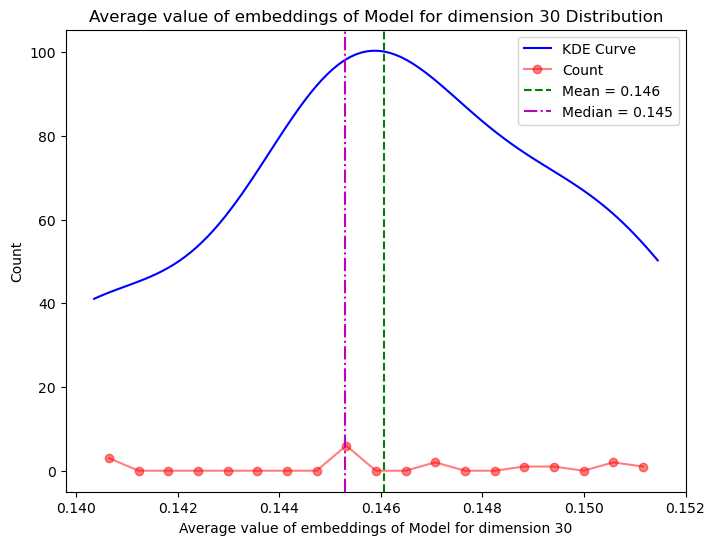

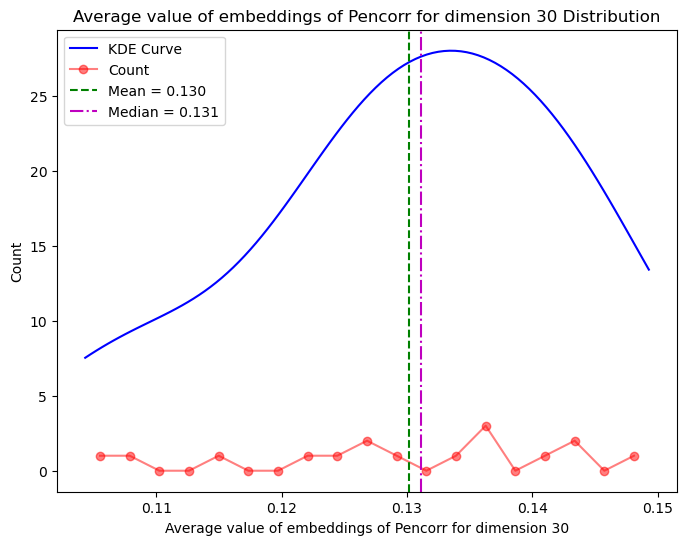

For dimension 40
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.0925,  0.0313,  0.1547, -0.3149,  0.2487, -0.0242,  0.0780,  0.0746,
         -0.0319,  0.1023, -0.0482, -0.1628,  0.0447, -0.2295, -0.1008, -0.0239,
          0.1215, -0.1693,  0.1504, -0.0344, -0.1074,  0.0604,  0.1773,  0.0634,
          0.1635,  0.1005, -0.1315,  0.3227,  0.2123,  0.3551, -0.2327,  0.0813,
         -0.0640,  0.1464, -0.2117, -0.2219,  0.1674, -0.1179, -0.0540, -0.1231]],
       device='cuda:0', grad_fn=<DivBackward0>)
Embedding of similar image 4 for Model: tensor([[ 0.0300,  0.0899, -0.2709,  0.3338, -0.2540,  0.0210, -0.0482,  0.0402,
         -0.0777, -0.0937,  0.0448,  0.0526, -0.0015,  0.3354, -0.0628,  0.0116,
         -0.0792,  0.3272, -0.1218,  0.1003,  0.2054,  0.0582, -0.0662, -0.0072,
         -0.1383, -0.0524,  0.0911, -0.2400,  0.0541, -0.2946,  0.0643, -0.1251,
         -0.0010, -0.0856,  0.2581,  0.1522, -0.1682,  0.1217,  0.1251,  0.2445]],
       device

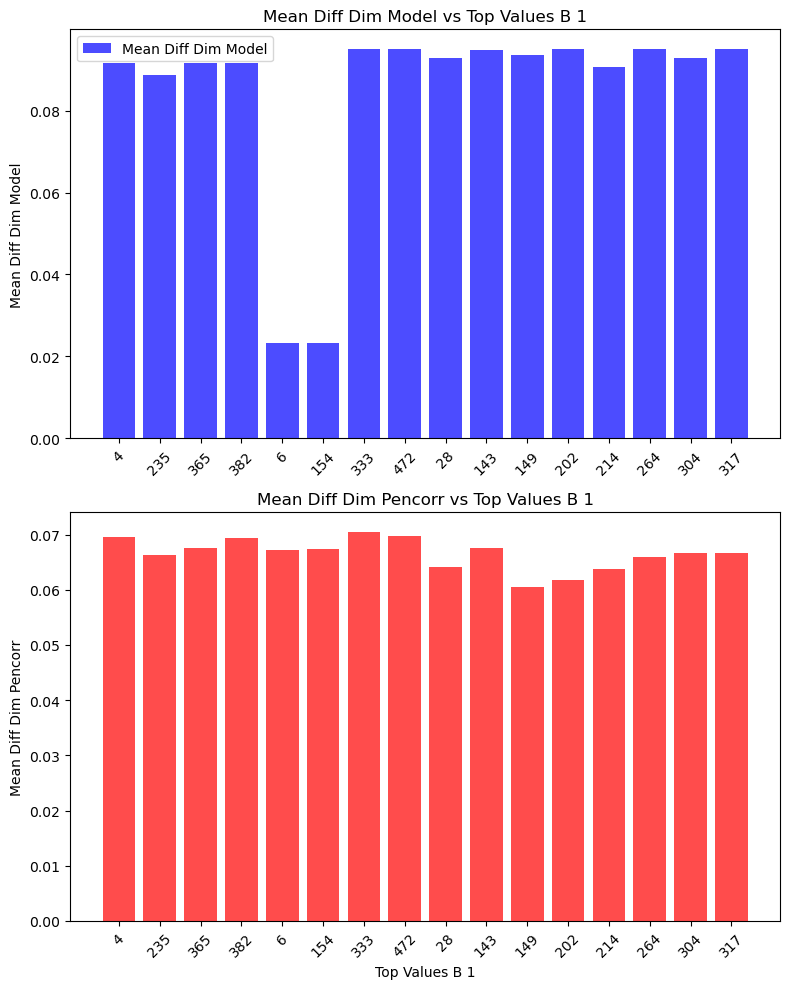

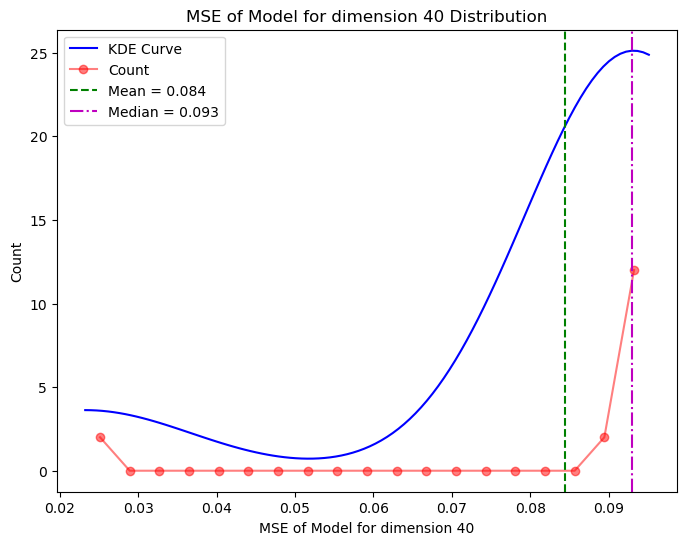

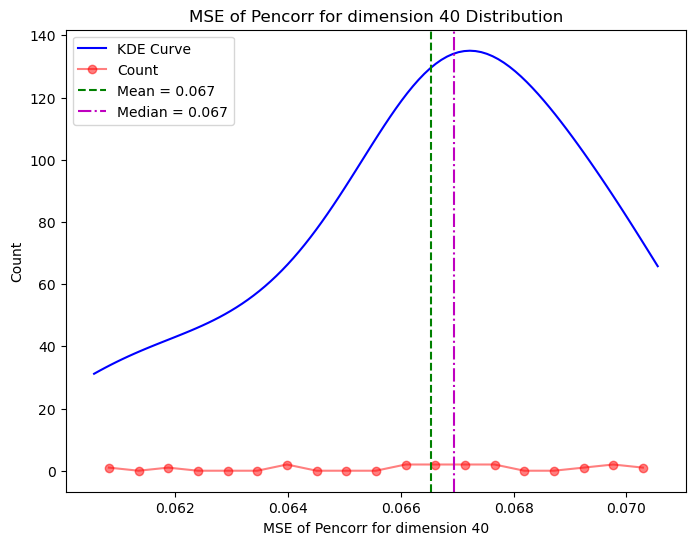

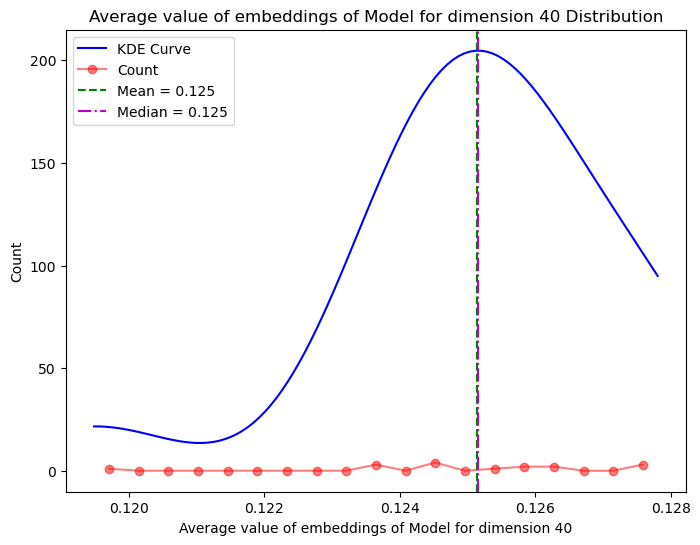

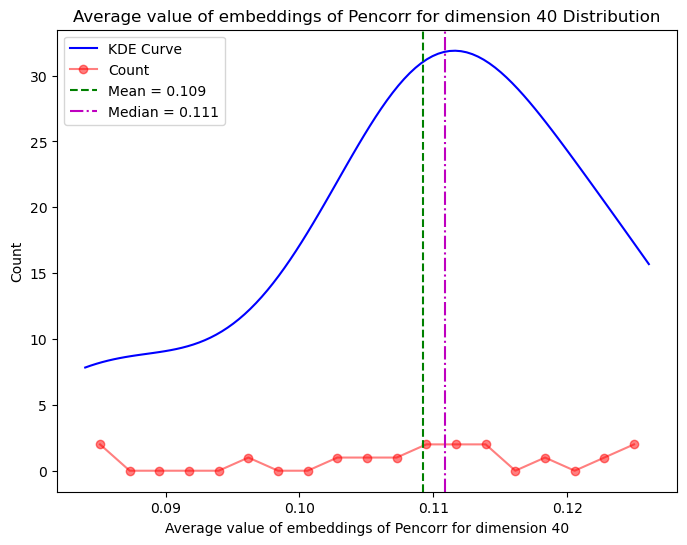

For dimension 64
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-9.3759e-02, -7.9073e-03, -8.4065e-02, -5.3361e-02,  8.0220e-02,
         -1.1103e-01,  5.9913e-02,  8.9936e-02, -7.7470e-02, -5.7809e-02,
         -9.8755e-03,  2.7023e-01,  9.1538e-02,  1.2146e-01,  1.2761e-01,
          5.5178e-02,  5.9744e-02,  5.9420e-02,  1.8202e-01,  2.0080e-01,
          2.3259e-01, -3.3539e-02,  2.3301e-02, -1.2675e-01, -2.5047e-02,
         -1.3252e-01, -1.2479e-01,  1.0641e-01, -5.6670e-02, -6.0520e-02,
          1.6301e-02, -2.1553e-01,  1.9959e-01, -1.7194e-01,  2.1514e-02,
          6.6219e-02, -1.9795e-01, -1.1177e-01,  2.9619e-02,  3.0650e-01,
         -7.0409e-02,  4.2690e-03,  1.8720e-01,  7.6216e-02,  6.9737e-02,
         -1.4027e-01,  2.0840e-01, -8.9116e-02, -1.0988e-01,  2.1496e-04,
         -2.4270e-04, -7.9217e-02,  3.9497e-02,  3.1588e-01,  5.1573e-02,
         -8.4594e-02,  4.3961e-02, -1.2220e-01, -1.3188e-01,  1.5150e-01,
          6.5782e-02,  3.82

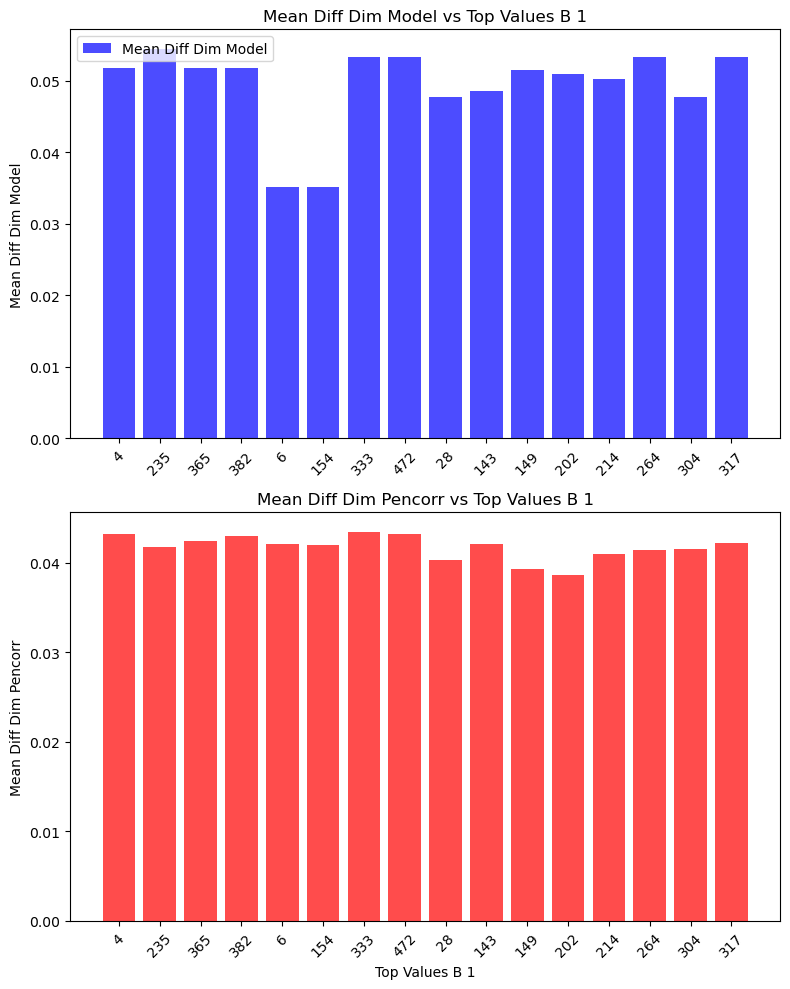

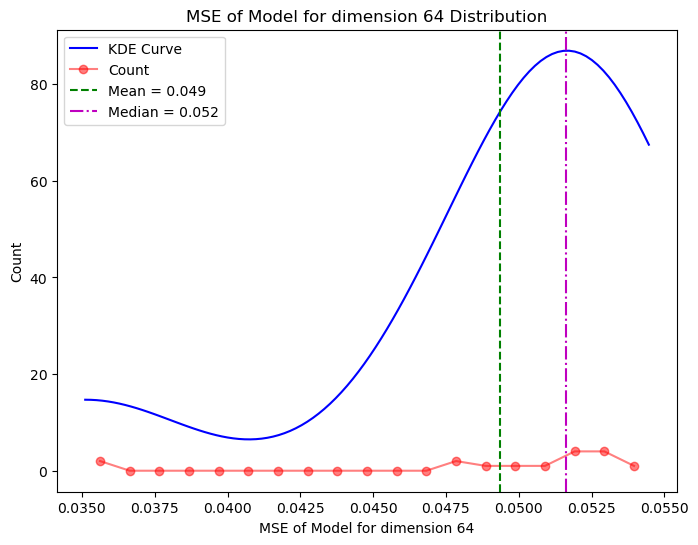

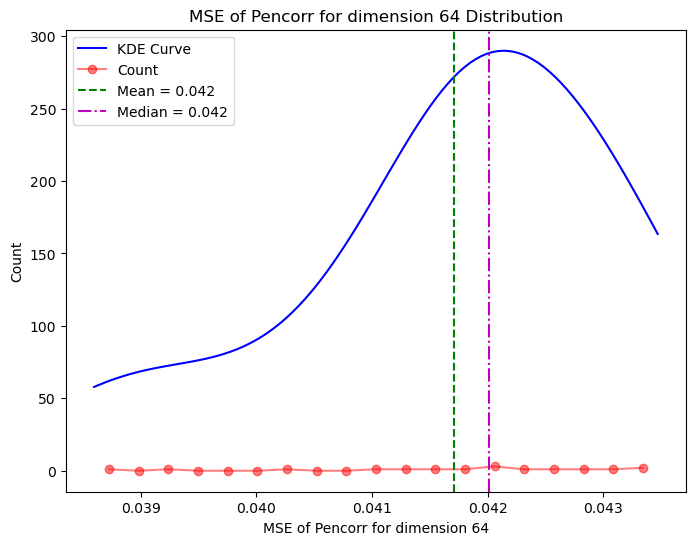

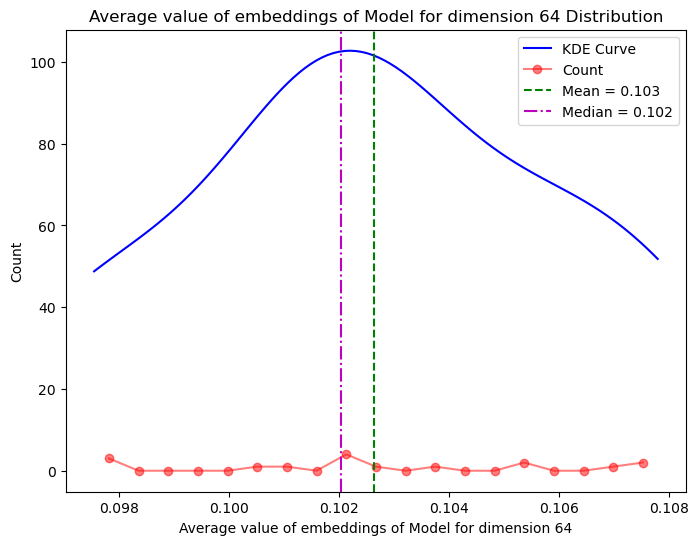

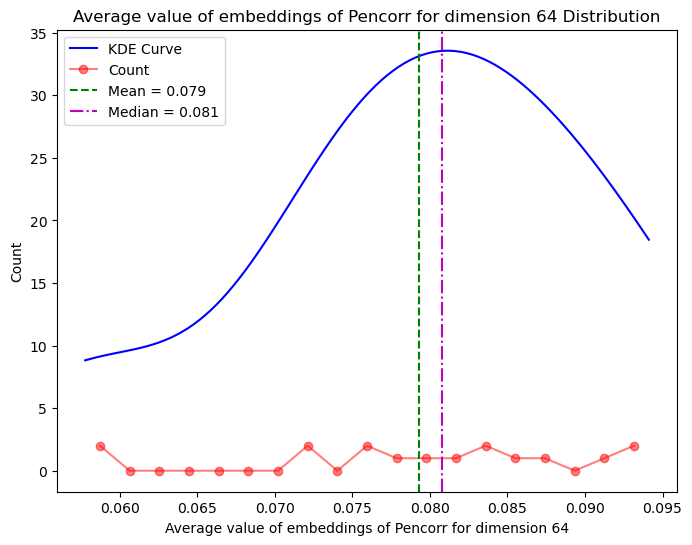

For dimension 128
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-0.0212,  0.0394,  0.0306,  0.0134, -0.0719,  0.1293, -0.0125, -0.0277,
          0.0628,  0.0481, -0.0660,  0.0271, -0.0872,  0.0270, -0.1107,  0.1007,
          0.0512, -0.2553, -0.0236, -0.0620,  0.1077, -0.0257,  0.0674, -0.0566,
         -0.0989, -0.1269, -0.0894, -0.0631, -0.0531, -0.0455, -0.0270,  0.0865,
         -0.0262, -0.0942,  0.1554,  0.0324,  0.0560, -0.0264, -0.0886, -0.0284,
          0.1150, -0.0116,  0.0892, -0.0471,  0.0363,  0.0254,  0.0362,  0.1659,
         -0.0805, -0.0262,  0.0507,  0.0131,  0.0133, -0.0060,  0.1080,  0.0337,
          0.1100, -0.0315, -0.0043,  0.1033, -0.0011, -0.0003, -0.0795,  0.1678,
         -0.1389,  0.0952, -0.1800,  0.0484,  0.0252,  0.0206,  0.1430, -0.1869,
          0.1078, -0.0388, -0.0756, -0.1365,  0.2115, -0.0246, -0.0047, -0.1589,
          0.1706, -0.1352, -0.0720, -0.0218,  0.1150, -0.2043,  0.0929,  0.0513,
         -0.1860,  0.03

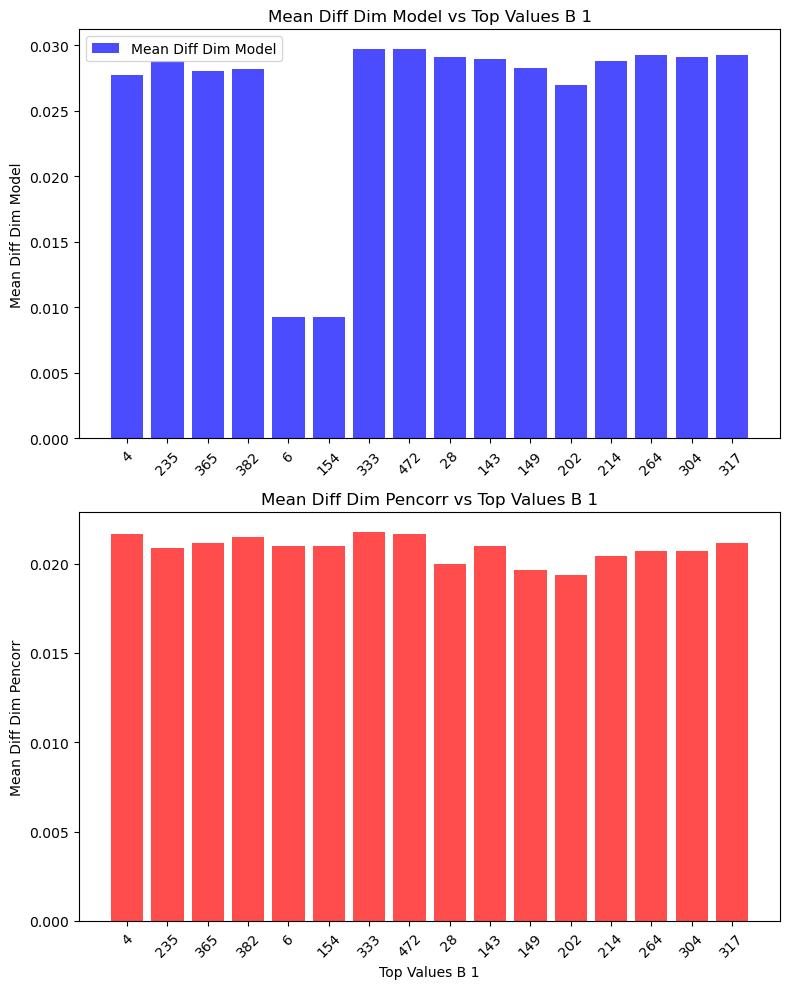

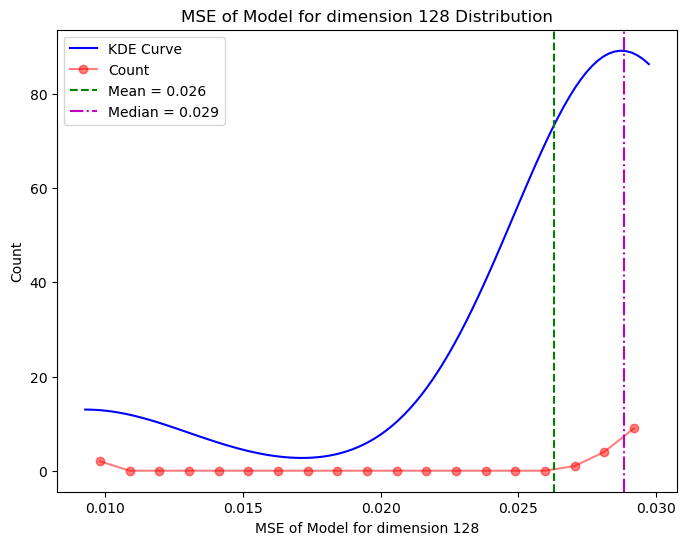

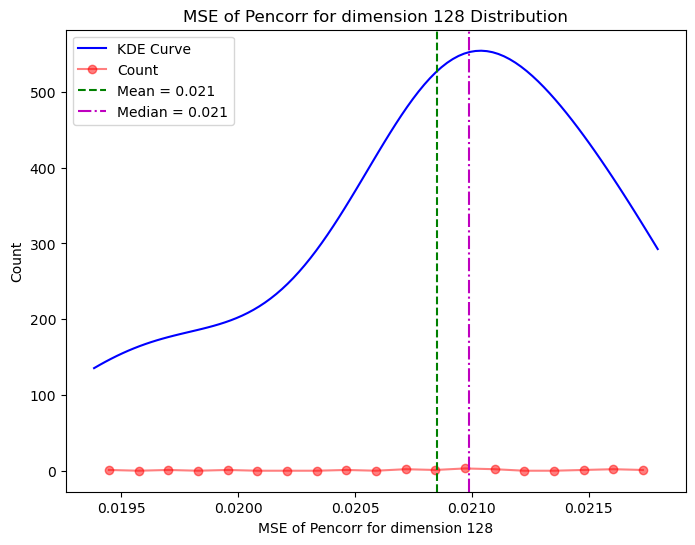

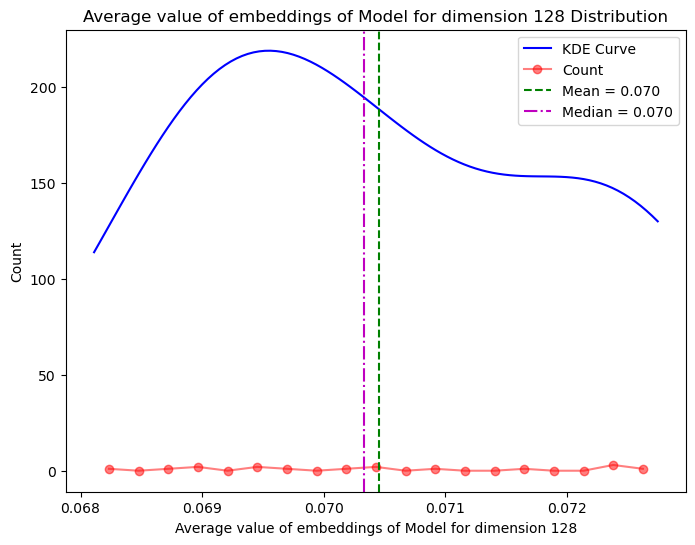

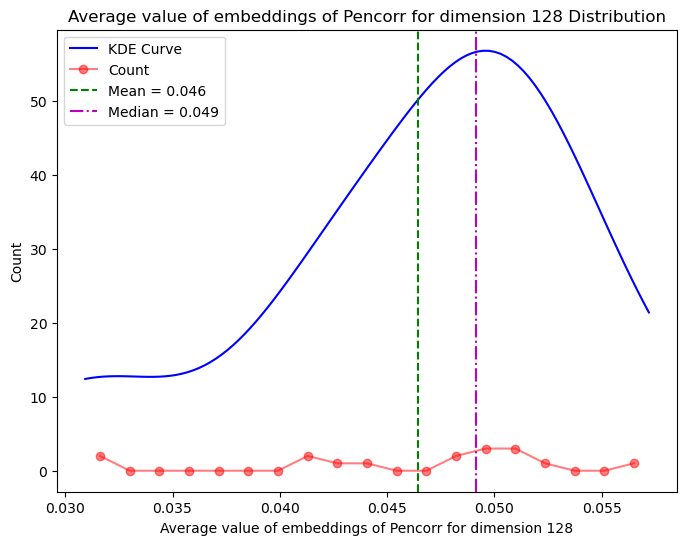

For dimension 256
4

Printing vectors for index 182
Embedding of image 182 for Model: tensor([[-3.8282e-03,  1.8197e-02,  7.6581e-02,  8.0126e-02,  9.2028e-02,
          7.7459e-02, -6.5348e-02,  3.8536e-02, -1.8748e-02,  1.2356e-02,
          4.5371e-02, -7.2015e-02,  7.6290e-02,  1.3057e-02,  9.1996e-02,
          6.5679e-02, -4.3771e-02,  3.2543e-02,  4.5019e-02,  1.3082e-02,
          1.1932e-02, -6.5331e-03,  2.6587e-02,  9.3583e-03, -2.6405e-02,
         -1.1284e-02, -2.2292e-02, -1.5141e-02,  2.0227e-03,  6.8603e-03,
          1.1373e-01, -2.6108e-02, -3.2601e-02, -7.0280e-02,  7.2471e-02,
          1.4404e-03,  1.1333e-02, -8.9436e-02, -3.7270e-02, -2.7711e-02,
          1.6223e-02, -1.1375e-01,  1.0560e-01,  3.6512e-02,  3.9507e-02,
          8.9829e-02, -5.8597e-02,  5.0303e-02, -2.2094e-03,  1.2568e-01,
          5.6418e-02, -1.3100e-01, -4.0238e-02,  4.5603e-02, -1.3708e-02,
          6.3503e-02,  9.9536e-02,  7.4157e-02,  2.0245e-02, -8.2710e-02,
         -4.3623e-02, -4.3

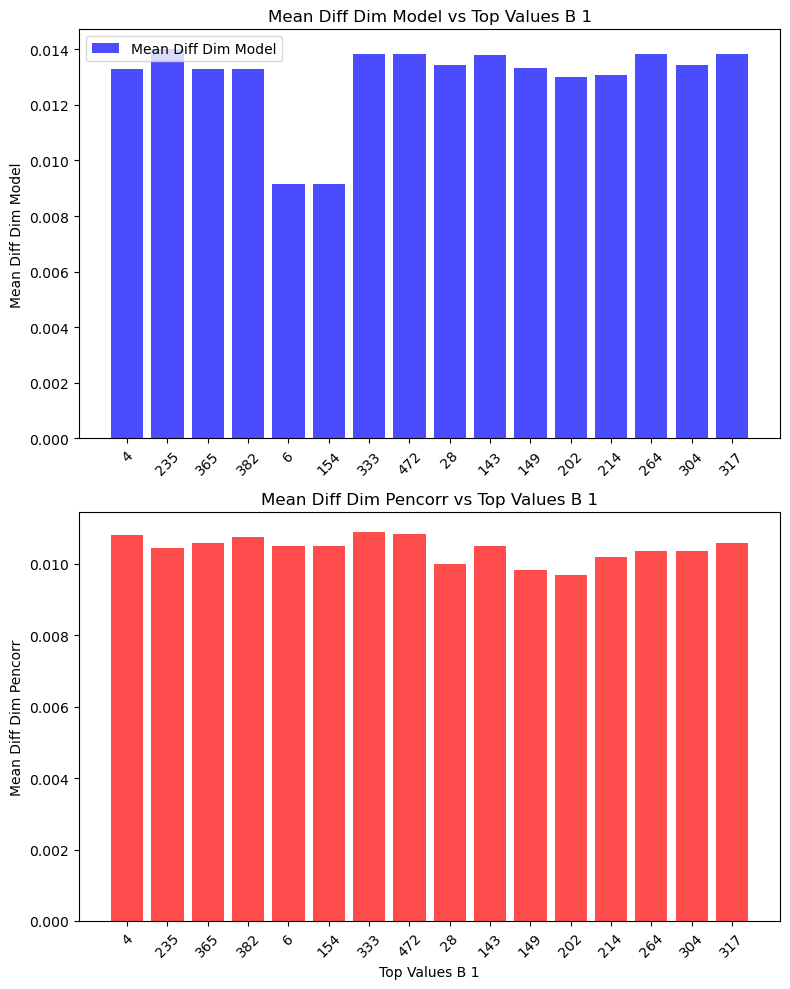

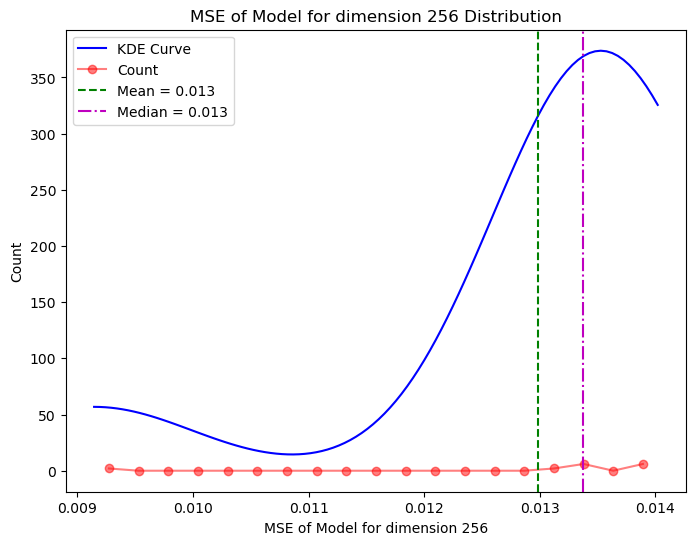

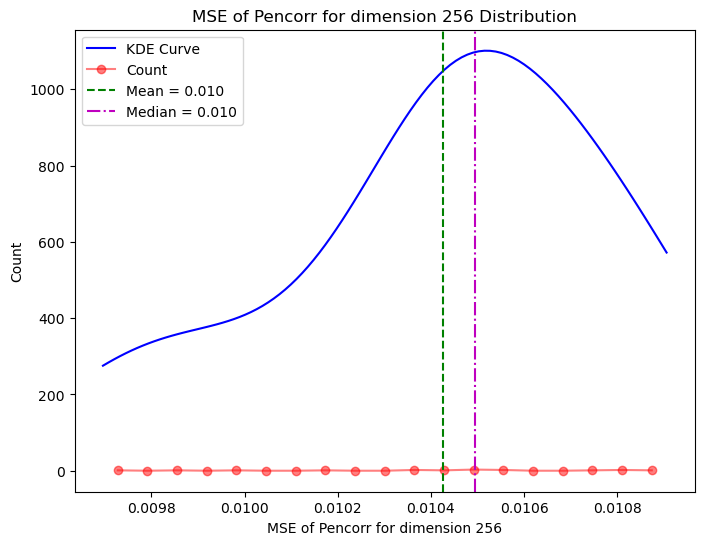

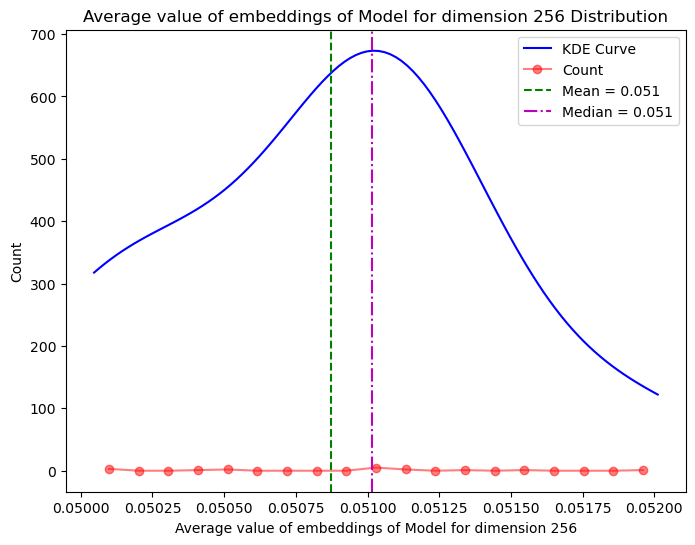

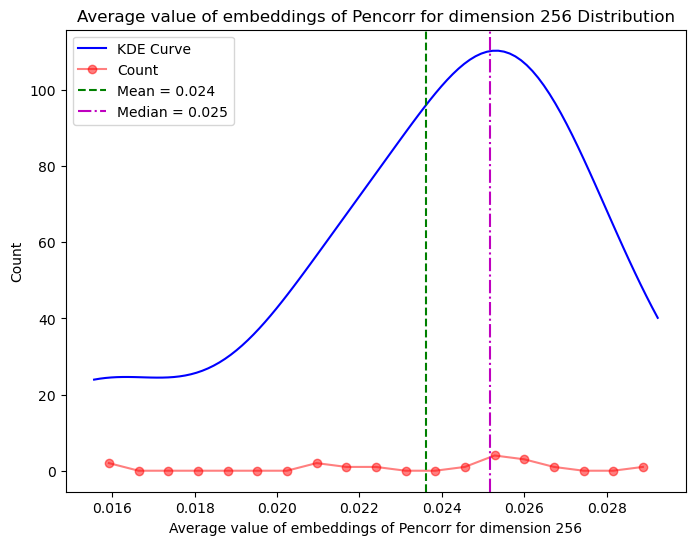

In [8]:
#comparison with different images
# ----------- Preprocessing dataset -------------
matrixG = imgcalc.get_matrixG(testSample, imageProductType)
dimensions = [5, 10, 20, 30, 40, 64, 128, 256]
for dim in dimensions:
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN1(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer0.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    mean_diff_dim_model = []
    mean_diff_dim_pencorr = []
    mean_values_dim_model = []
    mean_values_dim_pencorr = []
    for i in range(len(bottom_values_b_1)):
        top_1_index = bottom_values_b_1[i][0]
        print(top_1_index)
        print(f"\nPrinting vectors for index {index1}")
        print(f"Embedding of image {index1} for Model: {model_vectors[index1]}")    
        print(f"Embedding of similar image {top_1_index} for Model: {model_vectors[top_1_index]}")
        print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
        print(f"\nEmbedding of similar image {top_1_index} for Pencorr (A'A): {matrixA[:,top_1_index]}")

        print(f"\nDifferences between vector embeddings")
        mean_squared_difference = imgcalc.get_MSE(model_vectors[top_1_index].detach().cpu().numpy(), model_vectors[index1].detach().cpu().numpy())
        print(f"Mean Squared Difference of Model between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_model.append(mean_squared_difference)
        mean_values_dim_model.append(abs(model_vectors[top_1_index].detach().cpu().numpy()).mean())
        
        mean_squared_difference = imgcalc.get_MSE(matrixA[:,top_1_index], matrixA[:,index1])
        print(f"Mean Squared Difference of Pencorr (A'A) between 2 similar images: {mean_squared_difference}")
        mean_diff_dim_pencorr.append(mean_squared_difference)
        mean_values_dim_pencorr.append(abs(matrixA[:,top_1_index]).mean())

    indices = [x[0] for x in bottom_values_b_1]
    print(indices)
    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    axes[0].bar(range(len(indices)), mean_diff_dim_model, color='blue', alpha=0.7, label="Mean Diff Dim Model")
    axes[0].set_xticks(range(len(indices)))
    axes[0].set_xticklabels(indices, rotation=45) 
    axes[0].set_ylabel("Mean Diff Dim Model")
    axes[0].set_title("Mean Diff Dim Model vs Top Values B 1")
    axes[0].legend()

    axes[1].bar(range(len(indices)), mean_diff_dim_pencorr, color='red', alpha=0.7, label="Mean Diff Dim Pencorr")
    axes[1].set_xticks(range(len(indices)))
    axes[1].set_xticklabels(indices, rotation=45) 
    axes[1].set_xlabel("Top Values B 1")
    axes[1].set_ylabel("Mean Diff Dim Pencorr")
    axes[1].set_title("Mean Diff Dim Pencorr vs Top Values B 1")
    plt.tight_layout()
    plt.show()
    
    imgplt.plot_score_distribution(mean_diff_dim_model, f"MSE of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_diff_dim_pencorr, f"MSE of Pencorr for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_model, f"Average value of embeddings of Model for dimension {dim}")
    imgplt.plot_score_distribution(mean_values_dim_pencorr, f"Average value of embeddings of Pencorr for dimension {dim}")

In [9]:
#F1 score calculation per dimension
dimensions = [5, 10, 20, 30, 40, 64, 128, 256]
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

top_1_index = top_values_b_1[-1][0]
indices = [x[0] for x in top_values_b_1]
print(len(indices))
for dim in dimensions:    
    print(f"For dimension {dim}")
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN1(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer0.pt'), weights_only=True))

    model.eval()

    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    
    MSD_threshold = imgcalc.get_MSE(matrixA[:,top_1_index], model_vectors[top_1_index].detach().cpu().numpy())
    
    TP, TN, FP, FN = 0, 0, 0, 0

    for i in range(num):
        difference_squared = (matrixA[:, i] - model_vectors[i].detach().cpu().numpy()) ** 2
        mean_squared_difference = np.sum(difference_squared) / difference_squared.size
        
        predicted = mean_squared_difference <= MSD_threshold
        actual = i in indices

        if predicted and actual:
            TP += 1
        elif predicted and not actual:
            FP += 1
        elif not predicted and actual:
            FN += 1
        elif not predicted and not actual:
            TN += 1
    
    print(TP, TN, FP, FN)
    
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    f1 = f1*100
    print(f"F1 Score: {f1:.4f} for dimension {dim}")
    

16
For dimension 5
11 171 313 5
F1 Score: 6.4706 for dimension 5
For dimension 10
5 277 207 11
F1 Score: 4.3860 for dimension 10
For dimension 20
10 57 427 6
F1 Score: 4.4150 for dimension 20
For dimension 30
3 273 211 13
F1 Score: 2.6087 for dimension 30
For dimension 40
8 361 123 8
F1 Score: 10.8844 for dimension 40
For dimension 64
15 41 443 1
F1 Score: 6.3291 for dimension 64
For dimension 128
16 24 460 0
F1 Score: 6.5041 for dimension 128
For dimension 256
1 476 8 15
F1 Score: 8.0000 for dimension 256


In [8]:
#-----------------After transforming output embedding matrices via Orthorgonal Procrustes ----------------
print(f"Difference between matrices")
model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
model_matrix_transformed = imgcalc.get_matrix_embeddings(input_dataset, model_transformed)

mean_squared_difference = imgcalc.get_MSE(matrixG, model_matrix_transformed.detach().cpu().numpy())
print("\nMean Squared Difference of Model and NCC (G):", mean_squared_difference)
        
mean_squared_difference = imgcalc.get_MSE(dot_product_matrix, model_matrix_transformed.detach().cpu().numpy())
print("Mean Squared Difference of Model and Pencorr (A'A):", mean_squared_difference)
     

print(f"\nPrinting matrices after transformation")
print(f"\nMatrix G: {matrixG}")
print(f"\nMatrix A'A (Pencorr): {dot_product_matrix}, {dot_product_matrix.shape}")
print(f"\nMatrix A'A (Model): {model_matrix_transformed}, error: {error_model}")

print(f"\nPrinting vectors ")
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]}")
print(f"Embedding of image {index1} for Model: {model_transformed[index1]}")

print(f"\nDifferences between vector embeddings")
mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], model_transformed[index1].detach().cpu().numpy())
print(f"Mean Squared Difference of Pencorr (A) and Transformed Model: {mean_squared_difference}")

# magnitude = np.linalg.norm(model_transformed[index1].detach().cpu().numpy())
# print("magnitude: ", magnitude)
# vector = model_transformed[index1].detach().cpu().numpy()/magnitude
# print("vector after normalisation: ", vector)

# mean_squared_difference = imgcalc.get_MSE(matrixA[:,index1], vector)
# print(f"Mean Squared Difference of Pencorr (A) and Normalised TransformedModel: {mean_squared_difference}")
# magnitude = np.linalg.norm(vector)
# print("magnitude: ", magnitude)

Difference between matrices

Mean Squared Difference of Model and NCC (G): 0.11956805100670481
Mean Squared Difference of Model and Pencorr (A'A): 0.11231446932154523

Printing matrices after transformation

Matrix G: [[ 1.          0.33333337  0.7320509  ... -0.15983188 -0.15983188
  -0.24407101]
 [ 0.33333337  1.          0.7320509  ... -0.15983188 -0.15983188
  -0.24407107]
 [ 0.7320509   0.7320509   1.         ... -0.02985746 -0.02985746
  -0.12712848]
 ...
 [-0.15983188 -0.15983188 -0.02985746 ...  1.          0.64705884
   0.58776844]
 [-0.15983188 -0.15983188 -0.02985746 ...  0.64705884  1.
   0.48191714]
 [-0.24407101 -0.24407107 -0.12712848 ...  0.58776844  0.48191714
   1.        ]]

Matrix A'A (Pencorr): [[ 1.          0.30870054  0.63502134 ... -0.12332915 -0.10612115
  -0.22349462]
 [ 0.30870054  1.          0.54878227 ... -0.15996517 -0.08644592
  -0.23666728]
 [ 0.63502134  0.54878227  1.         ... -0.01023721 -0.01046551
  -0.11487031]
 ...
 [-0.12332915 -0.15996517 -


MSE between vector embeddings of Pencorr (A) and Model:


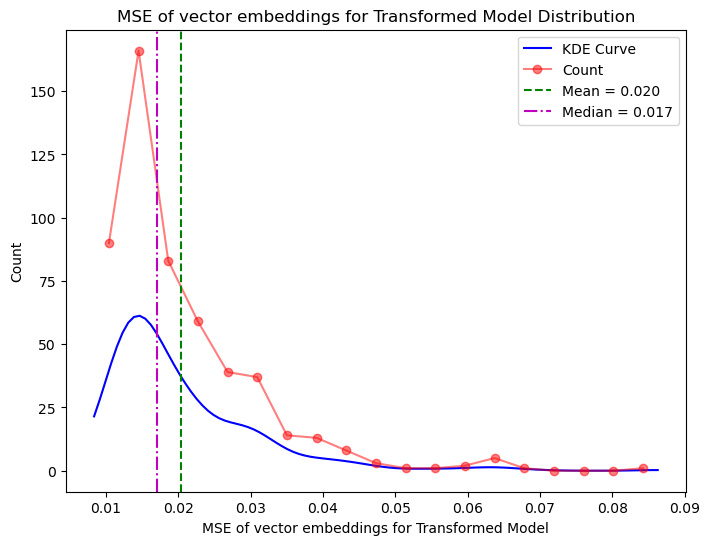

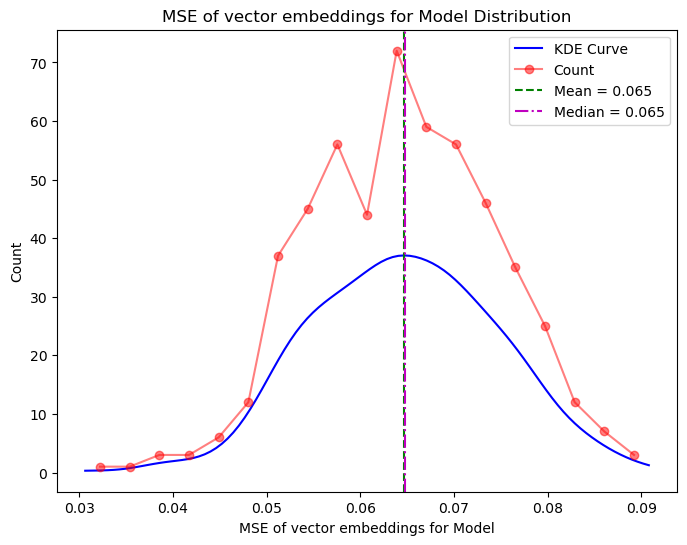

In [8]:
# ------------------------ MSE of embedding across dataset -----------------------------
num = len(input_dataset)
MSE_transformed = []
MSE_original = []
print(f"\nMSE between vector embeddings of Pencorr (A) and Model:")   
for i in range(num):
    difference_squared = (matrixA[:,i] - model_transformed[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
    MSE_transformed.append(mean_squared_difference)
    difference_squared = (matrixA[:,i] - model_vectors[i].detach().cpu().numpy()) ** 2
    mean_squared_difference = np.sum(difference_squared) / difference_squared.size
    #print(f"Original matrix of Index {i}: {mean_squared_difference}")
    MSE_original.append(mean_squared_difference)
    
imgplt.plot_score_distribution(MSE_transformed, "MSE of vector embeddings for Transformed Model")
imgplt.plot_score_distribution(MSE_original, "MSE of vector embeddings for Model")


MSE between vector embeddings of dimension 5 for Pencorr (A) and Model:


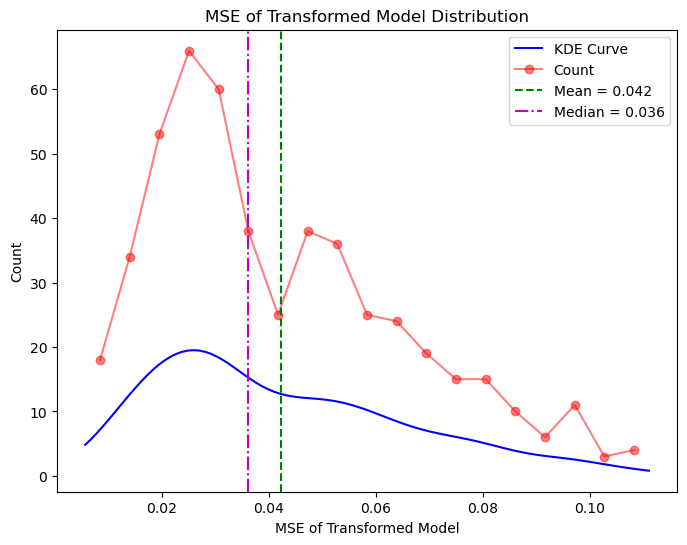

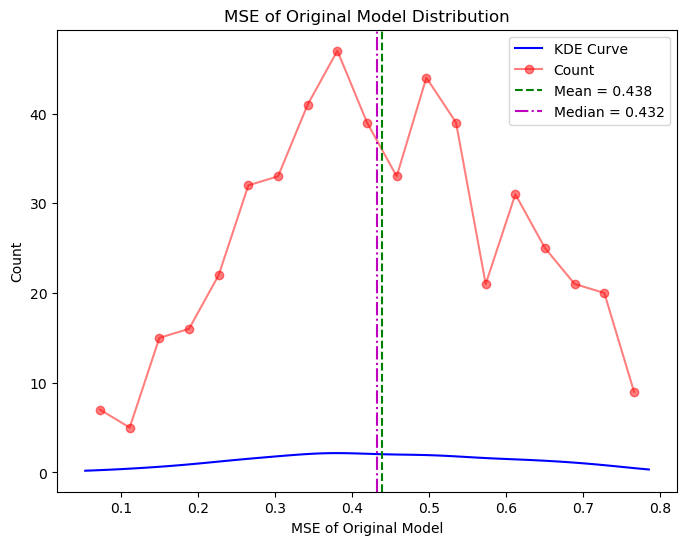


MSE between vector embeddings of dimension 10 for Pencorr (A) and Model:


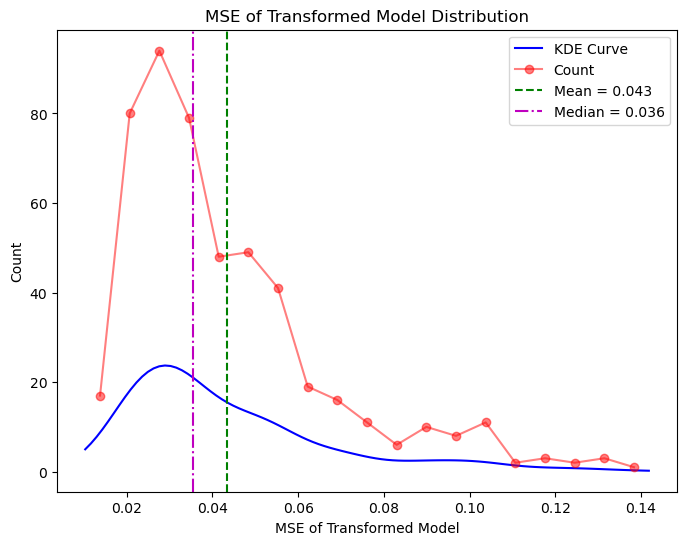

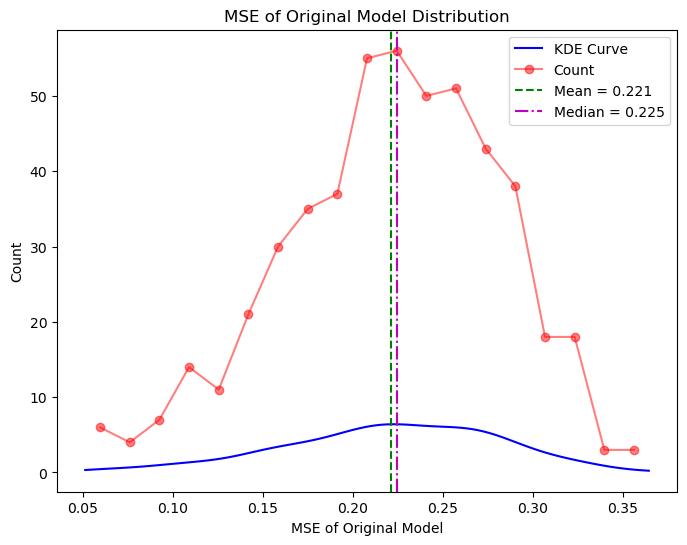


MSE between vector embeddings of dimension 20 for Pencorr (A) and Model:


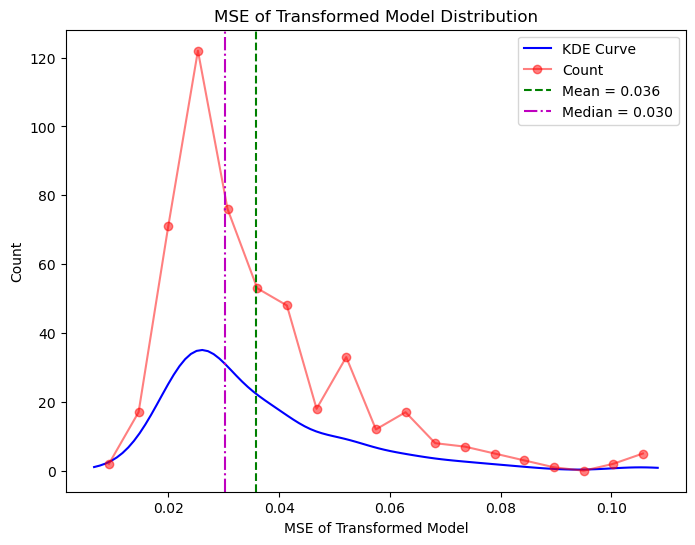

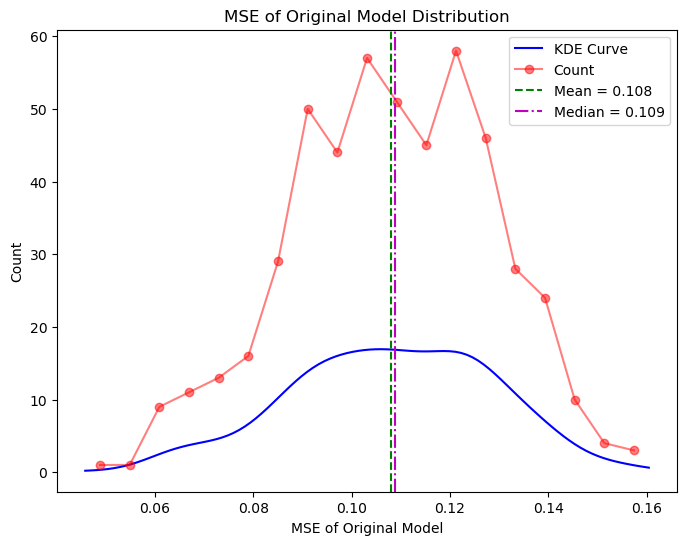


MSE between vector embeddings of dimension 30 for Pencorr (A) and Model:


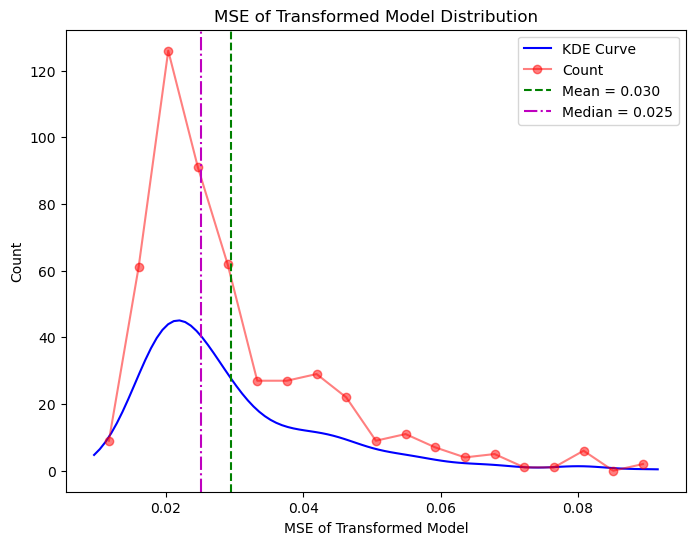

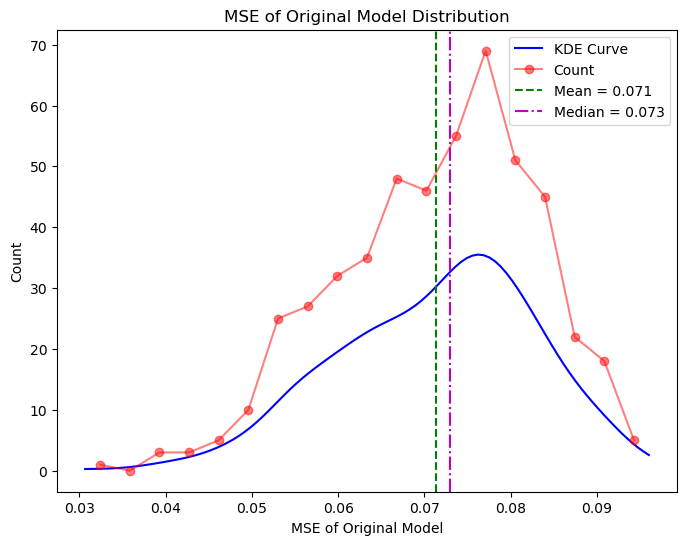


MSE between vector embeddings of dimension 40 for Pencorr (A) and Model:


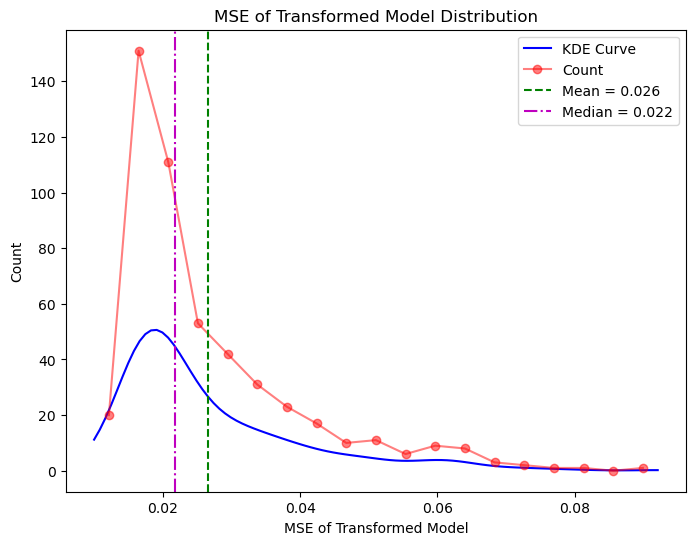

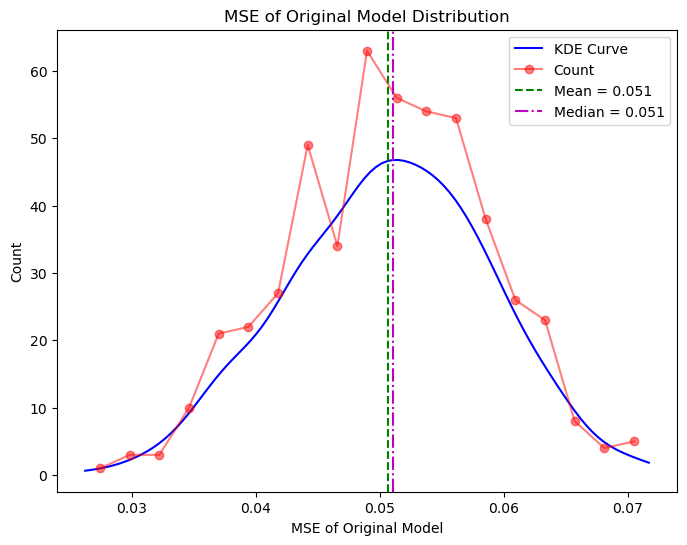


MSE between vector embeddings of dimension 64 for Pencorr (A) and Model:


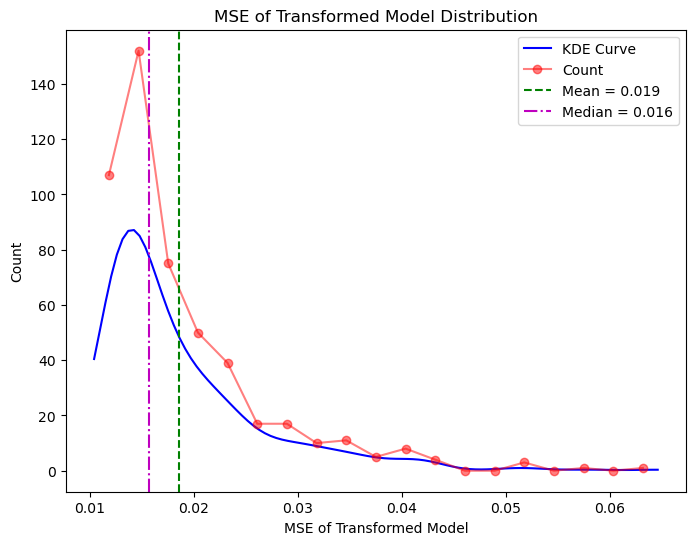

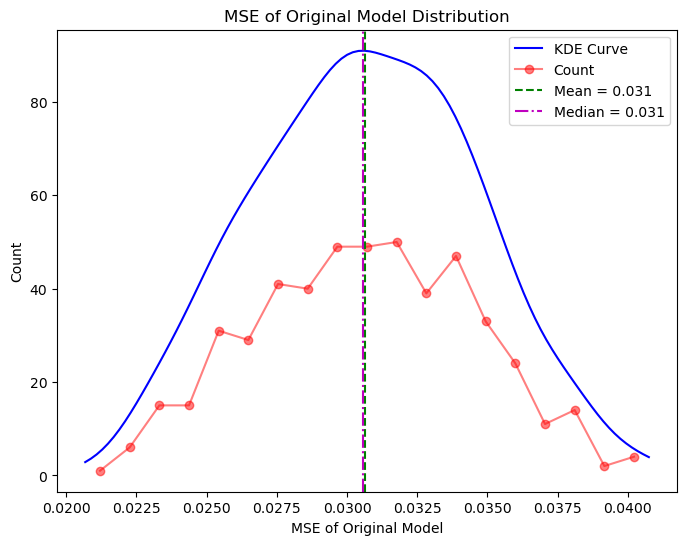


MSE between vector embeddings of dimension 128 for Pencorr (A) and Model:


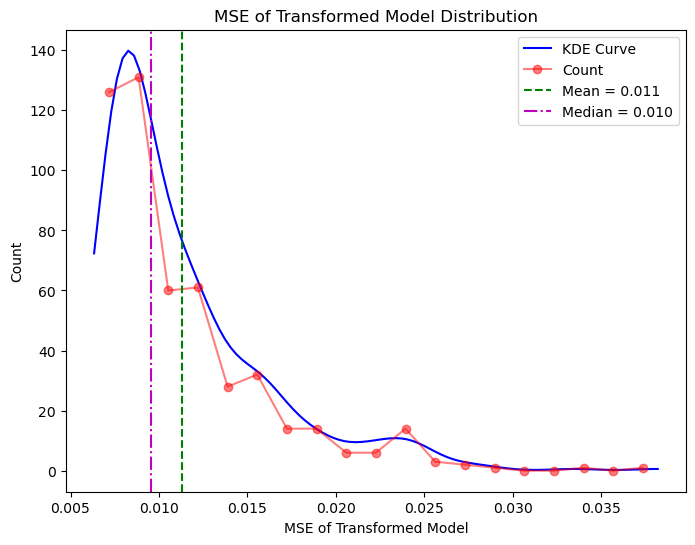

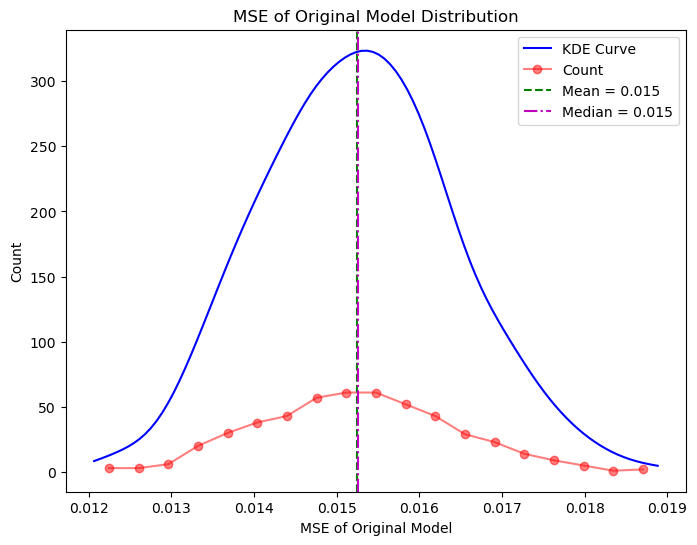


MSE between vector embeddings of dimension 256 for Pencorr (A) and Model:


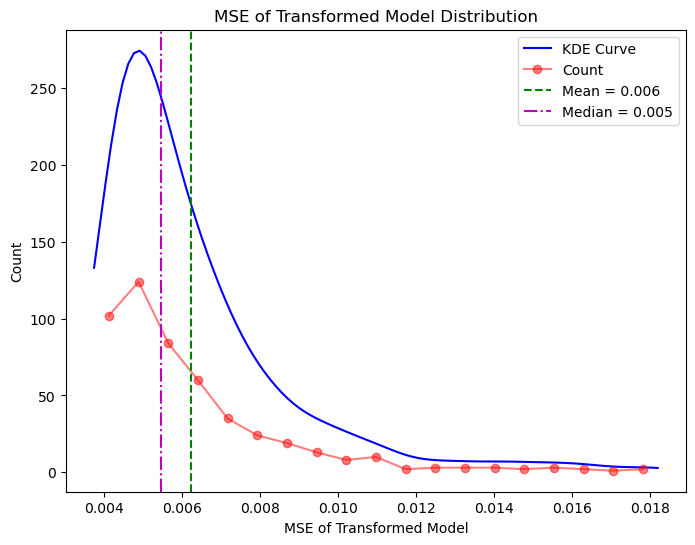

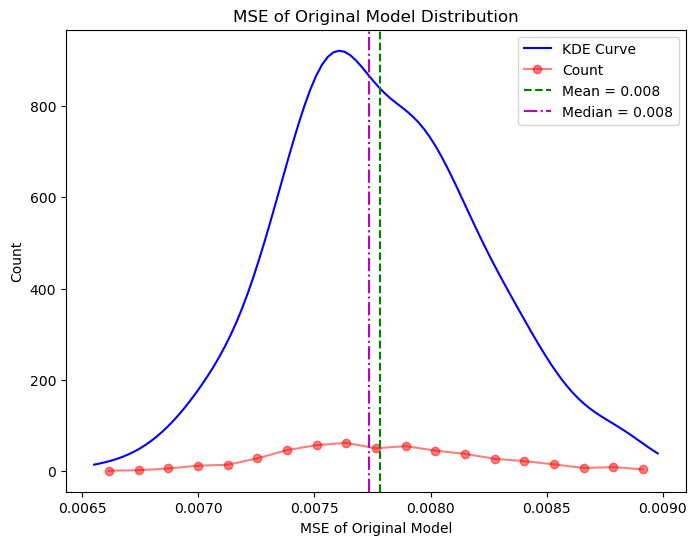

In [8]:
# ------------------------ MSE of embedding across dimensions across dataset -----------------------------
dimensions = [5, 10, 20, 30, 40, 64, 128, 256]
input_dataset = []
for img in testSample:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).to(device).double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 
stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).to(device).float() for data in input_dataset]
num = len(input_dataset)
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

for dim in dimensions:    
    embeddingType = f"pencorr_{dim}"

    model = models.SimpleCNN1(dimensions=dim, padding_mode='circular').to(device)
    model.load_state_dict(torch.load(os.path.join(os.path.abspath("../../VecRepV3"), "model", 
                     f'best_model_{imageType}_{dim}d_convlayer0.pt'), weights_only=True))

    model.eval()
    
    matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
    dot_product_matrix = np.dot(matrixA.T, matrixA)
    
    model_vectors = imgcalc.get_vector_embeddings(input_dataset, model)
    model_transformed, error_model = imgcalc.get_orthogonal_transformation(model_vectors, matrixA) #transposed
    model_transformed = [torch.tensor(row, dtype=torch.float32, device= device).unsqueeze(0).requires_grad_() for row in model_transformed]
    
    MSE_transformed = []
    MSE_original = []
    print(f"\nMSE between vector embeddings of dimension {dim} for Pencorr (A) and Model:")   
    for i in range(num):
        difference_squared = (matrixA[:,i] - model_transformed[i].detach().cpu().numpy()) ** 2
        mean_squared_difference = np.sum(difference_squared) / difference_squared.size
        #print(f"Transformed matrix of Index {i}: {mean_squared_difference}")
        MSE_transformed.append(mean_squared_difference)
        difference_squared = (matrixA[:,i] - model_vectors[i].detach().cpu().numpy()) ** 2
        mean_squared_difference = np.sum(difference_squared) / difference_squared.size
        #print(f"Original matrix of Index {i}: {mean_squared_difference}")
        MSE_original.append(mean_squared_difference)
        
    imgplt.plot_score_distribution(MSE_transformed, f"MSE of Transformed Model")
    imgplt.plot_score_distribution(MSE_original, f"MSE of Original Model")

In [ ]:
# -------------------- Using normalized embedding loss function to determine dimension--------------------
def find_optimal_dim(losses, eps=0.05): 
    """ losses: dict {dimension: L(d)} """
    L_inf = min(losses.values()) 
    for d in sorted(losses.keys()): 
        if (losses[d] - L_inf)/L_inf <= eps: 
            return d 
    return max(losses.keys())


In [9]:
# -------------- mega insane debug -----------------
tolerance = 1e-6
matrixG = imgcalc.get_matrixG(testSample, imageProductType)

rank = np.linalg.matrix_rank(matrixG)
print("Rank of the matrixG:", rank)

nDim = 128
# original image product matrix not PSD, after transformation,
matrixGprime = embedfunc.pencorr(matrixG, nDim) #reduce matrixG rank from image set size to nDim

print("g pirme")
rank = np.linalg.matrix_rank(matrixGprime) 
''' 
given 753 unique training samples, rank of matrixG is by right 753 
ndim 512: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 256: rank of g' = 120, 120 positive eigenvalues for g', 380 positive eigenvalues for g
ndim 64: rank of g' = 64, 64 positive eigenvalues for g', 380 positive eigenvalues for g

somewhere in the algorithm, it is coded such that pencorr striaghtaway finds the optimum rank of a matrix and minimises it
once rank is minimised to its optimum, the number of positive eigenvalues is only that number.
unless we set nDim < rank, we cannot change the number of positive eigenvalues.
this overall limits the number of dimensions we can test. 

essentially, since rank of g' determines the vector space formed by the rows and columns (linearly independent rows or columns in matrix),
the rank of a matrix is the number of non-zero eigenvalues of a matrix, which is why limiting the rank of the matrix to 120 only give
120 non-zero elements in our embedding dimension. 
'''
print("Rank of the matrixG':", rank)
eigenvalues, eigenvectors = np.linalg.eig(matrixGprime)
print(matrixGprime.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape) #753x753
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) 
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

matrixA = imgcalc.get_matrixA(matrixG, embeddingType, weight)
print(f"\nEmbedding of image {index1} for Pencorr (A'A): {matrixA[:,index1]} {matrixA.shape} {matrixA[:,index1].size}")
count_not_close_to_zero = np.sum(np.abs(matrixA[:,index1]) > tolerance)
print("Number of elements not close to tolerance 1e-5:", count_not_close_to_zero)

count_to_zero = np.sum(np.abs(matrixA[:,index1]) > 0)
print("Number of elements not close to 0:", count_to_zero)

print("g")
eigenvalues, eigenvectors = np.linalg.eig(matrixG)
print(matrixG.shape) #753x753
print(eigenvalues.shape) #753
print(eigenvectors.shape)
num_positive_eigenvalues = np.sum(eigenvalues > tolerance) #380 ????????
print("Number of eigenvalues greater than tolerance:", num_positive_eigenvalues)

Rank of the matrixG: 500
g pirme
Rank of the matrixG': 128
(500, 500)
(500,)
(500, 500)
Number of eigenvalues greater than 0: 128

Embedding of image 182 for Pencorr (A'A): [-5.47267208e-01  6.85274121e-02 -2.38028460e-01 -2.74942382e-01
  1.27518230e-01  4.40561892e-01  1.22415044e-01 -1.47233858e-01
 -7.56385998e-02 -5.82657803e-02  4.18958296e-02 -1.20776909e-01
  4.97361413e-02 -1.27383536e-02 -1.20196108e-01 -7.03198724e-02
 -3.63524779e-03  1.62504185e-02 -1.21541367e-01 -6.82538322e-02
  6.95328997e-03 -1.34012704e-01 -1.55183642e-02  2.81475156e-02
 -6.03882115e-02  6.45322863e-02  1.73894661e-01  7.13490646e-02
  4.15358624e-02  6.27635521e-03 -3.86025105e-02 -2.83082920e-02
 -2.20404262e-02  1.05742827e-01 -1.40238653e-01  1.35955846e-02
  1.53754912e-01 -7.35932485e-03 -3.89920821e-02  6.95864982e-02
 -9.13883895e-02  5.07247576e-02  5.03209368e-02  6.59893317e-02
 -6.56235045e-02  9.85685401e-02  3.58867222e-02 -4.84742996e-02
  4.94295154e-02  4.37712532e-02  8.15955110e-0